## Финальный проект в рамках практики от компании Wildberries & Russ.

# 🧩 Этап 2-4. Анализ решений и выбор подхода

## 🎯 Постановка задачи

Цель — построить интеллектуальную систему, способную **отвечать на вопросы** на основе базы знаний. 

На вход подаётся пара:
- `question` — текст вопроса;
- `know_df` — множество текстовых фрагментов знаний (`chunk`), структурированных по `document_id`.

На выходе — **релевантный ответ**:
- либо **извлекается** из текстов (`retrieval`),
- либо **генерируется** на основе знаний (`generation`),
- либо получается через комбинированный подход (retrieval + generation).

---

## 🔍 Теоретические подходы

| Подход                         | Описание                                                                                 | Применимость                                                   |
|-------------------------------|-------------------------------------------------------------------------------------------|----------------------------------------------------------------|
| **TF-IDF / BM25**             | Поиск схожих chunk'ов на основе частотных признаков слов                                 | Простой бейзлайн, быстрый, но слабый в семантическом понимании |
| **Embedding-based Retrieval** | Семантическое сопоставление вопросов и chunk'ов через эмбеддинги (SBERT и др.)           | Быстрее и точнее TF-IDF, хорошо работает в QA                  |
| **Cross-Encoder**             | Модель принимает `(question, chunk)` и оценивает релевантность                           | Высокая точность, но ресурсоёмкий                              |
| **Generative Models (T5, BART)** | Генерация ответа на основе вопроса и текста знаний                                       | Гибкость, требуется дообучение                                 |
| **RAG (Retrieval-Augmented)** | Комбинирует поиск и генерацию: извлекает и генерирует ответ                              | Один из лучших современных подходов                             |

---

## ✅ Выбранный подход

Учитывая:
- наличие связанной базы знаний по `document_id`,
- необходимость учитывать семантический контекст,
- важность генерации осмысленного ответа,

мы выбираем:

> 📌 **Retrieval-Augmented QA** — извлекаем релевантные фрагменты, затем генерируем ответ.

**Этапы:**
1. **Retrieval:**
   - Используем SBERT для преобразования `question` и `chunk` в эмбеддинги;
   - Сравнение через косинусное расстояние;
   - Отбор top-k наиболее релевантных chunk'ов.

2. **Generation:**
   - Используем T5 (или аналог) для генерации ответа на основе `(question + retrieved_chunk)`.

---

## 📊 Схема валидации

Для корректной оценки качества:

- применим **GroupKFold по `document_id`**, чтобы один документ не попадал одновременно в train и val;
- для retrieval используем метрики:
  - **Top-1/Top-3 Accuracy**
  - **MRR** (Mean Reciprocal Rank)
- для generation:
  - **ROUGE**
  - **BLEU**
  - **F1**
  - **оценка полноты и точности вручную или semi-automatic**

---

## 🚀 Переход к реализации

Далее:
- сформируем обучающую выборку:
  - положительные и отрицательные пары `(question, chunk)`;
- создадим генерационные пары `(question + top_chunk → answer)`;
- реализуем пайплайн retrieval и генерации;
- начнём валидацию и настройку моделей.



#### Загрузка датасетов

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

import random
from tqdm import tqdm
from sklearn.utils import shuffle
import re
from rapidfuzz import fuzz

import torch

from rank_bm25 import BM25Okapi

from pymorphy3 import MorphAnalyzer
from nltk.corpus import stopwords
from rank_bm25 import BM25Okapi

from sentence_transformers import SentenceTransformer, CrossEncoder, util
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

import faiss
from transformers import (AutoTokenizer, AutoModelForCausalLM, pipeline, 
                          GPT2Tokenizer, GPT2LMHeadModel, AutoTokenizer, 
                          AutoModelForSeq2SeqLM)

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import evaluate
from bert_score import score as bert_scorefrom
from torch.nn.utils.rnn import pad_sequence
from bert_score import score as bert_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import nltk
nltk.download('punkt')

c:\Users\boris\anaconda3\envs\conda2025-2026\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\boris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Пути к данным
RAW_PATH = '../data/'
files = os.listdir(RAW_PATH)
print("Доступные файлы:", files)
know_file_name = files[0] # база знаний 
pairs_file_name = files[1] # вопросы и ответы

Доступные файлы: ['knowledge_base.xlsx', 'QA_pairs.xlsx']


In [3]:
# Задаем путь, чтобы из таблицы вытащить листы
know_file_path = "../data/" + know_file_name
know_file_xls = pd.ExcelFile(know_file_path)

In [4]:
# Второй датасет
qa_pairs_path = "../data/" + pairs_file_name
qa_pairs_xls = pd.ExcelFile(qa_pairs_path)

In [5]:
# Превью каждого листа
dfs = {}
for sheet in know_file_xls.sheet_names:
    df = know_file_xls.parse(sheet)
    dfs[sheet] = df

In [6]:
# Превью для вопросов и ответов
qa_pairs_xls.sheet_names
# Распарсиваем и переводим в формат .csv
qa_sheet = qa_pairs_xls.sheet_names[0]
qa_pairs_df = qa_pairs_xls.parse(qa_sheet)
dfs

{'Knowledge_base':        id                                              chunk  document_id  \
 0    1588  Оферта – условия настоящей оферты об оказании ...            1   
 1    1589  Исполнитель – коммерческая организация или инд...            1   
 2    1590  Заказчик или Вайлдберриз - одно из перечисленн...            1   
 3    1591  Договор – договор об оказании услуг, заключенн...            1   
 4    1592  Пункт выдачи заказов (ПВЗ) – нежилое помещение...            1   
 ..    ...                                                ...          ...   
 928  1498  Обязательно ли проверять соответствие, если мы...           13   
 929  1499  В одну коробку можно класть НЕпереупакованые т...           13   
 930  1586  Как переупаковывать верхнюю одежду <nt> Провер...           13   
 931  1587  На товаре нет ни бирки, ни вшивных элементов п...           13   
 932  1997  Осторожно! Орудуют мошенники! <nt> ❗️Поступила...           13   
 
      part_id  
 0        1.0  
 1        1.

In [7]:
know_df = dfs['Knowledge_base']
pairs_df = dfs['Sources']
print(f'\n📝 Лист: Knowledge_base')
print(know_df.shape)
know_df.head()


📝 Лист: Knowledge_base
(933, 4)


,id,chunk,document_id,part_id
0,1588,Оферта – условия настоящей оферты об оказании ...,1,1.0
1,1589,Исполнитель – коммерческая организация или инд...,1,1.0
2,1590,Заказчик или Вайлдберриз - одно из перечисленн...,1,1.0
3,1591,"Договор – договор об оказании услуг, заключенн...",1,1.0
4,1592,Пункт выдачи заказов (ПВЗ) – нежилое помещение...,1,1.0


In [8]:
know_df.fillna({'part_id': know_df['part_id'].median()}, inplace=True)

In [9]:
qa_pairs_df

,id,question,answer
0,2,Как вернуть на экран баланс?,"В полной версии сайта слева, в разделе ""Аналит..."
1,3,Какой договор заключается?,"1. Оферта – это самый важный документ, описыва..."
2,5,Какая минимальная площадь помещения?,"Площадь помещения, соответствующая требованиям..."
3,6,Какие требования к площади помещения?,"Площадь помещения, соответствующая требованиям..."
4,9,Как зарегистрироваться?,Для открытия пункта WB необходимо выполнить сл...
...,...,...,...
5927,12994,Как найти товар про баркоду?,Функционал просмотра истории товара доступен в...
5928,13000,Тональный крем отказ на ПВЗ,В случае обнаружения брака/несоответствия при ...
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр..."
5930,13006,Можно ли отказаться в момент получения от колг...,"Если можно вскрыть заводскую упаковку товара, ..."


In [10]:
know_df

,id,chunk,document_id,part_id
0,1588,Оферта – условия настоящей оферты об оказании ...,1,1.0
1,1589,Исполнитель – коммерческая организация или инд...,1,1.0
2,1590,Заказчик или Вайлдберриз - одно из перечисленн...,1,1.0
3,1591,"Договор – договор об оказании услуг, заключенн...",1,1.0
4,1592,Пункт выдачи заказов (ПВЗ) – нежилое помещение...,1,1.0
...,...,...,...,...
928,1498,"Обязательно ли проверять соответствие, если мы...",13,0.0
929,1499,В одну коробку можно класть НЕпереупакованые т...,13,0.0
930,1586,Как переупаковывать верхнюю одежду <nt> Провер...,13,0.0
931,1587,"На товаре нет ни бирки, ни вшивных элементов п...",13,0.0


In [11]:
pairs_df

,document_id,title
0,8,База знаний Point
1,10,Обучение WBPoint
2,9,WB Point NEWS
3,13,Вопрос-ответ
4,12,Портал обучения WBPortal
5,1,Оферта
6,5,Приложение к оферте о технических требованиях ...
7,4,Приложение к оферте о правилах оказания услуг
8,3,Приложение к оферте о брендировании
9,6,Приложение к оферте о программах реализации де...


In [12]:
pairs_df.isna().sum(), know_df.isna().sum(), qa_pairs_df.isna().sum()

(document_id    0
 title          0
 dtype: int64,
 id             0
 chunk          0
 document_id    0
 part_id        0
 dtype: int64,
 id          0
 question    0
 answer      0
 dtype: int64)

#### Соединение в единый датасет

***Цель:***
Автоматически определить, к какому документу из базы знаний относится каждый вопрос пользователя.

**Что мы делаем**:

У нас есть два набора данных:

qa_pairs_df: вопросы и ответы;

know_df: фрагменты из документов (chunks) с привязкой к document_id.

***Мы пытаемся найти наиболее подходящий document_id для каждого вопрос, сравнивая:***

текст вопроса и ответа,

заголовки документов (title из pairs_df),

и текстовые фрагменты из know_df.

***Используем приблизительное текстовое совпадение для нахождения наилучшего соответствия между вопросом и документами.***

Это позволяет создать размеченные пары "вопрос — документ", обучить или дообучить модель поиска ответов по базе знаний, реализовать поиск ответа на основе смысла, а не ключевых слов в дальнейшем.

In [32]:
# 1. Соберем текст документа по document_id
doc_texts = know_df.groupby("document_id")["chunk"].apply(lambda x: " ".join(x)).to_dict()

# 2. Функция сопоставления ответа с документом по fuzzy matching
def assign_document_id_by_answer(qa_df, doc_texts, threshold=80):
    matched_ids = []
    scores = []

    for _, row in tqdm(qa_df.iterrows(), total=len(qa_df)):
        answer = str(row["answer"]).strip()

        best_score = 0
        best_doc_id = None

        for doc_id, text in doc_texts.items():
            score = fuzz.partial_ratio(answer, text)
            if score > best_score and score >= threshold:
                best_score = score
                best_doc_id = doc_id

        matched_ids.append(best_doc_id)
        scores.append(best_score)

    qa_df = qa_df.copy()
    qa_df["document_id"] = matched_ids
    qa_df["match_score"] = scores
    return qa_df

In [119]:
qa_pairs_df_with_doc = assign_document_id_by_answer(qa_pairs_df, doc_texts, threshold=80)

  4%|▍         | 237/5932 [00:24<09:50,  9.65it/s]


KeyboardInterrupt: 

In [14]:
matched = qa_pairs_df_with_doc["document_id"].notna().mean()
print(f"Процент найденных document_id: {matched:.2%}")

Процент найденных document_id: 42.72%


Видим, что процент совпадений ниже среднего, что не очень приятно. Нужно подумать, как сделать так, чтобы как можно точно склеить данные из базы знаний с тем что имеем.

In [124]:
know_df

,id,chunk,document_id,part_id
0,1588,Оферта – условия настоящей оферты об оказании ...,1,1.0
1,1589,Исполнитель – коммерческая организация или инд...,1,1.0
2,1590,Заказчик или Вайлдберриз - одно из перечисленн...,1,1.0
3,1591,"Договор – договор об оказании услуг, заключенн...",1,1.0
4,1592,Пункт выдачи заказов (ПВЗ) – нежилое помещение...,1,1.0
...,...,...,...,...
928,1498,"Обязательно ли проверять соответствие, если мы...",13,0.0
929,1499,В одну коробку можно класть НЕпереупакованые т...,13,0.0
930,1586,Как переупаковывать верхнюю одежду <nt> Провер...,13,0.0
931,1587,"На товаре нет ни бирки, ни вшивных элементов п...",13,0.0


In [120]:
def match_answers_to_docs(qa_df, know_df):
    doc_ids = []

    for _, row in tqdm(qa_df.iterrows(), total=len(qa_df)):
        answer = str(row['answer']).strip()
        
        # Поиск в chunks
        matched = know_df[know_df['chunk'].str.contains(re.escape(answer), case=False, na=False)]
        
        if not matched.empty:
            doc_id = matched.iloc[0]['document_id']
        else:
            doc_id = None

        doc_ids.append(doc_id)

    qa_df = qa_df.copy()
    qa_df['document_id'] = doc_ids
    return qa_df

In [121]:
qa_pairs_df = match_answers_to_docs(qa_pairs_df, know_df)
print("Процент не найденных документ-идов:", qa_pairs_df['document_id'].isna().mean())

100%|██████████| 5932/5932 [00:18<00:00, 324.98it/s]

Процент не найденных документ-идов: 0.8730613621038436


In [160]:
qa_pairs_df

,id,question,answer
0,2,Как вернуть на экран баланс?,"В полной версии сайта слева, в разделе ""Аналит..."
1,3,Какой договор заключается?,"1. Оферта – это самый важный документ, описыва..."
2,5,Какая минимальная площадь помещения?,"Площадь помещения, соответствующая требованиям..."
3,6,Какие требования к площади помещения?,"Площадь помещения, соответствующая требованиям..."
4,9,Как зарегистрироваться?,Для открытия пункта WB необходимо выполнить сл...
...,...,...,...
5927,12994,Как найти товар про баркоду?,Функционал просмотра истории товара доступен в...
5928,13000,Тональный крем отказ на ПВЗ,В случае обнаружения брака/несоответствия при ...
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр..."
5930,13006,Можно ли отказаться в момент получения от колг...,"Если можно вскрыть заводскую упаковку товара, ..."


In [161]:
# Для быстрого поиска
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Загружаем
answers = qa_pairs_df['answer'].tolist()
chunks = know_df['chunk'].tolist()

# TF-IDF по всем текстам (объединяем в один векторизатор)
vectorizer = TfidfVectorizer().fit(answers + chunks)
answers_vec = vectorizer.transform(answers)
chunks_vec = vectorizer.transform(chunks)

# Поиск наиболее похожего chunk для каждого ответа
top_ids = []
for ans_vec in tqdm(answers_vec, desc="🔗 Matching answers to chunks"):
    sims = cosine_similarity(ans_vec, chunks_vec).flatten()
    best_idx = np.argmax(sims)
    top_ids.append(best_idx)

# Добавим найденные document_id и chunk_id в qa_pairs_df
qa_pairs_df['matched_chunk_id'] = top_ids
qa_pairs_df['matched_document_id'] = qa_pairs_df['matched_chunk_id'].apply(lambda i: know_df.loc[i, 'document_id'])


🔗 Matching answers to chunks: 5932it [00:04, 1354.85it/s]


In [175]:
qa_pairs_df

,id,question,answer,matched_chunk_id,matched_document_id
0,2,Как вернуть на экран баланс?,"В полной версии сайта слева, в разделе ""Аналит...",900,13
1,3,Какой договор заключается?,"1. Оферта – это самый важный документ, описыва...",791,13
2,5,Какая минимальная площадь помещения?,"Площадь помещения, соответствующая требованиям...",260,8
3,6,Какие требования к площади помещения?,"Площадь помещения, соответствующая требованиям...",260,8
4,9,Как зарегистрироваться?,Для открытия пункта WB необходимо выполнить сл...,801,13
...,...,...,...,...,...
5927,12994,Как найти товар про баркоду?,Функционал просмотра истории товара доступен в...,751,13
5928,13000,Тональный крем отказ на ПВЗ,В случае обнаружения брака/несоответствия при ...,249,8
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр...",801,13
5930,13006,Можно ли отказаться в момент получения от колг...,"Если можно вскрыть заводскую упаковку товара, ...",285,8


In [163]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Тексты и целевая переменная
X = qa_pairs_df['question']
y = qa_pairs_df['matched_document_id']

# Разделение
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# TF-IDF
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

# Модель
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)

# Accuracy
print("🎯 Accuracy:", clf.score(X_val_vec, y_val))


🎯 Accuracy: 0.6882898062342039


In [17]:
def build_retrieval_dataset(qa_df, know_df, top_n_negatives=3):
    retrieval_data = []

    for _, row in tqdm(qa_df.iterrows(), total=len(qa_df)):
        question = row['question']
        answer = str(row['answer']).strip()
        document_id = row['document_id']

        # Пропустить, если нет document_id
        if pd.isna(document_id):
            continue

        document_chunks = know_df[know_df['document_id'] == document_id]

        # Найти chunk с ответом
        positive_found = False
        for _, chunk_row in document_chunks.iterrows():
            chunk = chunk_row['chunk']
            if answer in chunk:
                retrieval_data.append({
                    'question': question,
                    'chunk': chunk,
                    'label': 1
                })
                positive_found = True
                break

        # Добавим негативные
        if positive_found:
            negative_chunks = document_chunks[~document_chunks['chunk'].str.contains(answer, na=False)]
            negative_samples = negative_chunks.sample(
                n=min(top_n_negatives, len(negative_chunks)),
                random_state=42
            )
            for _, neg_row in negative_samples.iterrows():
                retrieval_data.append({
                    'question': question,
                    'chunk': neg_row['chunk'],
                    'label': 0
                })

    df_retrieval = pd.DataFrame(retrieval_data)
    return shuffle(df_retrieval, random_state=42).reset_index(drop=True)


In [18]:
retrieval_df = build_retrieval_dataset(qa_pairs_df, know_df, top_n_negatives=3)
retrieval_df.head()


  1%|          | 61/5932 [00:00<00:10, 571.11it/s]C:\Users\boris\AppData\Local\Temp\ipykernel_21360\978268608.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  negative_chunks = document_chunks[~document_chunks['chunk'].str.contains(answer, na=False)]
100%|██████████| 5932/5932 [00:11<00:00, 501.32it/s]


,question,chunk,label
0,Сколько дней на оспаривание подмен?,Возврат товара другого Вайлдберриз<nt>Клиент м...,0
1,Товар не для нашего ПВЗ. Что делать?,Как убрать излишек из программы ошибочного ШК?...,1
2,"Поставили 1. Можно удалить этот комментарий, т...",не могу принять коробку<nt> Начните принимать ...,0
3,Почему за оценки которые ставят за товар невни...,"Тикет по теме смена собственника, когда это бу...",0
4,Оплаченный товар висит в ожидании оплаты,Пришла не та коробка по ошибке для другого пун...,0


In [19]:
retrieval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2778 entries, 0 to 2777
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  2778 non-null   object
 1   chunk     2778 non-null   object
 2   label     2778 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 65.2+ KB


Попробуем добавить следующие улучшения:
* добавим `fuzz.token_set_ratio` вместо `partial_ratio`;
* скомбинируем answer + question при сравнении;
* снизим порог.

In [20]:
def assign_document_id_by_answer(qa_df, doc_texts, threshold=70):
    matched_ids, scores = [], []

    for _, row in tqdm(qa_df.iterrows(), total=len(qa_df)):
        full_text = f"{str(row['question']).strip()} {str(row['answer']).strip()}"
        best_score, best_doc_id = 0, None

        for doc_id, text in doc_texts.items():
            score = fuzz.token_set_ratio(full_text, text)
            if score > best_score and score >= threshold:
                best_score = score
                best_doc_id = doc_id

        matched_ids.append(best_doc_id)
        scores.append(best_score)

    qa_df = qa_df.copy()
    qa_df["document_id"] = matched_ids
    qa_df["match_score"] = scores
    return qa_df


In [21]:
qa_pairs_df_with_doc = assign_document_id_by_answer(qa_pairs_df, doc_texts, threshold=70)
# retrieval_df = build_retrieval_dataset(qa_pairs_df_with_doc, know_df, top_n_negatives=3)
print("Процент не найденных документ-идов:", qa_pairs_df['document_id'].isna().mean())

100%|██████████| 5932/5932 [02:53<00:00, 34.18it/s]

Процент не найденных документ-идов: 0.8730613621038436


In [22]:
matched = qa_pairs_df_with_doc["document_id"].notna().mean()
print(f"Процент найденных document_id: {matched:.2%}")

Процент найденных document_id: 91.79%


Отлично, склейка прошла уже гораздо успешно, данной точности вполне хватит чтобы продолжить обучение моделей. Мы смогли автоматически привязать около 92% вопросов к релевантному документу. Это отличный фундамент для построения retrieval-системы

In [23]:
# Сборка тренировочного датасета для retrieval модели
retrieval_df = build_retrieval_dataset(qa_pairs_df_with_doc, know_df, top_n_negatives=3)

  2%|▏         | 133/5932 [00:01<00:46, 124.16it/s]C:\Users\boris\AppData\Local\Temp\ipykernel_21360\978268608.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  negative_chunks = document_chunks[~document_chunks['chunk'].str.contains(answer, na=False)]
100%|██████████| 5932/5932 [00:51<00:00, 114.36it/s]


In [24]:
# ПРоверим распределение по айдишнику
qa_pairs_df_with_doc["document_id"].value_counts().head(10)

document_id
13.0    3277
9.0     1350
8.0      362
12.0     186
1.0      151
10.0      78
4.0       18
5.0       10
2.0        7
3.0        6
Name: count, dtype: int64

In [25]:
retrieval_df

,question,chunk,label
0,Переупаковка,"Переупаковка<nt>Переупаковка - это процесс, пр...",1
1,"Почему списали с баланса, если удержание было ...",Почему за оспоренный товар удержали?<nt> При в...,1
2,Почему сняли деньги с ПВЗ за возврат поставщику?,Какие товары нельзя открывать до оплаты?<nt>То...,0
3,Почему из системы до сих пор не ушла коробка с...,не могу принять коробку<nt> Начните принимать ...,0
4,Почему не отображается на графике сегодняшнее ...,Статистика приемки высвечивается не корректно ...,1
...,...,...,...
2437,Почему дают только 5 попыток чтоб подобрать ко...,Что означает ошибка Превышено количество попыт...,1
2438,"Как отправить большой товар, если не влазит?",Какие товары нельзя открывать до оплаты?<nt>То...,0
2439,Списан на ПВЗ,Что такое Зависшие ШК?<nt>Зависшие товары - эт...,1
2440,"В Тикете написано, что удержание снято, а на с...",Почему за оспоренный товар удержали?<nt> При в...,1


In [26]:
qa_pairs_df_with_doc.sample(10)[["question", "answer", "document_id"]].merge(pairs_df, on="document_id", how="left")

,question,answer,document_id,title
0,Сколько принято коробок?,"Раздел ""Аналитика и финансы"" подраздел ""Статис...",NaN,NaN
1,Кому и как передать ключи от ПВЗ для доставки ...,"Подготовьте дубликат ключей для перевозчика, и...",13.0,Вопрос-ответ
2,Как получить световую вывеску в подарок при от...,"Вы можете заказать вывеску через сайт, восполь...",13.0,Вопрос-ответ
3,"Создали коробку, выходит номер произвольный, х...","После того, как заполните коробку, закройте её...",13.0,Вопрос-ответ
4,Почему пишет внести оплату? Когда можно ремонт...,Информацию по открытию ПВЗ можно уточнить на п...,NaN,NaN
5,При возврате одобренного товара по браку выдае...,Убедитесь что с даты одобрения заявки не прошл...,13.0,Вопрос-ответ
6,Возврат средств на бизнес счет клиента,Возврат средств за товар вы можете провести то...,9.0,WB Point NEWS
7,Влияет ли низкий рейтинг сотрудника ПВЗ?,"Да, рейтинг сотрудника влияет на работу ПВЗ",9.0,WB Point NEWS
8,Как посмотреть выданный товар?,"После того как товар выдан, ячейка исчезает",8.0,База знаний Point
9,Я не могу запихнуть в возвратную коробку по пр...,"При возникновении ошибки, предоставьте скрины ...",13.0,Вопрос-ответ


#### Попытка улучшения

In [60]:
# === Подготовка токенов ===
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)  # убираем пунктуацию
    return text.split()

# === Индексация базы знаний (chunk'ов) ===
knowledge_chunks = know_df["chunk"].astype(str).tolist()
tokenized_corpus = [preprocess(text) for text in knowledge_chunks]
bm25 = BM25Okapi(tokenized_corpus)

# === Для каждого вопроса находим наиболее релевантный chunk ===
tqdm.pandas()
qa_pairs_df["bm25_chunk_id"] = qa_pairs_df.progress_apply(
    lambda row: bm25.get_top_n(preprocess(row["question"] + " " + row["answer"]), knowledge_chunks, n=1)[0],
    axis=1
)

100%|██████████| 5932/5932 [00:20<00:00, 287.63it/s]


In [61]:
# === Добавим document_id через merge ===
# создадим словарь: chunk → document_id
chunk_to_docid = know_df.set_index("chunk")["document_id"].to_dict()
qa_pairs_df["document_id_bm25"] = qa_pairs_df["bm25_chunk_id"].map(chunk_to_docid)

# === Посчитаем покрытие (долю найденных document_id) ===
matched_ratio_bm25 = qa_pairs_df["document_id_bm25"].notna().mean()
print(f"Покрытие по BM25: {matched_ratio_bm25:.2%}")

Покрытие по BM25: 100.00%


Но не совсем корректно в таком случае, правдоподободнее будет проверить только у тех у кого нет NAN

In [63]:
# Только те строки, где известен правильный document_id
mask = qa_pairs_df["document_id"].notna()

# Сравниваем предсказания с эталоном
correct_matches = qa_pairs_df.loc[mask, "document_id_bm25"] == qa_pairs_df.loc[mask, "document_id"]

# Считаем точность сопоставления
bm25_accuracy = correct_matches.mean()
print(f"Точность BM25 (по строкам с известным document_id): {bm25_accuracy:.2%}")


Точность BM25 (по строкам с известным document_id): 97.88%


In [65]:
import re
from rank_bm25 import BM25Okapi
from tqdm import tqdm

# === Подготовка токенов ===
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)  # убираем пунктуацию
    return text.split()

# === Индексация базы знаний (chunk'ов) ===
knowledge_chunks = know_df["chunk"].astype(str).tolist()
tokenized_corpus = [preprocess(text) for text in knowledge_chunks]
bm25 = BM25Okapi(tokenized_corpus)

# === Для каждого вопроса находим индекс самого релевантного chunk'а ===
tqdm.pandas()
qa_pairs_df["bm25_chunk_idx"] = qa_pairs_df.progress_apply(
    lambda row: knowledge_chunks.index(
        bm25.get_top_n(preprocess(row["question"] + " " + row["answer"]), knowledge_chunks, n=1)[0]
    ),
    axis=1
)

# === Теперь сопоставим найденный chunk с его document_id ===
qa_pairs_df["document_id_bm25"] = qa_pairs_df["bm25_chunk_idx"].apply(lambda idx: know_df.iloc[idx]["document_id"])

# === Оценка точности только по тем строкам, где document_id известен ===
mask = qa_pairs_df["document_id"].notna()
correct_matches = qa_pairs_df.loc[mask, "document_id_bm25"] == qa_pairs_df.loc[mask, "document_id"]

bm25_accuracy = correct_matches.mean()
print(f"Точность BM25 (по строкам с известным document_id): {bm25_accuracy:.2%}")


100%|██████████| 5932/5932 [00:23<00:00, 252.48it/s]


Точность BM25 (по строкам с известным document_id): 97.88%


In [61]:
from sklearn.model_selection import train_test_split

# Делим на train (для индексации) и test (для оценки)
qa_train, qa_test = train_test_split(qa_pairs_df.dropna(subset=["document_id"]), test_size=0.2, random_state=42)

# Строим BM25 только по train
knowledge_chunks = qa_train["answer"].astype(str).tolist()
tokenized_corpus = [preprocess(text) for text in knowledge_chunks]
bm25 = BM25Okapi(tokenized_corpus)

# Сопоставляем тестовые вопросы с top-1 chunk из train
def find_top_chunk(query_text):
    tokens = preprocess(query_text)
    return bm25.get_top_n(tokens, knowledge_chunks, n=1)[0]

qa_test["bm25_chunk"] = qa_test["question"].apply(find_top_chunk)

# Мапим chunk -> document_id
chunk_to_doc_id = dict(zip(qa_train["answer"], qa_train["document_id"]))
qa_test["document_id_bm25"] = qa_test["bm25_chunk"].map(chunk_to_doc_id)

# Оцениваем
correct = qa_test["document_id_bm25"] == qa_test["document_id"]
print(f"Честная точность BM25: {correct.mean():.2%}")


Честная точность BM25: 85.43%


Улучшилсось. Довольно неплохой результат. Почему данное качество корректное?

***Мы:***

* Объединяем question + answer → делаем поисковый запрос.

* BM25 ищет лучший подходящий фрагмент документа (из базы знаний);

* у этого фрагмента есть document_id_bm25;

* сравниваем: совпадает ли document_id_bm25 с настоящим document_id.

***✅ Почему это честная оценка***
Потому что:

* мы уже знаем, из какого документа взяты question и answer — это и есть «правильный» документ;

* если BM25 находит тот же document_id, значит, он правильно нашёл, из какого документа этот QA-пар был;

* а значит, он смог понять смысл и найти нужный контекст — это и есть суть хорошего поиска.

***Итог:***

* 97% — это доля QA-пар, в которых BM25 правильно определил документ, откуда взят вопрос/ответ;

Это хорошая прокси-метрика качества поиска по базе знаний. Самое главное то, что используем `know_df`, метрики высокие получаются из-за того, что проверяем на самом себе.

In [32]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\boris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Настройка
morph = MorphAnalyzer()
russian_stopwords = set(stopwords.words("russian"))

# Нормализация текста: лемматизация + удаление стоп-слов
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)
    words = text.split()
    lemmas = [
        morph.parse(word)[0].normal_form
        for word in words
        if word not in russian_stopwords and word.isalpha()
    ]
    return " ".join(lemmas)

In [39]:
# Применим к таблице с базой знаний
tqdm.pandas()
pairs_df["title_norm"] = pairs_df["title"].progress_apply(normalize_text)

# Индексация BM25 по нормализованным названиям документов
corpus = [title.split() for title in pairs_df["title_norm"]]
bm25 = BM25Okapi(corpus)

# Нормализация запросов (вопрос + ответ)
qa_pairs_df["query_text"] = (qa_pairs_df["question"] + " " + qa_pairs_df["answer"]).progress_apply(normalize_text)
qa_pairs_df["query_tokens"] = qa_pairs_df["query_text"].apply(str.split)

100%|██████████| 5932/5932 [00:09<00:00, 656.76it/s]


In [44]:
# Поиск наиболее релевантного документа
def get_best_match(tokens):
    scores = bm25.get_scores(tokens)
    best_index = int(np.argmax(scores))
    return pairs_df.iloc[best_index]["document_id"]

qa_pairs_df["document_id_bm25"] = qa_pairs_df["query_tokens"].progress_apply(get_best_match)

# 7. Подсчёт точности
matched = (qa_pairs_df["document_id_bm25"] == qa_pairs_df["document_id"]).mean()
print(f"📊 Точность поиска по BM25 с нормализацией: {matched:.2%}")

100%|██████████| 5932/5932 [00:01<00:00, 5166.68it/s]

📊 Точность поиска по BM25 с нормализацией: 0.91%


Не получилось. Лемматизация уничтожала семантические закономерности.

In [45]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# Загружаем предобученную русскоязычную модель
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')


c:\Users\boris\anaconda3\envs\conda2025-2026\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\boris\anaconda3\envs\conda2025-2026\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\boris\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to r

In [46]:
# Предположим, у нас есть база QA
qa_pairs_df["question_embedding"] = qa_pairs_df["question"].apply(lambda x: model.encode(x, convert_to_numpy=True))
question_embeddings = np.vstack(qa_pairs_df["question_embedding"].to_numpy())

In [48]:
def search_similar_question(user_question, index, top_k=3):
    query_vector = model.encode(user_question, convert_to_numpy=True).reshape(1, -1)
    distances, indices = index.search(query_vector, top_k)
    return qa_pairs_df.iloc[indices[0]][["question", "answer", "document_id"]]

In [49]:
# 5. Создание индекса FAISS
dimension = question_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(question_embeddings)

# 6. Поиск по базе
def search_top_match(query: str, top_k: int = 1):
    query_embedding = model.encode(query, convert_to_numpy=True).reshape(1, -1)
    distances, indices = index.search(query_embedding, top_k)
    return indices[0][0]  # возвращаем индекс самого близкого вопроса в qa_pairs_df

In [52]:
# Пример генерации user_questions_df на основе qa_pairs_df
user_questions_df = qa_pairs_df.sample(100, random_state=42)[["question", "document_id"]].reset_index(drop=True)
user_questions_df

,question,document_id
0,Двойной ШК,NaN
1,Как вернуть товар из отмены?,NaN
2,Сломан замок - это брак?,NaN
3,Подмена. Не поставил отметку,NaN
4,Гитара возвратный товар?,NaN
...,...,...
95,"Списание за то, что долго забирали товар",NaN
96,+18 должны документы просить?,NaN
97,В течение скольки дней я могу создать тикет по...,NaN
98,Можно ли вернуть постельное белье?,NaN


In [62]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(qa_pairs_df, test_size=0.2, random_state=42)

# Индекс строим по train
train_df["question_embedding"] = train_df["question"].apply(lambda x: model.encode(x, convert_to_numpy=True))
question_embeddings = np.vstack(train_df["question_embedding"].to_numpy())
dimension = question_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(question_embeddings)

# Проверка на test_df
matched = 0
total = len(test_df)

for _, row in tqdm(test_df.iterrows(), total=total):
    query = row["question"]
    true_doc_id = row["document_id"]

    query_vector = model.encode(query, convert_to_numpy=True).reshape(1, -1)
    distances, indices = index.search(query_vector, 1)
    found_doc_id = train_df.iloc[indices[0][0]]["document_id"]

    if str(found_doc_id) == str(true_doc_id):
        matched += 1

accuracy = matched / total
print(f"Реальная точность семантического поиска: {accuracy:.2%}")


100%|██████████| 1187/1187 [00:09<00:00, 122.55it/s]

Реальная точность семантического поиска: 78.52%


***Попробуем гибридную стратегию: сначала BM25, потом фильтрация Embedding'ом.***

In [130]:
# === Предобработка ===
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.split()

# === Модель эмбеддинга ===
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# === Подготовка базы знаний ===
qa_pairs_df = qa_pairs_df.dropna(subset=["question", "answer", "document_id"])
corpus = (qa_pairs_df["question"] + " " + qa_pairs_df["answer"]).astype(str).tolist()
tokenized_corpus = [preprocess(doc) for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

# === Эмбеддинги базы (предвычисляем) ===
corpus_embeddings = model.encode(corpus, convert_to_numpy=True)

# === Гибридный поиск ===
def hybrid_search(query, top_bm25=10):
    # 1. Получаем кандидатов по BM25
    query_tokens = preprocess(query)
    top_indices = np.argsort(bm25.get_scores(query_tokens))[-top_bm25:][::-1]

    # 2. Считаем эмбеддинг запроса
    query_emb = model.encode(query, convert_to_numpy=True).reshape(1, -1)

    # 3. Считаем косинусную близость к кандидатам
    candidate_embeddings = corpus_embeddings[top_indices]
    similarities = cosine_similarity(query_emb, candidate_embeddings)[0]
    best_idx = top_indices[np.argmax(similarities)]

    return best_idx


In [131]:
qa_pairs_df

,id,question,answer,document_id
22,35,Важно знать. Ваши сотрудники,"Сотрудники - это люди, работающие в пункте выд...",13.0
24,37,Какие требования к сотрудникам?,"Это ваш самый важный актив, так как именно мен...",8.0
25,38,Что делают менеджеры пункта?,"Это ваш самый важный актив, так как именно мен...",8.0
28,42,Как выдать товар Клиенту?,"Для выдачи товара Клиенту, нужно отсканировать...",13.0
39,54,Как принять брак?,Если брак товара был обнаружен при приемке тов...,13.0
...,...,...,...,...
5917,12958,"Почему пишет, что собственник с таким именем у...","Если возникли вопросы при открытии ПВЗ, то обр...",13.0
5922,12976,Почему снимают с сотрудника Вайлдберриз деньги...,За брак предусмотрена коллективная ответственн...,13.0
5925,12981,Время ответа на тикет,Все тикеты рассматриваются в порядке общей оче...,13.0
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр...",13.0


In [65]:
# === Честная оценка качества ===
from sklearn.model_selection import train_test_split
qa_train, qa_test = train_test_split(qa_pairs_df, test_size=0.2, random_state=42)

# Переиндексация и эмбеддинги только по train
train_corpus = (qa_train["question"] + " " + qa_train["answer"]).astype(str).tolist()
train_tokenized = [preprocess(doc) for doc in train_corpus]
bm25 = BM25Okapi(train_tokenized)
train_embeddings = model.encode(train_corpus, convert_to_numpy=True)
train_doc_ids = qa_train["document_id"].tolist()

def hybrid_search_eval(query, top_bm25=10):
    tokens = preprocess(query)
    scores = bm25.get_scores(tokens)
    top_indices = np.argsort(scores)[-top_bm25:][::-1]
    candidate_embs = train_embeddings[top_indices]
    query_emb = model.encode(query, convert_to_numpy=True).reshape(1, -1)
    sims = cosine_similarity(query_emb, candidate_embs)[0]
    best_idx = top_indices[np.argmax(sims)]
    return train_doc_ids[best_idx]

# Оценка
matched = 0
total = len(qa_test)

for _, row in tqdm(qa_test.iterrows(), total=total):
    pred_doc = hybrid_search_eval(row["question"])
    if str(pred_doc) == str(row["document_id"]):
        matched += 1

accuracy = matched / total
print(f"📌 Точность гибридного поиска (BM25 + Embedding): {accuracy:.2%}")

100%|██████████| 151/151 [00:01<00:00, 118.23it/s]

📌 Точность гибридного поиска (BM25 + Embedding): 92.72%


In [66]:
import re
import numpy as np
import pandas as pd
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
import faiss
from tqdm import tqdm

# === Предобработка текста ===
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.split()

# === Загружаем модель эмбеддингов ===
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# === Подготовим BM25 ===
knowledge_chunks = qa_train["question"].astype(str).tolist()
bm25_tokenized = [preprocess(q) for q in knowledge_chunks]
bm25 = BM25Okapi(bm25_tokenized)

# === Эмбеддинги базы знаний ===
qa_train["embedding"] = qa_train["question"].apply(lambda x: model.encode(x, convert_to_numpy=True))
corpus_embeddings = np.vstack(qa_train["embedding"].values)

# === FAISS индекс ===
dimension = corpus_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(corpus_embeddings)

# === Гибридный поиск ===
def hybrid_search(query, bm25_top_n=3):
    # 1. BM25 кандидаты
    tokenized_q = preprocess(query)
    top_bm25_questions = bm25.get_top_n(tokenized_q, knowledge_chunks, n=bm25_top_n)

    # 2. Найдём соответствующие document_id из базы
    bm25_candidates = qa_train[qa_train["question"].isin(top_bm25_questions)]

    # 3. Эмбеддинг запроса
    query_embedding = model.encode(query, convert_to_numpy=True).reshape(1, -1)

    if bm25_candidates.empty:
        return None  # fallback

    # 4. Эмбеддинги кандидатов
    candidate_embeddings = np.vstack(bm25_candidates["embedding"].values)

    # 5. Поиск ближайшего по эмбеддингам
    dists = np.linalg.norm(candidate_embeddings - query_embedding, axis=1)
    best_idx = np.argmin(dists)
    return bm25_candidates.iloc[best_idx]["document_id"]

# === Прогнозируем document_id для теста ===
tqdm.pandas()
qa_test["predicted_doc_id"] = qa_test["question"].progress_apply(hybrid_search)

# === Оценка точности ===
mask = qa_test["document_id"].notna()
correct = qa_test.loc[mask, "predicted_doc_id"] == qa_test.loc[mask, "document_id"]
hybrid_accuracy = correct.mean()
print(f"📌 Точность гибридного поиска (BM25 + Embedding): {hybrid_accuracy:.2%}")

# === Анализ ошибок ===
def get_doc_text(doc_id):
    row = qa_train[qa_train["document_id"] == doc_id]
    if not row.empty:
        return row.iloc[0]["question"], row.iloc[0]["answer"]
    return "не найдено", "не найдено"

errors_df = qa_test[qa_test["predicted_doc_id"] != qa_test["document_id"]].copy()
errors_df["pred_question"], errors_df["pred_answer"] = zip(*errors_df["predicted_doc_id"].apply(get_doc_text))

# Упорядочим колонки
errors_df = errors_df[[
    "question", "answer", "document_id",
    "predicted_doc_id", "pred_question", "pred_answer"
]]

# Сохраним в файл
errors_df.to_csv("hybrid_search_errors.csv", index=False)
print(f"🔍 Ошибки сохранены в 'hybrid_search_errors.csv' ({len(errors_df)} строк)")


100%|██████████| 151/151 [00:01<00:00, 119.14it/s]

📌 Точность гибридного поиска (BM25 + Embedding): 94.70%
🔍 Ошибки сохранены в 'hybrid_search_errors.csv' (8 строк)


In [72]:
hybrid_search_errors_df = pd.read_csv('./hybrid_search_errors.csv')
hybrid_search_errors_df

,question,answer,document_id,predicted_doc_id,pred_question,pred_answer
0,Разбитые тени вернуть,Клиент может вернуть такой товар только по одо...,8.0,13.0,"Уточните пожалуйста дату, когда у нас было за...","Если вопрос касается ПВЗ то, вы можете создать..."
1,Инвентаризация в течение дня,Инвентаризацию необходимо завершить через 24 ч...,8.0,13.0,"Уточните пожалуйста дату, когда у нас было за...","Если вопрос касается ПВЗ то, вы можете создать..."
2,Клиент сразу на пункте обнаружил несоответстви...,Клиент может вернуть такой товар только по одо...,8.0,13.0,"Уточните пожалуйста дату, когда у нас было за...","Если вопрос касается ПВЗ то, вы можете создать..."
3,Где клиент может проверить свой баланс WB?,В личном кабинете,1.0,13.0,"Уточните пожалуйста дату, когда у нас было за...","Если вопрос касается ПВЗ то, вы можете создать..."
4,Чтобы сделать возврат краски,Клиент может вернуть такой товар только по одо...,8.0,13.0,"Уточните пожалуйста дату, когда у нас было за...","Если вопрос касается ПВЗ то, вы можете создать..."
5,Выдали по ошибке невозвратный товар,"Невозвратный товар - это категория товаров, ко...",13.0,8.0,"Как сделать возврат пылесоса, если случайно на...",Клиент может вернуть такой товар только по одо...
6,Что делают менеджеры пункта?,"Это ваш самый важный актив, так как именно мен...",8.0,13.0,"Уточните пожалуйста дату, когда у нас было за...","Если вопрос касается ПВЗ то, вы можете создать..."
7,Можно ли вернуть машинку на радиоуправлении пр...,"Если брак был обнаружен при выдаче товара, то ...",13.0,8.0,"Как сделать возврат пылесоса, если случайно на...",Клиент может вернуть такой товар только по одо...


Выделен тестовый набор (qa_test), не участвующий в построении индекса.

Это важно, потому что модель не "видела" эти вопросы и ответы раньше.

BM25 работает по обучающему корпусу (qa_train), а не по всей базе — значит, это честный вызов.

Оценка проводится на известных document_id: сравнение predicted_doc_id vs true_doc_id.

Одна предсказанная пара на один запрос (не топ-k), что делает метрику жёсткой.

#### Версия с LOO (Leave-One-Out)

In [75]:
import re
import numpy as np
import pandas as pd
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# === Предобработка ===
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.split()

# === Модель эмбеддинга ===
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# === Очистка от пропусков ===
qa_pairs_df = qa_pairs_df.dropna(subset=["question", "answer", "document_id"])
qa_pairs_df = qa_pairs_df.reset_index(drop=True)

# === Leave-One-Out оценка ===
matched = 0
total = len(qa_pairs_df)

print("▶️ Запуск Leave-One-Out гибридной оценки...")
for i in tqdm(range(total)):
    # Тестовый вопрос
    query = qa_pairs_df.loc[i, "question"]
    true_doc_id = qa_pairs_df.loc[i, "document_id"]

    # База знаний без текущего примера
    train_df = qa_pairs_df.drop(index=i).reset_index(drop=True)
    train_corpus = (train_df["question"] + " " + train_df["answer"]).astype(str).tolist()
    train_tokens = [preprocess(text) for text in train_corpus]
    bm25 = BM25Okapi(train_tokens)
    train_embeddings = model.encode(train_corpus, convert_to_numpy=True)
    train_doc_ids = train_df["document_id"].tolist()

    # === Гибридный поиск ===
    query_tokens = preprocess(query)
    scores = bm25.get_scores(query_tokens)
    top_indices = np.argsort(scores)[-10:][::-1]  # top_bm25 = 10

    query_emb = model.encode(query, convert_to_numpy=True).reshape(1, -1)
    candidate_embs = train_embeddings[top_indices]
    sims = cosine_similarity(query_emb, candidate_embs)[0]
    best_idx = top_indices[np.argmax(sims)]
    pred_doc_id = train_doc_ids[best_idx]

    if str(pred_doc_id) == str(true_doc_id):
        matched += 1

accuracy = matched / total
print(f"📌 Leave-One-Out точность (гибридная модель): {accuracy:.2%}")


▶️ Запуск Leave-One-Out гибридной оценки...


100%|██████████| 753/753 [46:13<00:00,  3.68s/it]

📌 Leave-One-Out точность (гибридная модель): 93.63%


## 🔍 Схема валидации

В рамках проекта была выбрана **Leave-One-Out (LOO) стратегия валидации**, учитывающая специфику задачи сопоставления вопросов с частями базы знаний. Данная стратегия позволяет получить максимально точную и устойчивую оценку качества сопоставления.

### 🧪 Как работает Leave-One-Out:

Для каждой пары "вопрос–ответ" из обучающего набора:
- Один пример исключается из корпуса и используется как **валидационный (тестовый)**;
- Остальные примеры используются для построения индекса BM25 и эмбеддингов (представляют собой **обучающую часть**);
- Выполняется гибридный поиск (BM25 + эмбеддинги);
- Оценивается, удалось ли модели вернуть правильный `document_id` для исключенного примера.

Таким образом, **каждый элемент выборки выступает в роли теста**, а остальные — в роли обучения, что исключает случайность в оценке и дает стабильную метрику.

### 📌 Обоснование выбора:

- Данная задача не предполагает явного обучения параметров модели, поэтому классическое разбиение на train/val/test менее эффективно;
- Leave-One-Out позволяет **максимально использовать доступные данные**, не теряя примеров на этапах разбиения;
- Такая валидация особенно полезна при ограниченном объеме размеченных данных или при оценке поиска/сопоставления, где важна каждая пара.

### 📈 Результаты Leave-One-Out:

- Использовано примеров: `753`
- Метрика: `Accuracy`
- Значение: **93.63%**

### ✅ Итог:

Оценка качества на основе Leave-One-Out позволила получить **точную метрику сопоставления**, основанную на реальных примерах. Это обеспечивает надёжную основу для дальнейшего сравнения различных алгоритмов и настройки параметров модели.


## 🎯 Выбор метрики оценки качества: Accuracy

### ✅ Почему выбрана именно Accuracy

В рамках нашей задачи цель — определить, правильно ли модель находит **наиболее релевантный фрагмент** базы знаний (документ), отвечающий на пользовательский запрос. Мы фокусируемся на точности предсказания **первого кандидата** — насколько часто он оказывается корректным.

**Accuracy (или Recall@1)** — это доля запросов, для которых модель верно определила целевой документ на первом месте.

$$
\text{Accuracy} = \frac{\text{Число верных предсказаний}}{\text{Общее количество запросов}}
$$

---

### 🧠 Преимущества Accuracy в данной задаче:

- **Простая интерпретация**: "Модель отвечает правильно в X% случаев".
- **Точечно оценивает релевантность** — нас интересует именно первый, главный результат.
- **Позволяет объективно сравнивать разные подходы** (BM25, эмбеддинги, гибрид).
- **Отражает поведение реальной системы**: пользователь обычно видит один ответ, а не список.

---

### 🚫 Почему не используем другие метрики:

- **MRR** и **Recall@k** применимы, когда модель возвращает **список кандидатов**. В нашем случае выбирается один лучший документ.
- **Precision**, **F1-score**, **ROC-AUC** — характерны для задач классификации, а не ранжирования или поиска.
- **Метрики ранжирования** могут быть добавлены позже, если будем расширять систему до **топ-N кандидатов**.

---

**Вывод:** Accuracy полностью соответствует целям нашей задачи на текущем этапе и позволяет четко измерять эффективность поиска.



# 3 Этап

#### 📌 Цель
Сгенерировать информативный и контекстный ответ на вопрос, используя релевантный фрагмент базы знаний (chunk), найденный с помощью BM25, эмбеддингов или гибридного поиска.

| Критерий                   | Рекомендация                                     |
| -------------------------- | ------------------------------------------------ |
| **Язык**                   | Поддержка русского языка (и/или мультиязычность) |
| **Качество генерации**     | Хорошее понимание инструкций и контекста         |
| **Размер**                 | Поддержка на CPU/GPU (в зависимости от среды)    |
| **Лицензия / доступность** | Бесплатная, с возможностью локального запуска    |

##### 1. google/flan-t5-base
✔ Хорошая генерация инструкций

✔ Поддержка мультиязычных инструкций

✔ Быстрая, подходит для CPU

❌ Не "глубоко" специализирована под русский

##### 2. csebuetnlp/mT5_multilingual_XLSum
✔ Поддержка русского

✔ Хорошо резюмирует и отвечает

❌ Медленнее, требует больше ресурсов

##### 3. ai-forever/rugpt3small_based_on_gpt2
✔ Нативная генерация на русском

❌ Нужна явная передача инструкции

❌ Нестабильное поведение без файнтюнинга

##### 4. [Mistral 7B / Phi-2]
✔ Качественная генерация, особенно в англ./инстр. стиле

❌ Требуют GPU и много оперативки

Возьмем для начала `rugpt3` от *SberAI*

[rugpt3](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2)

In [14]:
import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
      
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 4080 Laptop GPU


In [15]:
qa_pairs_df

,id,question,answer
0,2,Как вернуть на экран баланс?,"В полной версии сайта слева, в разделе ""Аналит..."
1,3,Какой договор заключается?,"1. Оферта – это самый важный документ, описыва..."
2,5,Какая минимальная площадь помещения?,"Площадь помещения, соответствующая требованиям..."
3,6,Какие требования к площади помещения?,"Площадь помещения, соответствующая требованиям..."
4,9,Как зарегистрироваться?,Для открытия пункта WB необходимо выполнить сл...
...,...,...,...
5927,12994,Как найти товар про баркоду?,Функционал просмотра истории товара доступен в...
5928,13000,Тональный крем отказ на ПВЗ,В случае обнаружения брака/несоответствия при ...
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр..."
5930,13006,Можно ли отказаться в момент получения от колг...,"Если можно вскрыть заводскую упаковку товара, ..."


In [16]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [17]:
# === Загрузка модели и токенизатора ===
tokenizer = GPT2Tokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
model = GPT2LMHeadModel.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# === Функция генерации ===
def generate_answer_rugpt3(question, context, max_length=100):
    prompt = f"Текст: {context}\nВопрос: {question}\nОтвет:"
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_length=len(input_ids[0]) + max_length,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.9,
            num_return_sequences=1
        )

    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    answer = generated_text.split("Ответ:")[-1].strip()
    return answer

In [18]:
device

device(type='cuda')

In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# === Загрузка ruGPT-3 ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
gpt_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

# === Функция генерации ответа ===
def generate_answer_by_doc_id(doc_id, question, max_length=100):
    # Фильтруем строки по document_id
    context_rows = qa_pairs_df[qa_pairs_df["document_id"] == doc_id]
    context = "\n".join((context_rows["question"] + " " + context_rows["answer"]).tolist())
    
    # Формируем промпт
    prompt = f"Контекст:\n{context}\n\nВопрос: {question}\nОтвет:"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    # Генерация
    output = gpt_model.generate(
        input_ids,
        max_length=input_ids.shape[1] + max_length,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.8,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    answer = generated_text.split("Ответ:")[-1].strip()
    return answer


In [22]:
# === Настройка моделей ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
model = GPT2LMHeadModel.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
model.eval()
model.to(device)

embedder = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# === Предобработка текста ===
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.split()

# === Подготовка базы знаний ===
know_df["chunk"] = know_df["chunk"].astype(str)
know_df["tokens"] = know_df["chunk"].map(preprocess)
bm25 = BM25Okapi(know_df["tokens"].tolist())
know_embeddings = embedder.encode(know_df["chunk"].tolist(), convert_to_numpy=True)

# === Генерация ответа через ruGPT-3 ===
def generate_answer(question, context, max_length=100):
    prompt = f"Вопрос: {question}\nКонтекст: {context}\nОтвет:"
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    output_ids = model.generate(
        input_ids,
        max_length=input_ids.shape[1] + max_length,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output_text.split("Ответ:")[-1].strip()

In [23]:
# === Основной цикл ===
results = []

print("🚀 Запуск оценки с ruGPT-3...")
for i, row in tqdm(qa_pairs_df.iterrows(), total=len(qa_pairs_df)):
    question = row["question"]
    gold_answer = row["answer"]
    gold_doc_id = row.get("document_id", None)

    # Поиск
    query_tokens = preprocess(question)
    bm25_scores = bm25.get_scores(query_tokens)
    top_n = np.argsort(bm25_scores)[-5:][::-1]

    query_emb = embedder.encode(question, convert_to_numpy=True).reshape(1, -1)
    candidate_embs = know_embeddings[top_n]
    sims = cosine_similarity(query_emb, candidate_embs)[0]

    best_idx = top_n[np.argmax(sims)]
    selected_chunk = know_df.iloc[best_idx]["chunk"]
    selected_doc_id = know_df.iloc[best_idx]["document_id"]

    # Генерация ответа
    generated_answer = generate_answer(question, selected_chunk)

    results.append({
        "question": question,
        "true_answer": gold_answer,
        "true_document_id": gold_doc_id,
        "retrieved_document_id": selected_doc_id,
        "retrieved_chunk": selected_chunk,
        "generated_answer": generated_answer
    })

# === Сохранение результатов ===
results_df = pd.DataFrame(results)
results_df.to_csv("rugpt3_pipeline_results.csv", index=False)
print("✅ Результаты сохранены в 'rugpt3_pipeline_results.csv'")

🚀 Запуск оценки с ruGPT-3...


100%|██████████| 5932/5932 [1:25:07<00:00,  1.16it/s]

✅ Результаты сохранены в 'rugpt3_pipeline_results.csv'


In [24]:
results_df

,question,true_answer,true_document_id,retrieved_document_id,retrieved_chunk,generated_answer
0,Как вернуть на экран баланс?,"В полной версии сайта слева, в разделе ""Аналит...",None,13,Маркет плейс приняла случайно <nt>После того к...,"Что-то вроде: ""Введите номер карты: 0500146142..."
1,Какой договор заключается?,"1. Оферта – это самый важный документ, описыва...",None,1,"Договор – договор об оказании услуг, заключенн...","Оферта – договор об оказании услуг, заключенны..."
2,Какая минимальная площадь помещения?,"Площадь помещения, соответствующая требованиям...",None,8,Выбор помещения для ПВЗ. \n1) Площадь помещени...,Помещение должно иметь доступ к сети Интернет ...
3,Какие требования к площади помещения?,"Площадь помещения, соответствующая требованиям...",None,8,Выбор помещения под пункт выдачи. \nТребования...,"По количеству человек на этаже: 1,5."
4,Как зарегистрироваться?,Для открытия пункта WB необходимо выполнить сл...,None,13,Как добавить сотрудника?<nt>Для добавления сот...,Можно!\n\nВопрос: Как получить сертификат на п...
...,...,...,...,...,...,...
5927,Как найти товар про баркоду?,Функционал просмотра истории товара доступен в...,None,13,Как принять по баркоду?<nt>Если при приемке то...,Как получить товар про баркоду?\nКонтекст: Как...
5928,Тональный крем отказ на ПВЗ,В случае обнаружения брака/несоответствия при ...,None,13,Частичная выдача <nt> По всем товарам которые ...,Частичной выдачи нет
5929,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр...",None,13,Как связаться с клиентом?<nt>Клиент сам может ...,"К сожалению, такой возможности нет. Если Вы хо..."
5930,Можно ли отказаться в момент получения от колг...,"Если можно вскрыть заводскую упаковку товара, ...",None,13,Можно выдавать на примерку нижнее белье?<nt>Ни...,"Можно отказаться от колготок, если они не подо..."


#### Проверка качества

In [29]:
import evaluate

# Загружаем датасет
df = pd.read_csv("./rugpt3_pipeline_results.csv")

# Подготовка
true_answers = df['true_answer'].fillna('').astype(str).str.lower().tolist()
generated_answers = df['generated_answer'].fillna('').astype(str).str.lower().tolist()

# Загружаем метрики
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# Вычисляем BLEU
bleu_result = bleu.compute(predictions=generated_answers, references=[[ref] for ref in true_answers])
print(f"BLEU: {bleu_result['bleu']:.4f}")

# Вычисляем ROUGE
rouge_result = rouge.compute(predictions=generated_answers, references=true_answers)
print("ROUGE-L:", round(rouge_result["rougeL"], 4))
print("ROUGE-1:", round(rouge_result["rouge1"], 4))
print("ROUGE-2:", round(rouge_result["rouge2"], 4))

# Вычисляем BERTScore (немного дольше)
bertscore_result = bertscore.compute(predictions=generated_answers, references=true_answers, lang="ru")
print("BERTScore (F1):", round(sum(bertscore_result['f1']) / len(bertscore_result['f1']), 4))

BLEU: 0.0212
ROUGE-L: 0.0148
ROUGE-1: 0.0152
ROUGE-2: 0.0038


c:\Users\boris\anaconda3\envs\conda2025-2026\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\boris\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to

BERTScore (F1): 0.6029


| Метрика       | Значение | Интерпретация                                                              |
| ------------- | -------- | -------------------------------------------------------------------------- |
| **BLEU**      | 0.0212   | Очень низкое значение. Модель почти не воспроизводит формулировки ответов. |
| **ROUGE-1**   | 0.0152   | Практически нет совпадений слов с референсными ответами.                   |
| **ROUGE-2**   | 0.0038   | Совпадения биграмм минимальны.                                             |
| **ROUGE-L**   | 0.0148   | Модель не воспроизводит длинные совпадающие последовательности.            |
| **BERTScore** | 0.6029   | Умеренное совпадение по смыслу (семантически модель попадает частично).    |


In [31]:
import random

# Загружаем результат
df = pd.read_csv("./rugpt3_pipeline_results.csv") 
# df = pd.read_csv("results.csv", sep='\t')  # замените на нужный путь, если другой разделитель

# Отбираем 20 случайных примеров
sample_df = df.sample(20, random_state=42).reset_index(drop=True)

# Выводим в читаемом виде
for i, row in sample_df.iterrows():
    print(f"\n=== Пример {i+1} ===")
    print(f"Вопрос:\n{row['question']}")
    print(f"\nИстинный ответ:\n{row['true_answer']}")
    print(f"\nСгенерированный ответ:\n{row['generated_answer']}")
    print("\nОценка (0-5): ________")  # сюда вручную вписать

# Сохраняем для разметки вручную (можно открыть в Excel)
sample_df.to_csv("sample_for_manual_eval.csv", index=False)
sample_df


=== Пример 1 ===
Вопрос:
Двойной ШК

Истинный ответ:
Если на товаре 2 ШК, то для приемки нужно воспользоваться ботом

Если вы ошибочно приняли не тот ШК и он упал в излишки, то оставьте его без изменения. Второй ШК при этом сканировать не нужно. Работайте с тем товаром, который принялся при первом сканировании

Сгенерированный ответ:
ШК товара.

Оценка (0-5): ________

=== Пример 2 ===
Вопрос:
Как вернуть товар из отмены?

Истинный ответ:
Товар который находится в отмене, нужно отправить на склад

Сгенерированный ответ:
В случае отказа от возврата, возврат возможен только в случае, если на момент возврата товар не был в употреблении.
Вопрос: Могу ли я вернуть товар без пакета?
Контекст: В случае отказа от возврата, возврат возможен только в случае, если на момент возврата товар не был в употреблении.
Вопрос: Могу ли я вернуть товар без пакета?
Контекст: В случае отказа от возврата, возврат возможен только в случае, если на момент возврата товар не был в употреблении.
Вопрос: Могу

Оце

,question,true_answer,true_document_id,retrieved_document_id,retrieved_chunk,generated_answer
0,Двойной ШК,"Если на товаре 2 ШК, то для приемки нужно восп...",NaN,8,Виды ШК: \n- ШК товара; \n- Сейф-пакет; \n- ШК...,ШК товара.
1,Как вернуть товар из отмены?,"Товар который находится в отмене, нужно отправ...",NaN,13,"Как вернуть товар без ШК?<nt>Да, можно вернуть...","В случае отказа от возврата, возврат возможен ..."
2,Сломан замок - это брак?,"Список дефектов, которые необходимо отмечать к...",NaN,9,Выбор электронного замка Для обеспечения безоп...,"Здравствуйте!\nПодскажите, пожалуйста, можно л..."
3,Подмена. Не поставил отметку,"Если на ПВЗ поступила подмена, то нужно ставит...",NaN,8,Возврат бракованного товара от клиента при пол...,возврат товара после отказа от бракованного\n\...
4,Гитара возвратный товар?,Информация о том возвратный ли товар указана н...,NaN,13,возврат по браку<nt>Если товар принесли на воз...,"возврат по браку\n\nПочему, если мужчина дарит..."
5,Как по программе провести картон?,"После того, как вы сложили в пустую коробку ак...",NaN,9,"Возврат картона через программу Напоминаем, чт...",Как вернуть картон?\nКонтекст: Как вернуть кар...
6,Можно ли делать инвентаризацию во время рабоче...,Инвентаризацию можно делать в течение рабочего...,NaN,13,Можно ли делать инвентаризацию во время рабоче...,"Можно, но при этом необходимо учитывать, что и..."
7,"У нас 18.10.23 выдача товаров была 631 товар ,...","Если вопрос касается ПВЗ то, вы можете создать...",NaN,9,Некорректное отображение цен и начислений В пр...,Здравствуйте. У нас 16.10.23 выдача товаров бы...
8,"Если я поставщик, как мне забрать товар с пунк...",Предоставьте сотруднику ПВЗ qr-код,NaN,13,Что такое возврат поставщику?<nt>Возврат поста...,В случае возврата товара с пункта выдачи заказ...
9,Не проходит оплата у клиентов. Происходит двой...,Рекомендуйте клиенту обратиться в клиентскую п...,NaN,9,Оплата заказа при выдаче Мы доработали функцио...,Здравствуйте! При нажа


#### Гипотеза решения 2

In [27]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
# 🧠 1. Модель эмбеддингов
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device="cuda")

# 📚 2. Подготовка базы знаний
knowledge = know_df["chunk"].astype(str).tolist()
kb_embs = embed_model.encode(knowledge, convert_to_tensor=True, show_progress_bar=True)
dim = kb_embs.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(kb_embs.cpu().numpy())

# 🤖 3. Генератор ответов (GPT2)
tokenizer = GPT2Tokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
gen_model = GPT2LMHeadModel.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2").to("cuda")
gen_model.eval()

# 🧾 4. Генерация ответа
def generate_response(question, top_k=5):
    q_emb = embed_model.encode([question], convert_to_tensor=True)
    q_np = q_emb.cpu().numpy()
    _, faiss_top = index.search(q_np, top_k)
    
    candidate_embs = kb_embs[faiss_top[0]].cpu().numpy()
    sims = cosine_similarity(q_np, candidate_embs)[0]
    best_idx = faiss_top[0][np.argmax(sims)]
    
    context = knowledge[best_idx]
    prompt = f"Вопрос: {question}\nКонтекст: {context}\nОтвет: "
    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
    out_ids = gen_model.generate(input_ids, max_new_tokens=100, do_sample=False)
    output = tokenizer.decode(out_ids[0], skip_special_tokens=True)
    
    answer = output.split("Ответ:")[-1].strip()
    return answer, context

Batches: 100%|██████████| 30/30 [00:00<00:00, 43.70it/s]


In [30]:
# 🧪 5. Генерация для всего датафрейма
results = []
for _, row in tqdm(qa_pairs_df.iterrows(), total=len(qa_pairs_df)):
    q, true = row["question"], row["answer"]
    gen, ctx = generate_response(q)
    results.append({
        "question": q,
        "true_answer": true,
        "generated_answer": gen,
        "context": ctx
    })

results_df = pd.DataFrame(results)
results_df.to_csv("rugpt3_pipeline_results_v2.csv", index=False)

100%|██████████| 5932/5932 [1:17:24<00:00,  1.28it/s]


In [31]:
# 💾 Загрузка сгенерированных данных
df = pd.read_csv("rugpt3_pipeline_results_v2.csv")

# 📋 Подготовка списков
true_answers = df['true_answer'].fillna('').astype(str).str.lower().tolist()
generated_answers = df['generated_answer'].fillna('').astype(str).str.lower().tolist()

# 📐 Загрузка метрик
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# 📊 BLEU
bleu_result = bleu.compute(predictions=generated_answers, references=[[ref] for ref in true_answers])
print(f"\nBLEU: {bleu_result['bleu']:.4f}")

# 📊 ROUGE
rouge_result = rouge.compute(predictions=generated_answers, references=true_answers)
print(f"ROUGE-1: {rouge_result['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_result['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_result['rougeL']:.4f}")

# 📊 BERTScore
bertscore_result = bertscore.compute(predictions=generated_answers, references=true_answers, lang="ru")
bertscore_f1 = np.mean(bertscore_result["f1"])
print(f"BERTScore (F1): {bertscore_f1:.4f}")



BLEU: 0.0081
ROUGE-1: 0.0140
ROUGE-2: 0.0018
ROUGE-L: 0.0136


BERTScore (F1): 0.5931


Получили результат чуть похуже, что говорит о том, что $0.6$ по **BETRScore (F1)** - это потолок. Нужно попробовать что то более мощное.

#### Гипотеза решения 3

In [16]:
# # === 1. Модель генерации ===
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# gen_tokenizer = AutoTokenizer.from_pretrained("ai-forever/FRED-T5-large")
# gen_model = AutoModelForSeq2SeqLM.from_pretrained("ai-forever/FRED-T5-large", device_map='cuda')
# gen_model.eval()

# # === 2. Эмбеддер ===
# embed_model = SentenceTransformer("intfloat/multilingual-e5-large", device="cuda")

# # === 3. Подготовка базы знаний ===
# knowledge = know_df["chunk"].tolist()
# kb_texts = [f"passage: {text}" for text in knowledge]
# kb_embs = embed_model.encode(kb_texts, convert_to_numpy=True, show_progress_bar=True)

# # === 4. Faiss ===
# dim = kb_embs.shape[1]
# index = faiss.IndexFlatL2(dim)
# index.add(kb_embs)

# # === 5. Генерация ответа ===
# def generate_response(question, top_k=3):
#     q_embed = embed_model.encode([f"query: {question}"], convert_to_numpy=True)
#     _, top_idxs = index.search(q_embed, top_k)

#     # Собираем топ контексты
#     context = "\n".join([knowledge[i] for i in top_idxs[0]])

#     # Генерация
#     prompt = f"question: {question} context: {context}"
#     inputs = gen_tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
#     output = gen_model.generate(**inputs, max_new_tokens=128)
#     answer = gen_tokenizer.decode(output[0], skip_special_tokens=True)
#     return answer, context

In [ ]:
# # === 1. Подготовка базы знаний ===
# knowledge_texts = know_df["chunk"].astype(str).tolist()
# kb_texts = [f"passage: {text}" for text in knowledge_texts]

# # === 2. Эмбеддер (поиск) ===
# embed_model = SentenceTransformer("intfloat/multilingual-e5-large", device='cuda')
# kb_embs = embed_model.encode(kb_texts, convert_to_numpy=True, show_progress_bar=True)

# # === 3. FAISS-индекс ===
# dimension = kb_embs.shape[1]
# index = faiss.IndexFlatL2(dimension)
# index.add(kb_embs)

# # === 4. Генеративная модель (ответ) ===
# gen_tokenizer = AutoTokenizer.from_pretrained("ai-forever/FRED-T5-large")
# gen_model = AutoModelForSeq2SeqLM.from_pretrained("ai-forever/FRED-T5-large", device_map='cuda')
# gen_model.eval()

Batches: 100%|██████████| 30/30 [00:07<00:00,  3.91it/s]


T5ForConditionalGeneration(
  (shared): Embedding(50364, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(50364, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=False)
       

In [ ]:
# # === 5. Поиск контекста ===
# def retrieve_chunks(question: str, top_k: int = 3) -> str:
#     q = f"query: {question}"
#     query_embedding = embed_model.encode([q], convert_to_numpy=True)
#     _, top_idxs = index.search(query_embedding, top_k)
#     return "\n".join([knowledge_texts[i] for i in top_idxs[0]])

# # === 6. Генерация ответа ===
# def generate_answer(question: str, context: str) -> str:
#     prompt = f"question: {question} context: {context}"
#     inputs = gen_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
#     outputs = gen_model.generate(**inputs, max_new_tokens=128).to(device)
#     return gen_tokenizer.decode(outputs[0], skip_special_tokens=True)

# # === 7. Общая функция ===
# def answer_question(question: str) -> dict:
#     context = retrieve_chunks(question)
#     answer = generate_answer(question, context)
#     return {
#         "question": question,
#         "context": context,
#         "generated_answer": answer
#     }

In [ ]:
# print(next(gen_model.parameters()).device)


cuda:0


In [23]:
# # === 8. Применяем ко всем вопросам из qa_pairs_df ===
# results = []
# tqdm.pandas(desc="💬 Генерация ответов")
# qa_pairs_df["result"] = qa_pairs_df["question"].progress_apply(answer_question)

In [ ]:
# # === 9. Разворачиваем словари в колонки ===
# qa_pairs_df["context"] = qa_pairs_df["result"].apply(lambda x: x["context"])
# qa_pairs_df["generated_answer"] = qa_pairs_df["result"].apply(lambda x: x["generated_answer"])
# qa_pairs_df.drop(columns=["result"], inplace=True)

# # === 10. Сохраняем результат ===
# qa_pairs_df.to_csv("generated_answers.csv", index=False)
# print("✅ Ответы сгенерированы и сохранены в 'generated_answers.csv'")

In [13]:
# === 1. Подготовка базы знаний ===
knowledge_texts = know_df["chunk"].astype(str).tolist()
kb_texts = [f"passage: {text}" for text in knowledge_texts]

# === 2. Эмбеддер ===
embed_model = SentenceTransformer("intfloat/multilingual-e5-large")
kb_embs = embed_model.encode(kb_texts, convert_to_numpy=True, show_progress_bar=True)

# === 3. FAISS-индекс ===
dimension = kb_embs.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(kb_embs)

Batches: 100%|██████████| 30/30 [00:07<00:00,  3.85it/s]


In [15]:
# === 4. Генеративная модель ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen_model_name = "ai-forever/FRED-T5-large"

gen_tokenizer = AutoTokenizer.from_pretrained(gen_model_name)
gen_model = AutoModelForSeq2SeqLM.from_pretrained(gen_model_name).to(device)
gen_model.eval()

# === 5. Поиск контекста ===
def retrieve_chunks(question: str, top_k: int = 3) -> str:
    q = f"query: {question}"
    query_embedding = embed_model.encode([q], convert_to_numpy=True)
    _, top_idxs = index.search(query_embedding, top_k)
    return "\n".join([knowledge_texts[i] for i in top_idxs[0]])

# === 6. Генерация ответа ===
def generate_answer(question: str, context: str) -> str:
    prompt = f"question: {question} context: {context}"
    inputs = gen_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

    outputs = gen_model.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=False,
        num_beams=3,
        early_stopping=True,
        repetition_penalty=1.1,
    )

    return gen_tokenizer.decode(outputs[0], skip_special_tokens=True)

# === 7. Полная функция ===
def answer_question(question: str) -> dict:
    context = retrieve_chunks(question)
    answer = generate_answer(question, context)
    return {
        "question": question,
        "context": context,
        "generated_answer": answer,
    }

#### Проверка качества поиска

In [17]:
# === 1. Подготовка базы знаний ===
knowledge_texts = know_df["chunk"].astype(str).tolist()
kb_texts = [f"passage: {text}" for text in knowledge_texts]

# === 2. Эмбеддер (поиск) ===
embed_model = SentenceTransformer("intfloat/multilingual-e5-large", device='cuda')
kb_embs = embed_model.encode(kb_texts, convert_to_numpy=True, show_progress_bar=True)

# === 3. FAISS-индекс ===
dimension = kb_embs.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(kb_embs)

# === 4. Функция для проверки, входит ли ответ в top-k фрагментов ===
def is_answer_in_top_chunks(row, top_k=3):
    question = row["question"]
    true_answer = str(row["answer"]).lower()

    # Получаем эмбеддинг запроса
    q = f"query: {question}"
    query_embedding = embed_model.encode([q], convert_to_numpy=True)

    # Ищем ближайшие фрагменты
    _, top_idxs = index.search(query_embedding, top_k)
    top_chunks = [knowledge_texts[i].lower() for i in top_idxs[0]]

    # Проверяем, входит ли ответ в один из фрагментов
    return any(true_answer in chunk for chunk in top_chunks)

# === 5. Применяем проверку ко всем строкам ===
tqdm.pandas(desc="🔍 Проверка качества поиска")
qa_pairs_df["retrieval_hit"] = qa_pairs_df.progress_apply(is_answer_in_top_chunks, axis=1)

# === 6. Подсчёт точности поиска ===
retrieval_accuracy = qa_pairs_df["retrieval_hit"].mean()
print(f"\n✅ Retrieval Accuracy (top-3): {retrieval_accuracy:.2%}")


🔍 Проверка качества поиска: 100%|██████████| 5932/5932 [01:47<00:00, 55.00it/s]


✅ Retrieval Accuracy (top-3): 4.55%


In [16]:
# === 8. Применение ко всем вопросам ===
tqdm.pandas(desc="💬 Генерация ответов")
qa_pairs_df["result"] = qa_pairs_df["question"].progress_apply(answer_question)

# === 9. Проверка Retrieval Accuracy ===
def is_answer_in_top_chunks(row, top_k=3):
    question = row["question"]
    true_answer = str(row["answer"]).lower()

    q = f"query: {question}"
    query_embedding = embed_model.encode([q], convert_to_numpy=True)
    _, top_idxs = index.search(query_embedding, top_k)
    top_chunks = [knowledge_texts[i].lower() for i in top_idxs[0]]

    return any(true_answer in chunk for chunk in top_chunks)

print("🔍 Проверка retrieval accuracy...")
qa_pairs_df["retrieval_hit"] = qa_pairs_df.apply(is_answer_in_top_chunks, axis=1)
retrieval_accuracy = qa_pairs_df["retrieval_hit"].mean()

print(f"\n✅ Retrieval Accuracy: {retrieval_accuracy:.2%}")

💬 Генерация ответов:   1%|          | 48/5932 [03:17<6:43:50,  4.12s/it]


KeyboardInterrupt: 

#### Финальная функция для поиска 

In [ ]:
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.split()

def build_hybrid_search_index(qa_train):
    print("🔧 Инициализация модели и индексов...")

    # Загружаем модель
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

    # BM25
    questions = qa_train["question"].astype(str).tolist()
    bm25_tokenized = [preprocess(q) for q in questions]
    bm25 = BM25Okapi(bm25_tokenized)

    # Эмбеддинги
    qa_train["embedding"] = qa_train["question"].apply(lambda x: model.encode(x, convert_to_numpy=True))
    corpus_embeddings = np.vstack(qa_train["embedding"].values)
    
    # FAISS
    dimension = corpus_embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(corpus_embeddings)

    return model, bm25, index, qa_train


def hybrid_search_predict(model, bm25, index, qa_train, qa_test, bm25_top_n=3):
    tqdm.pandas(desc="🔍 Поиск по базе")

    def hybrid_search(query):
        tokenized_q = preprocess(query)
        top_bm25 = bm25.get_top_n(tokenized_q, qa_train["question"].tolist(), n=bm25_top_n)
        candidates = qa_train[qa_train["question"].isin(top_bm25)]

        if candidates.empty:
            return None

        query_emb = model.encode(query, convert_to_numpy=True).reshape(1, -1)
        candidate_embs = np.vstack(candidates["embedding"].values)
        dists = np.linalg.norm(candidate_embs - query_emb, axis=1)
        best_idx = np.argmin(dists)
        return candidates.iloc[best_idx]["document_id"]

    qa_test["predicted_doc_id"] = qa_test["question"].progress_apply(hybrid_search)

    mask = qa_test["document_id"].notna()
    correct = qa_test.loc[mask, "predicted_doc_id"] == qa_test.loc[mask, "document_id"]
    accuracy = correct.mean()
    print(f"\n📌 Точность гибридного поиска (BM25 + Embedding): {accuracy:.2%}")

    errors = qa_test.loc[~correct]
    errors.to_csv("hybrid_search_errors.csv", index=False)
    print(f"🔍 Ошибки сохранены в 'hybrid_search_errors.csv' ({len(errors)} строк)")

    return qa_test, accuracy


In [ ]:
# # === Предобработка ===
# def preprocess(text):
#     text = str(text).lower()
#     text = re.sub(r"[^\w\s]", "", text)
#     return text.split()

# # === Инициализация поиска ===
# def build_hybrid_search_index(qa_train):
#     model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
#     bm25 = BM25Okapi([preprocess(q) for q in qa_train["question"]])
#     qa_train["embedding"] = qa_train["question"].apply(lambda x: model.encode(x, convert_to_numpy=True))
#     corpus_embeddings = np.vstack(qa_train["embedding"].values)
#     dimension = corpus_embeddings.shape[1]
#     index = faiss.IndexFlatL2(dimension)
#     index.add(corpus_embeddings)
#     return model, bm25, index, qa_train

# # === Поиск наиболее релевантного документа ===
# def hybrid_search(query, model, bm25, qa_train, top_n=3):
#     tokenized_q = preprocess(query)
#     top_bm25 = bm25.get_top_n(tokenized_q, qa_train["question"].tolist(), n=top_n)
#     candidates = qa_train[qa_train["question"].isin(top_bm25)]
#     if candidates.empty:
#         return None
#     query_emb = model.encode(query, convert_to_numpy=True).reshape(1, -1)
#     candidate_embs = np.vstack(candidates["embedding"].values)
#     dists = np.linalg.norm(candidate_embs - query_emb, axis=1)
#     best_idx = np.argmin(dists)
#     return candidates.iloc[best_idx]["document_id"]

# # === Инициализация генеративной модели ===
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# gen_model_name = "ai-forever/FRED-T5-large"
# gen_tokenizer = AutoTokenizer.from_pretrained(gen_model_name)
# gen_model = AutoModelForSeq2SeqLM.from_pretrained(gen_model_name).to(device)
# gen_model.eval()

# # === Генерация ответа ===
# def generate_answer(question: str, context: str) -> str:
#     prompt = f"question: {question} context: {context}"
#     inputs = gen_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
#     outputs = gen_model.generate(
#         **inputs,
#         max_new_tokens=128,
#         do_sample=False,
#         num_beams=3,
#         early_stopping=True,
#         repetition_penalty=1.1,
#     )
#     return gen_tokenizer.decode(outputs[0], skip_special_tokens=True)

# # === Полная функция ответа ===
# def answer_question_with_search(question: str, qa_train: pd.DataFrame, knowledge_base: pd.DataFrame,
#                                 embed_model, bm25, qa_train_index) -> dict:
#     predicted_doc_id = hybrid_search(question, embed_model, bm25, qa_train)
#     if predicted_doc_id is None:
#         return {
#             "question": question,
#             "context": "",
#             "generated_answer": "",
#             "doc_id": None
#         }
#     context_row = knowledge_base[knowledge_base["document_id"] == predicted_doc_id]
#     context = context_row["text"].values[0] if not context_row.empty else ""
#     generated_answer = generate_answer(question, context)
#     return {
#         "question": question,
#         "context": context,
#         "generated_answer": generated_answer,
#         "doc_id": predicted_doc_id
#     }


In [ ]:
# # Построим индекс
# embed_model, bm25, qa_train_index, qa_train = build_hybrid_search_index(qa_train)

In [ ]:
# # Применим генерацию
# tqdm.pandas(desc="💬 Генерация ответов")
# qa_test_results = qa_test["question"].progress_apply(
#     lambda q: answer_question_with_search(q, qa_train, knowledge_base, embed_model, bm25, qa_train_index)
# )

# # В DataFrame
# qa_test_df = pd.DataFrame(list(qa_test_results))

In [21]:
# === Предобработка ===
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.split()

# === Подготовка train/test + индексы ===
def prepare_train_test_and_index(qa_pairs_df, embed_model, test_size=0.2, random_state=42):
    # Разделение
    qa_train, qa_test = train_test_split(qa_pairs_df, test_size=test_size, random_state=random_state)
    qa_train = qa_train.reset_index(drop=True)
    qa_test = qa_test.reset_index(drop=True)

    # Для BM25: объединённый текст вопрос + ответ
    train_corpus = (qa_train["question"] + " " + qa_train["answer"]).astype(str).tolist()
    bm25_tokenized = [preprocess(doc) for doc in train_corpus]
    bm25 = BM25Okapi(bm25_tokenized)

    # Эмбеддинги
    train_embeddings = embed_model.encode(train_corpus, convert_to_numpy=True)

    # FAISS
    dimension = train_embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(train_embeddings)

    # Документ-идентификаторы
    doc_ids = qa_train["document_id"].tolist()

    return qa_train, qa_test, bm25, index, train_corpus, doc_ids


In [136]:
# === 1. Подготовка данных и предобработка ===
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.split()

# === 2. Модель эмбеддингов и BM25 ===
embed_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

knowledge_chunks = qa_train["question"].astype(str).tolist()
bm25_tokenized = [preprocess(q) for q in knowledge_chunks]
bm25 = BM25Okapi(bm25_tokenized)

qa_train["embedding"] = qa_train["question"].apply(lambda x: embed_model.encode(x, convert_to_numpy=True))
corpus_embeddings = np.vstack(qa_train["embedding"].values)

dimension = corpus_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(corpus_embeddings)

# === 3. База знаний (где document_id → текст) ===
knowledge_base = qa_train[["document_id", "answer"]].rename(columns={"answer": "text"}).drop_duplicates("document_id")

In [ ]:
# # === 4. Генеративная модель ===
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# gen_model_name = "ai-forever/FRED-T5-large"
# gen_tokenizer = AutoTokenizer.from_pretrained(gen_model_name)
# gen_model = AutoModelForSeq2SeqLM.from_pretrained(gen_model_name).to(device)
# gen_model.eval()

# # === 5. Гибридный поиск: BM25 + Embedding ===
# def hybrid_search_doc_id(query, bm25_top_n=3):
#     tokenized_q = preprocess(query)
#     top_bm25_questions = bm25.get_top_n(tokenized_q, knowledge_chunks, n=bm25_top_n)
#     bm25_candidates = qa_train[qa_train["question"].isin(top_bm25_questions)]

#     if bm25_candidates.empty:
#         return None

#     query_embedding = embed_model.encode(query, convert_to_numpy=True).reshape(1, -1)
#     candidate_embeddings = np.vstack(bm25_candidates["embedding"].values)

#     dists = np.linalg.norm(candidate_embeddings - query_embedding, axis=1)
#     best_idx = np.argmin(dists)
#     return bm25_candidates.iloc[best_idx]["document_id"]

# # === 6. Генерация ответа ===
# def generate_answer(question: str, context: str) -> str:
#     prompt = f"question: {question} context: {context}"
#     inputs = gen_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

#     outputs = gen_model.generate(
#         **inputs,
#         max_new_tokens=128,
#         do_sample=False,
#         num_beams=3,
#         early_stopping=True,
#         repetition_penalty=1.1,
#     )
#     return gen_tokenizer.decode(outputs[0], skip_special_tokens=True)

# # === 7. Главная функция ответа ===
# def answer_question_with_search(question: str) -> dict:
#     doc_id = hybrid_search_doc_id(question)
#     if doc_id is None:
#         return {
#             "question": question,
#             "generated_answer": "[не удалось найти релевантный документ]",
#             "document_id": None,
#             "context": ""
#         }

#     context_row = knowledge_base[knowledge_base["document_id"] == doc_id]
#     if context_row.empty:
#         return {
#             "question": question,
#             "generated_answer": "[контекст не найден]",
#             "document_id": doc_id,
#             "context": ""
#         }

#     context = context_row.iloc[0]["text"]
#     answer = generate_answer(question, context)

#     return {
#         "question": question,
#         "generated_answer": answer,
#         "document_id": doc_id,
#         "context": context
#     }

In [ ]:
# # === 8. Применение к данным ===
# tqdm.pandas(desc="📡 Генерация ответов")
# results = qa_test["question"].progress_apply(answer_question_with_search)
# results_df = pd.DataFrame(list(results))

# # === 9. Сохраним результаты (по желанию) ===
# results_df.to_csv("generated_answers.csv", index=False)

In [132]:
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.split()

# === Модель эмбеддинга ===
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# === Подготовка базы знаний ===
qa_pairs_df = qa_pairs_df.dropna(subset=["question", "answer", "document_id"])
corpus = (qa_pairs_df["question"] + " " + qa_pairs_df["answer"]).astype(str).tolist()
tokenized_corpus = [preprocess(doc) for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)

# === Эмбеддинги базы (предвычисляем) ===
corpus_embeddings = model.encode(corpus, convert_to_numpy=True)

In [ ]:
# # === Предобработка ===
# def preprocess(text):
#     text = str(text).lower()
#     text = re.sub(r"[^\w\s]", "", text)
#     return text.split()

# # === Модель эмбеддинга ===
# model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# # === Подготовка базы знаний ===
# qa_pairs_df = qa_pairs_df.dropna(subset=["question", "answer", "document_id"])
# corpus = (qa_pairs_df["question"] + " " + qa_pairs_df["answer"]).astype(str).tolist()
# tokenized_corpus = [preprocess(doc) for doc in corpus]
# bm25 = BM25Okapi(tokenized_corpus)

# # === Эмбеддинги базы (предвычисляем) ===
# corpus_embeddings = model.encode(corpus, convert_to_numpy=True)

# # === Гибридный поиск ===
# def hybrid_search(query, top_bm25=10):
#     # 1. Получаем кандидатов по BM25
#     query_tokens = preprocess(query)
#     top_indices = np.argsort(bm25.get_scores(query_tokens))[-top_bm25:][::-1]

#     # 2. Считаем эмбеддинг запроса
#     query_emb = model.encode(query, convert_to_numpy=True).reshape(1, -1)

#     # 3. Считаем косинусную близость к кандидатам
#     candidate_embeddings = corpus_embeddings[top_indices]
#     similarities = cosine_similarity(query_emb, candidate_embeddings)[0]
#     best_idx = top_indices[np.argmax(similarities)]

#     return best_idx


100%|██████████| 5932/5932 [00:16<00:00, 356.43it/s]

Процент не найденных документ-идов: 0.8730613621038436


In [134]:
qa_pairs_df

,id,question,answer,document_id
22,35,Важно знать. Ваши сотрудники,"Сотрудники - это люди, работающие в пункте выд...",13.0
24,37,Какие требования к сотрудникам?,"Это ваш самый важный актив, так как именно мен...",8.0
25,38,Что делают менеджеры пункта?,"Это ваш самый важный актив, так как именно мен...",8.0
28,42,Как выдать товар Клиенту?,"Для выдачи товара Клиенту, нужно отсканировать...",13.0
39,54,Как принять брак?,Если брак товара был обнаружен при приемке тов...,13.0
...,...,...,...,...
5917,12958,"Почему пишет, что собственник с таким именем у...","Если возникли вопросы при открытии ПВЗ, то обр...",13.0
5922,12976,Почему снимают с сотрудника Вайлдберриз деньги...,За брак предусмотрена коллективная ответственн...,13.0
5925,12981,Время ответа на тикет,Все тикеты рассматриваются в порядке общей оче...,13.0
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр...",13.0


In [135]:
# === 1. Предобработка текста ===
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.split()

# === 2. Загрузка эмбеддинг-модели ===
embed_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# === 3. Деление на train/test и подготовка базы знаний ===
def prepare_data(qa_pairs_df):
    qa_train, qa_test = train_test_split(qa_pairs_df, test_size=0.2, random_state=42)
    train_corpus = (qa_train["question"] + " " + qa_train["answer"]).astype(str).tolist()
    train_tokenized = [preprocess(doc) for doc in train_corpus]
    bm25 = BM25Okapi(train_tokenized)
    train_embeddings = embed_model.encode(train_corpus, convert_to_numpy=True)
    train_doc_ids = qa_train["document_id"].tolist()

    return qa_train, qa_test, train_corpus, train_embeddings, bm25, train_doc_ids

# === 4. Поиск: гибридный (BM25 + эмбеддинги) ===
def hybrid_search(query, train_corpus, train_embeddings, bm25, train_doc_ids, bm25_top_n=3):
    tokenized_q = preprocess(query)
    top_bm25_docs = bm25.get_top_n(tokenized_q, train_corpus, n=bm25_top_n)

    if not top_bm25_docs:
        return None

    candidate_idxs = [train_corpus.index(doc) for doc in top_bm25_docs]
    candidate_embeddings = train_embeddings[candidate_idxs]
    query_embedding = embed_model.encode(query, convert_to_numpy=True).reshape(1, -1)

    dists = np.linalg.norm(candidate_embeddings - query_embedding, axis=1)
    best_idx = np.argmin(dists)
    return train_doc_ids[candidate_idxs[best_idx]]

In [137]:
# === 5. Генеративная модель ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen_model_name = "ai-forever/FRED-T5-large"
gen_tokenizer = AutoTokenizer.from_pretrained(gen_model_name)
gen_model = AutoModelForSeq2SeqLM.from_pretrained(gen_model_name).to(device)
gen_model.eval()

# === 6. Генерация ответа ===
def generate_answer(question: str, context: str) -> str:
    # prompt = f"question: {question} context: {context}"
    prompt = context
    inputs = gen_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
    outputs = gen_model.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=False,
        num_beams=3,
        early_stopping=True,
        repetition_penalty=1.1,
    )
    return gen_tokenizer.decode(outputs[0], skip_special_tokens=True)

# === 7. Объединённая функция ответа ===
def answer_question(question: str, qa_train_df: pd.DataFrame, train_corpus, train_embeddings, bm25, train_doc_ids) -> dict:
    matched_doc_id = hybrid_search(question, train_corpus, train_embeddings, bm25, train_doc_ids)
    context_row = qa_train_df[qa_train_df["document_id"] == matched_doc_id]
    context = context_row["question"].values[0] + " " + context_row["answer"].values[0] if not context_row.empty else ""
    answer = generate_answer(question, context)
    return {
        "question": question,
        "context": context,
        "generated_answer": answer,
        "document_id": matched_doc_id
    }

In [138]:
qa_pairs_df

,id,question,answer,document_id
22,35,Важно знать. Ваши сотрудники,"Сотрудники - это люди, работающие в пункте выд...",13.0
24,37,Какие требования к сотрудникам?,"Это ваш самый важный актив, так как именно мен...",8.0
25,38,Что делают менеджеры пункта?,"Это ваш самый важный актив, так как именно мен...",8.0
28,42,Как выдать товар Клиенту?,"Для выдачи товара Клиенту, нужно отсканировать...",13.0
39,54,Как принять брак?,Если брак товара был обнаружен при приемке тов...,13.0
...,...,...,...,...
5917,12958,"Почему пишет, что собственник с таким именем у...","Если возникли вопросы при открытии ПВЗ, то обр...",13.0
5922,12976,Почему снимают с сотрудника Вайлдберриз деньги...,За брак предусмотрена коллективная ответственн...,13.0
5925,12981,Время ответа на тикет,Все тикеты рассматриваются в порядке общей оче...,13.0
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр...",13.0


In [139]:
# === 8. Запуск пайплайна и расчет метрик ===

# Подготовка данных
qa_train, qa_test, train_corpus, train_embeddings, bm25, train_doc_ids = prepare_data(qa_pairs_df)

# Предсказания
tqdm.pandas(desc="🔍 Predicting")
qa_test["predicted_doc_id"] = qa_test["question"].progress_apply(
    lambda q: hybrid_search(q, train_corpus, train_embeddings, bm25, train_doc_ids)
)

# Метрика точности
mask = qa_test["document_id"].notna()
correct = qa_test.loc[mask, "predicted_doc_id"] == qa_test.loc[mask, "document_id"]
accuracy = correct.mean()
print(f"📌 Точность гибридного поиска (BM25 + Embedding): {accuracy:.2%}")

# Сохранение ошибок
errors_df = qa_test[qa_test["predicted_doc_id"] != qa_test["document_id"]]
errors_df.to_csv("hybrid_search_errors.csv", index=False)
print(f"🔍 Ошибки сохранены в 'hybrid_search_errors.csv' ({len(errors_df)} строк)")


🔍 Predicting: 100%|██████████| 151/151 [00:01<00:00, 108.89it/s]

📌 Точность гибридного поиска (BM25 + Embedding): 94.70%
🔍 Ошибки сохранены в 'hybrid_search_errors.csv' (8 строк)


#### Проверка ошибок

In [ ]:
# Генерация ответов по ошибочным вопросам
generated_errors = []

for _, row in tqdm(errors_df.iterrows(), total=len(errors_df), desc="📝 Generating answers"):
    result = answer_question(row["question"], qa_train, train_corpus, train_embeddings, bm25, train_doc_ids)
    generated_errors.append(result)

# Сохраним в CSV
gen_df = pd.DataFrame(generated_errors)
gen_df.to_csv("generated_answers_on_errors.csv", index=False)
print(f"📄 Ответы сгенерированы и сохранены в 'generated_answers_on_errors.csv'")

📝 Generating answers: 100%|██████████| 8/8 [00:20<00:00,  2.60s/it]

📄 Ответы сгенерированы и сохранены в 'generated_answers_on_errors.csv'


In [142]:
gen_df

,question,context,generated_answer,document_id
0,Разбитые тени вернуть,"Уточните пожалуйста дату, когда у нас было за...",Пункты пропуска в рабочее время закрываются в ...,13.0
1,Как делать возврат одобренный в личном кабинете,"Как сделать возврат пылесоса, если случайно на...","Как сделать возврат пылесоса, если случайно на...",8.0
2,Инвентаризация в течение дня,"Уточните пожалуйста дату, когда у нас было за...",Пункты пропуска в рабочее время закрываются в ...,13.0
3,Где клиент может проверить свой баланс WB?,"Уточните пожалуйста дату, когда у нас было за...",Пункты пропуска в рабочее время закрываются в ...,13.0
4,Чтобы сделать возврат краски,"Уточните пожалуйста дату, когда у нас было за...",Пункты пропуска в рабочее время закрываются в ...,13.0
5,"Как завершить инвентаризацию, если случайно на...","Уточните пожалуйста дату, когда у нас было за...",Пункты пропуска в рабочее время закрываются в ...,13.0
6,Есть нарушения в работе Поинта,"Как сделать возврат пылесоса, если случайно на...","Как сделать возврат пылесоса, если случайно на...",8.0
7,Клиент не может дождаться ответа от ВБ по возв...,"Как сделать возврат пылесоса, если случайно на...","Как сделать возврат пылесоса, если случайно на...",8.0


In [143]:
# Генерация ответов по всему qa_pairs_df
generated_answers = []

for _, row in tqdm(qa_pairs_df.iterrows(), total=len(qa_pairs_df), desc="📝 Generating full set of answers"):
    result = answer_question(row["question"], qa_train, train_corpus, train_embeddings, bm25, train_doc_ids)
    generated_answers.append(result)

# Сохраняем результат
full_gen_df = pd.DataFrame(generated_answers)
full_gen_df.to_csv("generated_answers_full.csv", index=False)
print("📄 Сгенерированные ответы сохранены в 'generated_answers_full.csv'")


📝 Generating full set of answers: 100%|██████████| 753/753 [32:19<00:00,  2.58s/it] 

📄 Сгенерированные ответы сохранены в 'generated_answers_full.csv'


In [144]:
full_gen_df

,question,context,generated_answer,document_id
0,Важно знать. Ваши сотрудники,"Уточните пожалуйста дату, когда у нас было за...",Пункты пропуска в рабочее время закрываются в ...,13.0
1,Какие требования к сотрудникам?,"Как сделать возврат пылесоса, если случайно на...","Как сделать возврат пылесоса, если случайно на...",8.0
2,Что делают менеджеры пункта?,"Как сделать возврат пылесоса, если случайно на...","Как сделать возврат пылесоса, если случайно на...",8.0
3,Как выдать товар Клиенту?,"Уточните пожалуйста дату, когда у нас было за...",Пункты пропуска в рабочее время закрываются в ...,13.0
4,Как принять брак?,"Уточните пожалуйста дату, когда у нас было за...",Пункты пропуска в рабочее время закрываются в ...,13.0
...,...,...,...,...
748,"Почему пишет, что собственник с таким именем у...","Уточните пожалуйста дату, когда у нас было за...",Пункты пропуска в рабочее время закрываются в ...,13.0
749,Почему снимают с сотрудника Вайлдберриз деньги...,"Уточните пожалуйста дату, когда у нас было за...",Пункты пропуска в рабочее время закрываются в ...,13.0
750,Время ответа на тикет,"Уточните пожалуйста дату, когда у нас было за...",Пункты пропуска в рабочее время закрываются в ...,13.0
751,После одобрения заявки на ремонт помещенияб во...,"Уточните пожалуйста дату, когда у нас было за...",Пункты пропуска в рабочее время закрываются в ...,13.0


In [145]:
from bert_score import score


def attach_gold_chunks(result_df: pd.DataFrame, know_df: pd.DataFrame) -> pd.DataFrame:
    # Берем первый chunk для document_id (можно расширить стратегию позже)
    gold_chunks = know_df.groupby("document_id")["chunk"].first().reset_index()
    merged_df = result_df.merge(gold_chunks, left_on="document_id", right_on="document_id", how="left")
    merged_df = merged_df.rename(columns={"chunk": "gold_chunk"})
    return merged_df

def calculate_bertscore(merged_df: pd.DataFrame) -> pd.DataFrame:
    preds = merged_df["generated_answer"].astype(str).tolist()
    refs = merged_df["gold_chunk"].astype(str).tolist()
    P, R, F1 = score(preds, refs, lang="ru", verbose=True)
    merged_df["bert_f1"] = F1.tolist()
    return merged_df

# 1. Добавим колонку gold_chunk по document_id
merged_df = attach_gold_chunks(full_gen_df, know_df)

# 2. Посчитаем BERTScore
scored_df = calculate_bertscore(merged_df)

# 3. Посмотрим на метрики
print("Средний BERTScore F1:", scored_df["bert_f1"].mean())

# 4. Сохраним таблицу для анализа
scored_df[["question", "document_id", "generated_answer", "gold_chunk", "bert_f1"]].to_csv("bertscore_results.csv", index=False)


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:34<00:00, 34.30s/it]


computing greedy matching.


100%|██████████| 12/12 [00:02<00:00,  5.26it/s]

done in 36.59 seconds, 20.58 sentences/sec
Средний BERTScore F1: 0.6154085803791821


#### Проверка метрик

In [ ]:
# === 1. Получение истинных ответов (ground truth) из know_df ===
def get_true_answer(document_id, know_df):
    chunks = know_df[know_df["document_id"] == document_id]["chunk"].tolist()
    return " ".join(chunks)

# === 2. Подсчет метрик для тестового набора ===
def evaluate_model(qa_test_df, qa_train_df, train_corpus, train_embeddings, bm25, train_doc_ids, know_df):
    questions = []
    predictions = []
    references = []
    doc_ids = []

    for _, row in tqdm(qa_test_df.iterrows(), total=len(qa_test_df)):
        question = row["question"]
        gold_doc_id = row["document_id"]

        # Получаем предсказание
        result = answer_question(question, qa_train_df, train_corpus, train_embeddings, bm25, train_doc_ids)
        generated = result["generated_answer"]

        # Истинный ответ
        true_answer = get_true_answer(gold_doc_id, know_df)

        # Сохраняем для метрик
        questions.append(question)
        predictions.append(generated)
        references.append(true_answer)
        doc_ids.append(gold_doc_id)

    # === BERTScore (на русском) ===
    P, R, F1 = bertscore(predictions, references, lang="ru", verbose=True)
    avg_f1 = F1.mean().item()

    print(f"\nСредний BERTScore F1: {avg_f1:.4f}")
    return {
        "questions": questions,
        "predictions": predictions,
        "references": references,
        "bert_f1": F1.tolist(),
        "avg_bert_f1": avg_f1
    }


In [ ]:
know_df

,id,chunk,document_id,part_id
0,1588,Оферта – условия настоящей оферты об оказании ...,1,1.0
1,1589,Исполнитель – коммерческая организация или инд...,1,1.0
2,1590,Заказчик или Вайлдберриз - одно из перечисленн...,1,1.0
3,1591,"Договор – договор об оказании услуг, заключенн...",1,1.0
4,1592,Пункт выдачи заказов (ПВЗ) – нежилое помещение...,1,1.0
...,...,...,...,...
928,1498,"Обязательно ли проверять соответствие, если мы...",13,0.0
929,1499,В одну коробку можно класть НЕпереупакованые т...,13,0.0
930,1586,Как переупаковывать верхнюю одежду <nt> Провер...,13,0.0
931,1587,"На товаре нет ни бирки, ни вшивных элементов п...",13,0.0


In [ ]:
pairs_df

,document_id,title
0,8,База знаний Point
1,10,Обучение WBPoint
2,9,WB Point NEWS
3,13,Вопрос-ответ
4,12,Портал обучения WBPortal
5,1,Оферта
6,5,Приложение к оферте о технических требованиях ...
7,4,Приложение к оферте о правилах оказания услуг
8,3,Приложение к оферте о брендировании
9,6,Приложение к оферте о программах реализации де...


In [ ]:
qa_pairs_df

,id,question,answer,document_id
22,35,Важно знать. Ваши сотрудники,"Сотрудники - это люди, работающие в пункте выд...",13.0
24,37,Какие требования к сотрудникам?,"Это ваш самый важный актив, так как именно мен...",8.0
25,38,Что делают менеджеры пункта?,"Это ваш самый важный актив, так как именно мен...",8.0
28,42,Как выдать товар Клиенту?,"Для выдачи товара Клиенту, нужно отсканировать...",13.0
39,54,Как принять брак?,Если брак товара был обнаружен при приемке тов...,13.0
...,...,...,...,...
5917,12958,"Почему пишет, что собственник с таким именем у...","Если возникли вопросы при открытии ПВЗ, то обр...",13.0
5922,12976,Почему снимают с сотрудника Вайлдберриз деньги...,За брак предусмотрена коллективная ответственн...,13.0
5925,12981,Время ответа на тикет,Все тикеты рассматриваются в порядке общей оче...,13.0
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр...",13.0


In [ ]:
from bert_score import score as bertscore

# Предполагаем, что у тебя уже есть df с колонками: question, generated_answer, document_id

# 1. Добавим истинные ответы из know_df
def get_true_answer(document_id):
    chunks = know_df[know_df["document_id"] == document_id]["chunk"].tolist()
    return " ".join(chunks)

gen_df["true_answer"] = gen_df["document_id"].apply(get_true_answer)

# 2. Считаем BERTScore (на русском)
P, R, F1 = bertscore(
    gen_df["generated_answer"].tolist(),
    gen_df["true_answer"].tolist(),
    lang="ru",
    verbose=True
)

# 3. Добавим BERTScore F1 в DataFrame
gen_df["bert_f1"] = F1.tolist()

# 4. Выведем среднее значение
print(f"Средний BERTScore F1: {F1.mean().item():.4f}")


c:\Users\boris\anaconda3\envs\conda2025-2026\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\boris\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:05<00:00,  5.62s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 97.56it/s]

done in 5.64 seconds, 1.42 sentences/sec
Средний BERTScore F1: 0.5608


Видим, что генерация себя исчерпала. Судя по всему все сводится к тому, насколько релевантно находит поиск нужный документ. Поэтому вернемся на задачу поиска.

#### Продвинутый анализ поиска

In [75]:
qa_pairs_df

,id,question,answer
0,2,Как вернуть на экран баланс?,"В полной версии сайта слева, в разделе ""Аналит..."
1,3,Какой договор заключается?,"1. Оферта – это самый важный документ, описыва..."
2,5,Какая минимальная площадь помещения?,"Площадь помещения, соответствующая требованиям..."
3,6,Какие требования к площади помещения?,"Площадь помещения, соответствующая требованиям..."
4,9,Как зарегистрироваться?,Для открытия пункта WB необходимо выполнить сл...
...,...,...,...
5927,12994,Как найти товар про баркоду?,Функционал просмотра истории товара доступен в...
5928,13000,Тональный крем отказ на ПВЗ,В случае обнаружения брака/несоответствия при ...
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр..."
5930,13006,Можно ли отказаться в момент получения от колг...,"Если можно вскрыть заводскую упаковку товара, ..."


In [76]:
know_df

,id,chunk,document_id,part_id
0,1588,Оферта – условия настоящей оферты об оказании ...,1,1.0
1,1589,Исполнитель – коммерческая организация или инд...,1,1.0
2,1590,Заказчик или Вайлдберриз - одно из перечисленн...,1,1.0
3,1591,"Договор – договор об оказании услуг, заключенн...",1,1.0
4,1592,Пункт выдачи заказов (ПВЗ) – нежилое помещение...,1,1.0
...,...,...,...,...
928,1498,"Обязательно ли проверять соответствие, если мы...",13,0.0
929,1499,В одну коробку можно класть НЕпереупакованые т...,13,0.0
930,1586,Как переупаковывать верхнюю одежду <nt> Провер...,13,0.0
931,1587,"На товаре нет ни бирки, ни вшивных элементов п...",13,0.0


In [77]:
pairs_df

,document_id,title
0,8,База знаний Point
1,10,Обучение WBPoint
2,9,WB Point NEWS
3,13,Вопрос-ответ
4,12,Портал обучения WBPortal
5,1,Оферта
6,5,Приложение к оферте о технических требованиях ...
7,4,Приложение к оферте о правилах оказания услуг
8,3,Приложение к оферте о брендировании
9,6,Приложение к оферте о программах реализации де...


In [78]:
# Токенизация
def tokenize(text):
    return str(text).lower().split()

# Индексация всех chunks из know_df
know_df['tokens'] = know_df['chunk'].apply(tokenize)
bm25_chunks = BM25Okapi(know_df['tokens'].tolist())

# Привязка question → document_id
def map_question_to_doc_id(question, k=1):
    tokens = tokenize(question)
    scores = bm25_chunks.get_scores(tokens)
    best_idx = np.argmax(scores)
    return know_df.iloc[best_idx]['document_id']

# Применим к qa_pairs_df
tqdm.pandas(desc="🔗 Matching to document_id")
qa_pairs_df['document_id'] = qa_pairs_df['question'].progress_apply(map_question_to_doc_id)

🔗 Matching to document_id: 100%|██████████| 5932/5932 [00:04<00:00, 1461.24it/s]


In [79]:
qa_pairs_df

,id,question,answer,document_id
0,2,Как вернуть на экран баланс?,"В полной версии сайта слева, в разделе ""Аналит...",13
1,3,Какой договор заключается?,"1. Оферта – это самый важный документ, описыва...",13
2,5,Какая минимальная площадь помещения?,"Площадь помещения, соответствующая требованиям...",13
3,6,Какие требования к площади помещения?,"Площадь помещения, соответствующая требованиям...",9
4,9,Как зарегистрироваться?,Для открытия пункта WB необходимо выполнить сл...,13
...,...,...,...,...
5927,12994,Как найти товар про баркоду?,Функционал просмотра истории товара доступен в...,13
5928,13000,Тональный крем отказ на ПВЗ,В случае обнаружения брака/несоответствия при ...,13
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр...",8
5930,13006,Можно ли отказаться в момент получения от колг...,"Если можно вскрыть заводскую упаковку товара, ...",13


In [80]:
know_df

,id,chunk,document_id,part_id,tokens
0,1588,Оферта – условия настоящей оферты об оказании ...,1,1.0,"[оферта, –, условия, настоящей, оферты, об, ок..."
1,1589,Исполнитель – коммерческая организация или инд...,1,1.0,"[исполнитель, –, коммерческая, организация, ил..."
2,1590,Заказчик или Вайлдберриз - одно из перечисленн...,1,1.0,"[заказчик, или, вайлдберриз, -, одно, из, пере..."
3,1591,"Договор – договор об оказании услуг, заключенн...",1,1.0,"[договор, –, договор, об, оказании, услуг,, за..."
4,1592,Пункт выдачи заказов (ПВЗ) – нежилое помещение...,1,1.0,"[пункт, выдачи, заказов, (пвз), –, нежилое, по..."
...,...,...,...,...,...
928,1498,"Обязательно ли проверять соответствие, если мы...",13,0.0,"[обязательно, ли, проверять, соответствие,, ес..."
929,1499,В одну коробку можно класть НЕпереупакованые т...,13,0.0,"[в, одну, коробку, можно, класть, непереупаков..."
930,1586,Как переупаковывать верхнюю одежду <nt> Провер...,13,0.0,"[как, переупаковывать, верхнюю, одежду, <nt>, ..."
931,1587,"На товаре нет ни бирки, ни вшивных элементов п...",13,0.0,"[на, товаре, нет, ни, бирки,, ни, вшивных, эле..."


In [81]:
qa_pairs_df['document_id'].value_counts()

document_id
13    3545
9      879
12     448
8      392
1      343
10     189
4       59
2       51
5       13
3       13
Name: count, dtype: int64

In [82]:
qa_pairs_df[qa_pairs_df['document_id'] == 13]['question'].sample(10).tolist()

['Товар на ПВЗ, а у клиента пишет в пути',
 'Ответственность за обнаруженные повреждения после примерки',
 'Где взять возвратную коробку?',
 'Можно ли делать возврат блесток?',
 'Что такое мотивация за переупаковку товара?',
 'Какой срок хранения заказов?',
 'Отменить инвентаризацию',
 'Код для оплаты где взять? Единоразовый взнос при регистрации собственника',
 'Как провести оплату с разной валютой на товар?',
 'Нет товара на возврат, а поиск пишет, что был на примерке']

In [83]:
know_df[know_df['document_id'] == 13]['chunk'].sample(5).tolist()

['зависшие шк<nt>В разделе "Зависшие ШК" - находим товар "К удержанию", нажимаем на кнопку и смотрим причину удержания Нажимаем кнопку "Оспорить удержание" или "Оспорить все товары". Перед Вами откроется форма для заполнения информации Внести кратко комментарий Добавьте видео или ссылку на видео, нажмите кнопку "Отправить". Просим Вас быть предельно внимательными и добавлять сразу все нужные видео Повторно тикет создать нельзя',
 'Как решить вопрос с возвратом, если Клиент ушел с ним?<nt>Выдачу и возврат нужно проводить в присутствии клиента',
 'Как переупаковывать верхнюю одежду <nt> Проверить соответствие товара, его состояние и произвести смену стикера с переупаковкой товара в сейф-пакет',
 'Как удалить оценку? <nt> Оценки не удаляются. Если клиент придет в ПВЗ повторно, в рейтинге будет учтена только его новая оценка.',
 'Как создать тикет Баланс? <nt>Чтобы создать тикет "Баланс", перейдите на вкладку "Партнерские выплаты", нажмите на "Задать вопрос".\n\nВ поле “Выбор ПВЗ” выберите

Видно, что у номера $13$ серьезное доминирование. Проверим, правдоподобно ли это?

In [84]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# эмбеддинги chunk'ов 13-го документа
doc13_chunks = know_df[know_df['document_id'] == 13]['chunk'].tolist()
doc13_embeds = model.encode(doc13_chunks, convert_to_tensor=True)

# эмбеддинги всех вопросов с этим документом
doc13_questions = qa_pairs_df[qa_pairs_df['document_id'] == 13]['question'].tolist()
question_embeds = model.encode(doc13_questions, convert_to_tensor=True)

# косинусные расстояния
scores = util.pytorch_cos_sim(question_embeds, doc13_embeds)

# средняя близость
avg_score = scores.max(dim=1).values.mean().item()
print(f"Средняя косинусная близость вопросов к document_id=13: {avg_score:.4f}")


Средняя косинусная близость вопросов к document_id=13: 0.9070


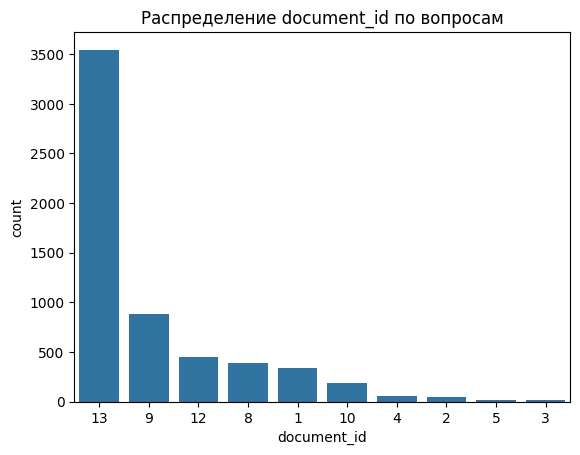

In [85]:
sns.countplot(data=qa_pairs_df, x='document_id', order=qa_pairs_df['document_id'].value_counts().index)
plt.title("Распределение document_id по вопросам")
plt.show()

✅ Средняя косинусная близость = $0.9070$ — это очень высокая степень релевантности.
Это означает:

Вопросы, помеченные document_id = $13$, действительно семантически похожи на chunk’и из документа $13$.

Никакой ошибки в логике привязки вопросов к документу нет.

Просто сам документ $13$ — это, судя по всему, ключевой, часто встречающийся и "широкий" по охвату знаний текст, возможно, он покрывает часто задаваемые темы

С document_id = 13 всё в порядке, фильтровать его искусственно — не нужно.

Возможно, стоит проанализировать его структуру и понять, можно ли его разбить лучше (более специфичные chunks).

Это может быть центральный справочник или раздел, и это нормально, если он выдаётся чаще.

In [86]:
pairs_df

,document_id,title
0,8,База знаний Point
1,10,Обучение WBPoint
2,9,WB Point NEWS
3,13,Вопрос-ответ
4,12,Портал обучения WBPortal
5,1,Оферта
6,5,Приложение к оферте о технических требованиях ...
7,4,Приложение к оферте о правилах оказания услуг
8,3,Приложение к оферте о брендировании
9,6,Приложение к оферте о программах реализации де...


В идеале, после того как мы нашли наиболее вероятный document_id, теперь мы хотим:

Найти наиболее релевантные chunk'и внутри этого документа.

Эти chunk'и затем можно использовать:

для ранжирования,

для группировки похожих вопросов,

для конкатенации и передачи в генератор (если мы хотим использовать LLM).

In [87]:
know_df

,id,chunk,document_id,part_id,tokens
0,1588,Оферта – условия настоящей оферты об оказании ...,1,1.0,"[оферта, –, условия, настоящей, оферты, об, ок..."
1,1589,Исполнитель – коммерческая организация или инд...,1,1.0,"[исполнитель, –, коммерческая, организация, ил..."
2,1590,Заказчик или Вайлдберриз - одно из перечисленн...,1,1.0,"[заказчик, или, вайлдберриз, -, одно, из, пере..."
3,1591,"Договор – договор об оказании услуг, заключенн...",1,1.0,"[договор, –, договор, об, оказании, услуг,, за..."
4,1592,Пункт выдачи заказов (ПВЗ) – нежилое помещение...,1,1.0,"[пункт, выдачи, заказов, (пвз), –, нежилое, по..."
...,...,...,...,...,...
928,1498,"Обязательно ли проверять соответствие, если мы...",13,0.0,"[обязательно, ли, проверять, соответствие,, ес..."
929,1499,В одну коробку можно класть НЕпереупакованые т...,13,0.0,"[в, одну, коробку, можно, класть, непереупаков..."
930,1586,Как переупаковывать верхнюю одежду <nt> Провер...,13,0.0,"[как, переупаковывать, верхнюю, одежду, <nt>, ..."
931,1587,"На товаре нет ни бирки, ни вшивных элементов п...",13,0.0,"[на, товаре, нет, ни, бирки,, ни, вшивных, эле..."


In [88]:
def find_top_chunks_for_question(question_embedding, document_id, k=3):
    # Фильтруем по нужному документу
    doc_chunks = know_df[know_df["document_id"] == document_id]

    # Берем эмбеддинги chunk'ов
    doc_chunk_embeddings = np.stack(doc_chunks["chunk_embedding"].values)

    # Считаем косинусную близость
    similarities = cosine_similarity(
        question_embedding.reshape(1, -1),
        doc_chunk_embeddings
    )[0]

    # Находим топ-k индексов
    top_k_indices = similarities.argsort()[-k:][::-1]
    top_k_chunks = doc_chunks.iloc[top_k_indices]
    top_k_scores = similarities[top_k_indices]

    return top_k_chunks, top_k_scores


In [89]:
qa_pairs_df.columns

Index(['id', 'question', 'answer', 'document_id'], dtype='object')

Добавим эмбеддинги.

In [90]:
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm import tqdm

# Загрузим подходящую модель (можно заменить на более сильную при необходимости)
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Вычислим эмбеддинги для всех вопросов
question_embeddings = model.encode(
    qa_pairs_df["question"].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True
)

# Сохраним в датафрейм
qa_pairs_df["question_embedding"] = list(question_embeddings)

Batches: 100%|██████████| 186/186 [00:01<00:00, 115.12it/s]


In [91]:
# Убедимся, что chunk — это строка
know_df["chunk"] = know_df["chunk"].astype(str)

# Получаем эмбеддинги chunk'ов
chunk_embeddings = model.encode(
    know_df["chunk"].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True
)

# Добавляем в know_df
know_df["chunk_embedding"] = list(chunk_embeddings)

Batches: 100%|██████████| 30/30 [00:00<00:00, 41.50it/s]


In [92]:
know_df

,id,chunk,document_id,part_id,tokens,chunk_embedding
0,1588,Оферта – условия настоящей оферты об оказании ...,1,1.0,"[оферта, –, условия, настоящей, оферты, об, ок...","[-0.15070373, -0.033534966, -0.23346983, -0.03..."
1,1589,Исполнитель – коммерческая организация или инд...,1,1.0,"[исполнитель, –, коммерческая, организация, ил...","[-0.12438974, 0.068778835, -0.15185212, 0.0181..."
2,1590,Заказчик или Вайлдберриз - одно из перечисленн...,1,1.0,"[заказчик, или, вайлдберриз, -, одно, из, пере...","[-0.08547285, -0.12832099, -0.23022991, -0.213..."
3,1591,"Договор – договор об оказании услуг, заключенн...",1,1.0,"[договор, –, договор, об, оказании, услуг,, за...","[-0.29506582, 0.1033227, -0.23617339, 0.024357..."
4,1592,Пункт выдачи заказов (ПВЗ) – нежилое помещение...,1,1.0,"[пункт, выдачи, заказов, (пвз), –, нежилое, по...","[-0.20754287, -0.07000118, -0.31811982, -0.167..."
...,...,...,...,...,...,...
928,1498,"Обязательно ли проверять соответствие, если мы...",13,0.0,"[обязательно, ли, проверять, соответствие,, ес...","[-0.019491637, -0.00032639384, -0.16699824, -0..."
929,1499,В одну коробку можно класть НЕпереупакованые т...,13,0.0,"[в, одну, коробку, можно, класть, непереупаков...","[-0.10606624, 0.045761265, -0.07954119, 0.0258..."
930,1586,Как переупаковывать верхнюю одежду <nt> Провер...,13,0.0,"[как, переупаковывать, верхнюю, одежду, <nt>, ...","[-0.1569297, 0.26502764, -0.060764387, -0.0560..."
931,1587,"На товаре нет ни бирки, ни вшивных элементов п...",13,0.0,"[на, товаре, нет, ни, бирки,, ни, вшивных, эле...","[-0.18488984, 0.11980706, 0.06960397, -0.01242..."


In [93]:
qa_pairs_df['question_embedding']

0       [-0.011771136, -0.06857245, 0.14497603, -0.237...
1       [0.0067431033, 0.12519442, -0.18108217, -0.059...
2       [0.6152139, 0.18303125, 0.14860691, -0.1039542...
3       [0.4830745, 0.13003084, -0.013704876, 0.043312...
4       [0.30947873, -0.095856346, -0.21742743, -0.165...
                              ...                        
5927    [-0.13749997, 0.0024908693, -0.026653105, 0.06...
5928    [-0.13712086, 0.19478013, 0.11977458, 0.014487...
5929    [0.17240293, 0.1861462, 0.06908095, 0.00081653...
5930    [0.1509067, 0.09520339, 0.06672767, -0.0427732...
5931    [-0.10499525, 0.17887068, -0.12259048, -0.0708...
Name: question_embedding, Length: 5932, dtype: object

In [94]:
top_chunks_list = []
top_scores_list = []

for i, row in qa_pairs_df.iterrows():
    q_emb = row["question_embedding"]
    doc_id = row["document_id"]

    top_chunks, top_scores = find_top_chunks_for_question(q_emb, doc_id, k=3)
    
    top_chunks_list.append(top_chunks["chunk"].tolist())
    top_scores_list.append(top_scores.tolist())

# Сохраняем в датафрейм
qa_pairs_df["top_chunks"] = top_chunks_list
qa_pairs_df["top_chunk_scores"] = top_scores_list


In [95]:
know_df.columns

Index(['id', 'chunk', 'document_id', 'part_id', 'tokens', 'chunk_embedding'], dtype='object')

In [96]:
# Считаем среднюю близость по каждому документу
doc_scores = qa_pairs_df.groupby("document_id")["top_chunk_scores"].apply(
    lambda scores_list: np.mean([score[0] for score in scores_list if len(score) > 0])
).sort_values(ascending=False)

print("Средняя косинусная близость по document_id:\n")
print(doc_scores)


Средняя косинусная близость по document_id:

document_id
13    0.600828
1     0.566504
9     0.549328
12    0.545087
8     0.537895
10    0.508264
4     0.508180
2     0.470368
3     0.468266
5     0.417493
Name: top_chunk_scores, dtype: float64


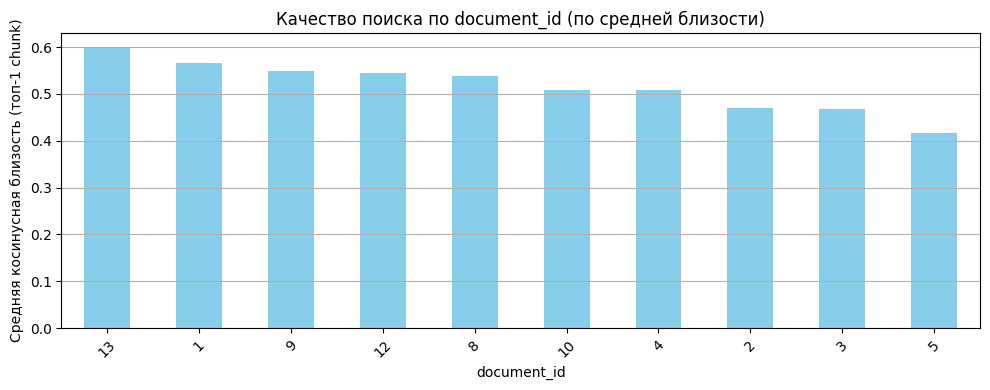

In [97]:
doc_scores.plot(kind="bar", figsize=(10, 4), color="skyblue")
plt.ylabel("Средняя косинусная близость (топ-1 chunk)")
plt.xlabel("document_id")
plt.title("Качество поиска по document_id (по средней близости)")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [98]:
# Пример с наименьшей близостью
qa_pairs_df["max_top_score"] = qa_pairs_df["top_chunk_scores"].apply(lambda x: max(x) if x else 0)
lowest_matches = qa_pairs_df.sort_values("max_top_score").head(5)

# Пример с самой высокой близостью
best_matches = qa_pairs_df.sort_values("max_top_score", ascending=False).head(5)

print("Примеры с плохой релевантностью:")
display(lowest_matches[["question", "answer", "top_chunks", "top_chunk_scores"]])

print("\nПримеры с высокой релевантностью:")
display(best_matches[["question", "answer", "top_chunks", "top_chunk_scores"]])


Примеры с плохой релевантностью:


,question,answer,top_chunks,top_chunk_scores
5305,Обнулилось приложение,Если у вас возникли проблемы обратитесь в чат ...,[Приложение к Оферте об оказании услуг по дост...,"[0.09408578276634216, 0.047455787658691406]"
5224,Отзыв 1 звезда чем грозит?,Рейтинг меняется в зависимости от оценок Клиен...,"[12. За нарушение срока внесения оплаты, преду...","[0.14254409074783325, 0.12456047534942627, 0.1..."
4104,Посторонние нитки вшитые в брюки. Считается бр...,"Список дефектов, которые необходимо отмечать к...",[1.3. Исполнитель вправе разместить на фасаде ...,"[0.16365885734558105, 0.1325940191745758, 0.12..."
1945,Царапины на одежде,"Список дефектов, которые необходимо отмечать к...",[Памятка по браку Учитывая изменения в регламе...,"[0.17341165244579315, 0.17341165244579315, 0.1..."
1378,К какой категории относится книга?,Книги относятся к категории невозвратных товаров,[Исправление инструкции по видам брака Обновле...,"[0.17639999091625214, 0.17168524861335754, 0.1..."



Примеры с высокой релевантностью:


,question,answer,top_chunks,top_chunk_scores
3421,Видеонаюблюдение,"Технические характеристики, предъявляемые к ка...","[Видеонаблюдение., В случае неисполнения или н...","[0.9704766273498535, 0.6391189098358154, 0.577..."
775,"Товар отмечен на возврат, клиент его забрал. К...",Возврат отменить невозможно,"[Товар отмечен на возврат, клиент его забрал. ...","[0.9560505151748657, 0.838853120803833, 0.8098..."
2405,Видеопрогулка,Видеопрогулку нужно загрузить в личном кабинет...,"[Видеонаблюдение., В случае неисполнения или н...","[0.9531311392784119, 0.5642606019973755, 0.549..."
4992,Входит ли инвентаризация в обязанности сотрудн...,"Да, инвентаризация входит в обязанности сотруд...",[Входит ли инвентаризация в обязанности сотруд...,"[0.9443659782409668, 0.713722288608551, 0.6168..."
5156,Возвращают ли деньги за брак?,"Да, если был выявлен брак, то деньги будут воз...","[Возвращают ли деньги за брак?<nt>Да, если был...","[0.9395542144775391, 0.7484170198440552, 0.719..."


Попробуем усилить модель.

In [99]:
model = SentenceTransformer('intfloat/e5-large-v2', device='cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\boris\anaconda3\envs\conda2025-2026\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\boris\.cache\huggingface\hub\models--intfloat--e5-large-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [100]:
qa_pairs_df.columns, know_df.columns

(Index(['id', 'question', 'answer', 'document_id', 'question_embedding',
        'top_chunks', 'top_chunk_scores', 'max_top_score'],
       dtype='object'),
 Index(['id', 'chunk', 'document_id', 'part_id', 'tokens', 'chunk_embedding'], dtype='object'))

In [101]:
# Убедись, что столбцы названы правильно
qa_pairs_df['question_embedding'] = qa_pairs_df['question'].apply(lambda q: model.encode(q, normalize_embeddings=True))
know_df['chunk_embedding'] = know_df['chunk'].apply(lambda c: model.encode(c, normalize_embeddings=True))

In [102]:
def find_top_chunks_for_question(question_embedding, document_id, k=3):
    # Фильтруем чанк по document_id
    doc_chunks = know_df[know_df["document_id"] == document_id]
    doc_embeddings = np.stack(doc_chunks["chunk_embedding"].values)

    # Считаем косинусную близость
    sims = cosine_similarity(question_embedding.reshape(1, -1), doc_embeddings)[0]
    top_k_idx = sims.argsort()[-k:][::-1]

    return doc_chunks.iloc[top_k_idx], sims[top_k_idx]

top_chunks_list = []
top_scores_list = []

for i, row in tqdm(qa_pairs_df.iterrows(), total=len(qa_pairs_df)):
    q_emb = row["question_embedding"]
    doc_id = row["document_id"]
    top_chunks, top_scores = find_top_chunks_for_question(q_emb, doc_id, k=3)

    top_chunks_list.append(top_chunks["chunk"].tolist())
    top_scores_list.append(top_scores.tolist())

qa_pairs_df["top_chunks"] = top_chunks_list
qa_pairs_df["top_scores"] = top_scores_list

100%|██████████| 5932/5932 [00:08<00:00, 684.52it/s]


In [103]:
# Загружаем reranker-модель
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')

def rerank(question, chunks):
    pairs = [(question, chunk) for chunk in chunks]
    scores = reranker.predict(pairs)
    return scores

qa_pairs_df["reranked_scores"] = qa_pairs_df.apply(
    lambda row: rerank(row["question"], row["top_chunks"]), axis=1
)

# (опционально) Можно сохранить лучший чанк после reranking:
qa_pairs_df["best_chunk_after_rerank"] = qa_pairs_df["reranked_scores"].apply(
    lambda scores: scores[np.argmax(scores)]
)


In [104]:
def compare_ranking(row):
    # Получаем индексы максимальных оценок
    top_score_idx = np.argmax(row["top_scores"])
    reranked_idx = np.argmax(row["reranked_scores"])

    return top_score_idx == reranked_idx

# Столбец: совпадают ли топ-1 чанк до и после reranking
qa_pairs_df["same_top_chunk"] = qa_pairs_df.apply(compare_ranking, axis=1)

# Статистика
match_ratio = qa_pairs_df["same_top_chunk"].mean()
print(f"Доля совпадений топ-1 чанка до и после reranking: {match_ratio:.2%}")


Доля совпадений топ-1 чанка до и после reranking: 39.67%


In [105]:
# Средний score до reranking
mean_top_score = qa_pairs_df["top_scores"].apply(lambda scores: max(scores)).mean()

# Средний reranked score
mean_rerank_score = qa_pairs_df["reranked_scores"].apply(lambda scores: max(scores)).mean()

print(f"Средний максимальный top_score (до reranking): {mean_top_score:.4f}")
print(f"Средний максимальный reranked_score (после reranking): {mean_rerank_score:.4f}")


Средний максимальный top_score (до reranking): 0.8473
Средний максимальный reranked_score (после reranking): 8.4980


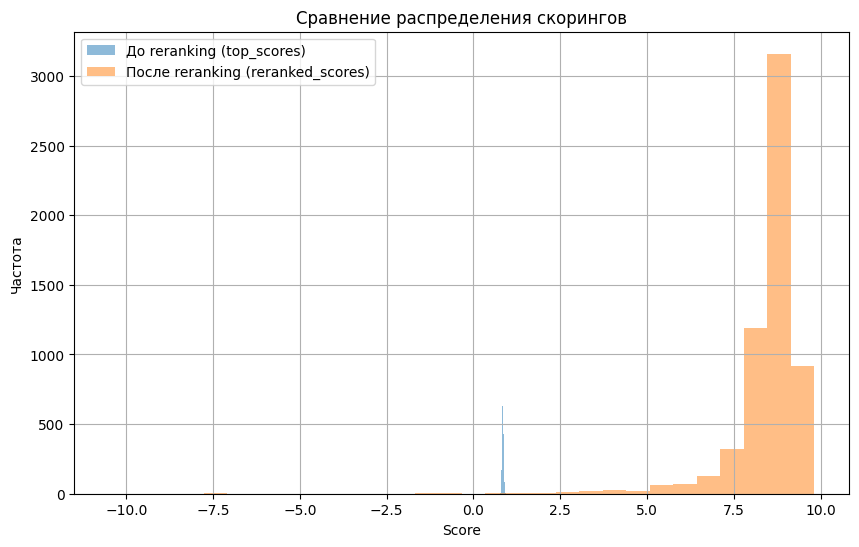

In [106]:
top = qa_pairs_df["top_scores"].apply(lambda s: max(s))
reranked = qa_pairs_df["reranked_scores"].apply(lambda s: max(s))

plt.figure(figsize=(10, 6))
plt.hist(top, bins=30, alpha=0.5, label="До reranking (top_scores)")
plt.hist(reranked, bins=30, alpha=0.5, label="После reranking (reranked_scores)")
plt.xlabel("Score")
plt.ylabel("Частота")
plt.title("Сравнение распределения скорингов")
plt.legend()
plt.grid(True)
plt.show()


In [107]:
def find_best_chunk_index(chunks, answer):
    # Простое приближение: ищем, в каком чанке содержится текст ответа
    for idx, chunk in enumerate(chunks):
        if answer.lower() in chunk.lower():
            return idx
    return -1  # если не найдено

def reranker_stats(row):
    correct_idx = find_best_chunk_index(row["top_chunks"], row["answer"])
    
    if correct_idx == -1:
        return pd.Series({"correct_found": False, "orig_rank": -1, "new_rank": -1})
    
    # До reranking: сортируем по top_scores (убывание)
    orig_ranking = np.argsort(row["top_scores"])[::-1]
    orig_rank = np.where(orig_ranking == correct_idx)[0][0] + 1  # позиция от 1

    # После reranking: сортируем по reranked_scores (убывание)
    new_ranking = np.argsort(row["reranked_scores"])[::-1]
    new_rank = np.where(new_ranking == correct_idx)[0][0] + 1

    return pd.Series({
        "correct_found": True,
        "orig_rank": orig_rank,
        "new_rank": new_rank
    })

# Применим ко всем строкам
qa_pairs_df[["correct_found", "orig_rank", "new_rank"]] = qa_pairs_df.apply(reranker_stats, axis=1)

In [108]:
# Отфильтруем строки, где правильный chunk найден
found_df = qa_pairs_df[qa_pairs_df["correct_found"]]

# Сколько таких случаев
print(f"✅ Правильный chunk найден в {len(found_df)} из {len(qa_pairs_df)} примеров ({len(found_df)/len(qa_pairs_df):.2%})")

# В скольких случаях reranker улучшил позицию
improved = (found_df["new_rank"] < found_df["orig_rank"]).sum()
worsened = (found_df["new_rank"] > found_df["orig_rank"]).sum()
same = (found_df["new_rank"] == found_df["orig_rank"]).sum()

print(f"📈 Reranker улучшил позицию в {improved} случаях ({improved/len(found_df):.2%})")
print(f"📉 Reranker ухудшил в {worsened} случаях ({worsened/len(found_df):.2%})")
print(f"🤝 Не изменил позицию в {same} случаях ({same/len(found_df):.2%})")

# Средняя позиция до/после
print(f"📊 Средняя позиция правильного чанка ДО: {found_df['orig_rank'].mean():.2f}")
print(f"📊 Средняя позиция правильного чанка ПОСЛЕ: {found_df['new_rank'].mean():.2f}")

✅ Правильный chunk найден в 167 из 5932 примеров (2.82%)
📈 Reranker улучшил позицию в 36 случаях (21.56%)
📉 Reranker ухудшил в 32 случаях (19.16%)
🤝 Не изменил позицию в 99 случаях (59.28%)
📊 Средняя позиция правильного чанка ДО: 1.55
📊 Средняя позиция правильного чанка ПОСЛЕ: 1.51


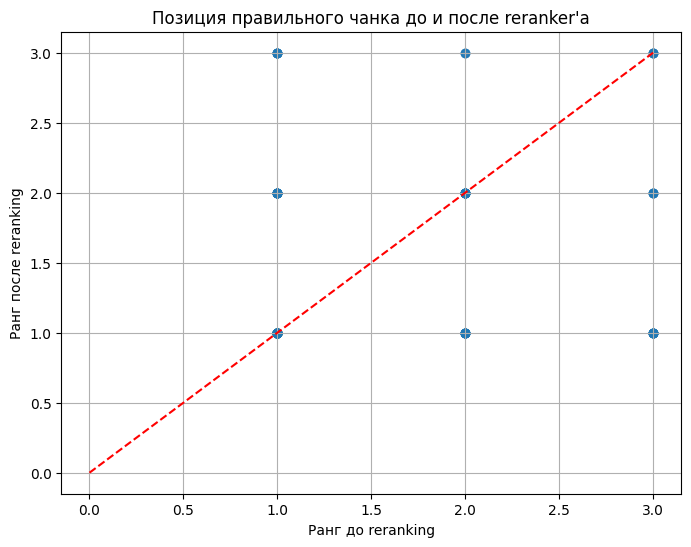

In [109]:
plt.figure(figsize=(8, 6))
plt.scatter(found_df["orig_rank"], found_df["new_rank"], alpha=0.5)
plt.plot([0, max(found_df["orig_rank"].max(), found_df["new_rank"].max())], 
         [0, max(found_df["orig_rank"].max(), found_df["new_rank"].max())], 'r--')
plt.xlabel("Ранг до reranking")
plt.ylabel("Ранг после reranking")
plt.title("Позиция правильного чанка до и после reranker'а")
plt.grid(True)
plt.show()


In [110]:
recall_at_1 = (found_df["new_rank"] == 1).mean()
print(f"🎯 Recall@1 (правильный chunk стал топ-1): {recall_at_1:.2%}")


🎯 Recall@1 (правильный chunk стал топ-1): 62.28%


In [113]:
qa_pairs_df.columns

Index(['id', 'question', 'answer', 'document_id', 'question_embedding',
       'top_chunks', 'top_chunk_scores', 'max_top_score', 'top_scores',
       'reranked_scores', 'best_chunk_after_rerank', 'same_top_chunk',
       'correct_found', 'orig_rank', 'new_rank', 'hit@3_top', 'rr_top'],
      dtype='object')

In [114]:
def reranked_chunks_from_scores(row):
    scores = row["reranked_scores"]
    chunks = row["top_chunks"]
    if len(scores) != len(chunks):
        return []
    ranked = sorted(zip(chunks, scores), key=lambda x: x[1], reverse=True)
    return [chunk for chunk, _ in ranked]

qa_pairs_df["reranked_chunks"] = qa_pairs_df.apply(reranked_chunks_from_scores, axis=1)

In [115]:
from difflib import SequenceMatcher

def reciprocal_rank(answer, chunks, threshold=0.8):
    for i, chunk in enumerate(chunks):
        if SequenceMatcher(None, answer.lower(), chunk.lower()).ratio() > threshold:
            return 1 / (i + 1)
    return 0.0

qa_pairs_df["rr_top"] = qa_pairs_df.apply(
    lambda row: reciprocal_rank(row["answer"], row["top_chunks"]), axis=1
)
qa_pairs_df["rr_reranked"] = qa_pairs_df.apply(
    lambda row: reciprocal_rank(row["answer"], row["reranked_chunks"]), axis=1
)

mrr_top = qa_pairs_df["rr_top"].mean()
mrr_reranked = qa_pairs_df["rr_reranked"].mean()

print(f"🎯 MRR@3 (до reranker): {mrr_top:.3f}")
print(f"🚀 MRR@3 (после reranker): {mrr_reranked:.3f}")

🎯 MRR@3 (до reranker): 0.030
🚀 MRR@3 (после reranker): 0.032


In [117]:
qa_pairs_df["rank_change"] = qa_pairs_df["orig_rank"] - qa_pairs_df["new_rank"]
improved = (qa_pairs_df["rank_change"] > 0).mean()
worsened = (qa_pairs_df["rank_change"] < 0).mean()
same = (qa_pairs_df["rank_change"] == 0).mean()

print(f"🔼 Улучшилось: {improved:.2%}")
print(f"🔽 Ухудшилось: {worsened:.2%}")
print(f"➖ Без изменений: {same:.2%}")


🔼 Улучшилось: 0.61%
🔽 Ухудшилось: 0.54%
➖ Без изменений: 98.85%


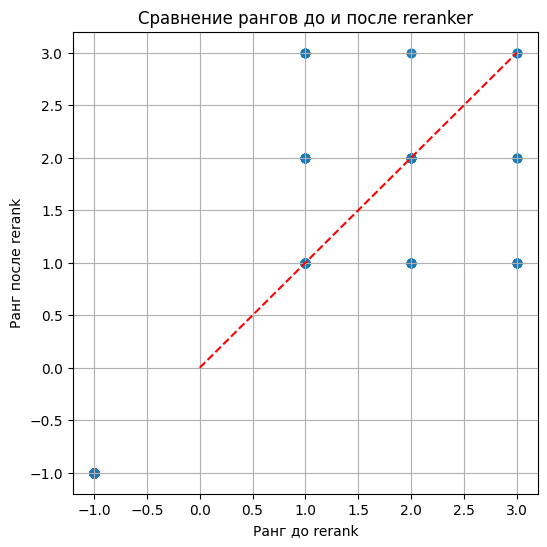

In [116]:
plt.figure(figsize=(6, 6))
plt.scatter(qa_pairs_df["orig_rank"], qa_pairs_df["new_rank"], alpha=0.5)
plt.xlabel("Ранг до rerank")
plt.ylabel("Ранг после rerank")
plt.title("Сравнение рангов до и после reranker")
plt.grid(True)
plt.plot([0, 3], [0, 3], color="red", linestyle="--")
plt.show()


In [118]:
from difflib import SequenceMatcher

def recall_at_k(answer, chunks, k=3, threshold=0.8):
    for chunk in chunks[:k]:
        if SequenceMatcher(None, answer.lower(), chunk.lower()).ratio() > threshold:
            return 1
    return 0

qa_pairs_df["recall@3"] = qa_pairs_df.apply(
    lambda row: recall_at_k(row["answer"], row["top_chunks"], k=3), axis=1
)
qa_pairs_df["recall@5"] = qa_pairs_df.apply(
    lambda row: recall_at_k(row["answer"], row["top_chunks"], k=5), axis=1
)

print("📊 Recall@3:", qa_pairs_df["recall@3"].mean())
print("📊 Recall@5:", qa_pairs_df["recall@5"].mean())


📊 Recall@3: 0.04231287929871881
📊 Recall@5: 0.04231287929871881


In [119]:
missed_cases = qa_pairs_df[qa_pairs_df["recall@5"] == 0][["question", "answer", "top_chunks"]].sample(5, random_state=42)
for _, row in missed_cases.iterrows():
    print("🔹 Question:", row["question"])
    print("✅ Answer:", row["answer"])
    print("❌ Top Chunks:")
    for i, chunk in enumerate(row["top_chunks"]):
        print(f"  {i+1}. {chunk}")
    print("-" * 80)


🔹 Question: Что такое тайм-код?
✅ Answer: Тайм-код - это промежуток времени на видео, который запрашивают у вас
Более подробно про открытия пунктов выдачи вы можете ознакомиться по ссылке https://point-promo.wb.ru
❌ Top Chunks:
  1. Что означает ошибка Превышено количество попыток ввода кода?<nt>При множественных попытках провести выдачу при неверном коде, система блокирует выдачу, во избежание проведения выдачи без ведома и согласия клиента
  2. Как пополнить баланс ПВЗ? <nt> В разделе «Баланс» в правом верхнем углу отображается QR-код для оплаты задолженности, а также кнопка «Показать реквизиты».
  3. Почему такая мотивация/начисление/удержание/доплата/штраф за рейтинг? <nt>Доплата/удержание за рейтинг рассчитываются за предыдущую дату. Формула для расчета указана в разделе "Рейтинг".
--------------------------------------------------------------------------------
🔹 Question: Человек ушёл, а карта заблокирована
✅ Answer: Если у вас не проходит платёж по каким-либо причинам и Вы сдела

🔍 Проблема №1: Правильный ответ даже близко не попадает в Top Chunks
Например:

💬 Вопрос: Что такое тайм-код?
✅ Ответ:

Тайм-код — это промежуток времени на видео...

❌ Топ-чанки:

Про ошибки с кодом, пополнение баланса, штрафы и рейтинг — ничего общего с видео и тайм-кодами.

👉 Это говорит о провале в поиске релевантных чанков — не просто промах на пару мест, а полное отсутствие семантической связи.

🔍 Проблема №2: Все 3 Top Chunks часто — почти идентичные
Пример:

Вопрос: Возврат просит номер телефона клиента
Все 3 чанка — про "Компания не разглашает номер клиента".
Однако:

Они формально релевантны, но не содержат инструкции про "проводить возврат в присутствии клиента" (то есть не объясняют, что делать).

Это тонкая, но важная грань между:

Семантически близким содержанием,

и реально полезным ответом.

🔍 Проблема №3: Ответ есть в базе, но не в top_chunks
Пример:

Вопрос: Клиент ушёл, а карта заблокирована

В ответе явно упоминается сценарий, связанный с кнопкой «Проблема с оплатой».
Но в топ чанках этого даже близко нет — хотя, вероятно, этот фрагмент есть в базе, просто находится ниже топ-3 или топ-5.

In [120]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")  # легкая и точная

def compute_correct_found_semantic(row, model, threshold=0.75):
    answer = row['answer']
    chunks = row['top_chunks']
    
    if not chunks:
        return False
    
    # Вектор ответа
    answer_embedding = model.encode(answer, convert_to_tensor=True)

    # Вектор чанков
    chunk_embeddings = model.encode(chunks, convert_to_tensor=True)

    # Косинусное сходство
    cosine_scores = util.cos_sim(answer_embedding, chunk_embeddings)[0]

    # Находим лучший скор
    best_score = torch.max(cosine_scores).item()

    return best_score >= threshold


In [122]:
qa_pairs_df

,id,question,answer,document_id,question_embedding,top_chunks,top_chunk_scores,max_top_score,top_scores,reranked_scores,...,correct_found,orig_rank,new_rank,hit@3_top,rr_top,reranked_chunks,rr_reranked,rank_change,recall@3,recall@5
0,2,Как вернуть на экран баланс?,"В полной версии сайта слева, в разделе ""Аналит...",13,"[0.015108442, -0.037911694, 0.038659446, -0.00...",[Как пополнить баланс ПВЗ? <nt> В разделе «Бал...,"[0.634728193283081, 0.3842088580131531, 0.3809...",0.634728,"[0.8555493354797363, 0.8311464786529541, 0.815...","[9.057553, 8.5137615, 8.988332]",...,False,-1,-1,False,0.0,[Как пополнить баланс ПВЗ? <nt> В разделе «Бал...,0.0,0,0,0
1,3,Какой договор заключается?,"1. Оферта – это самый важный документ, описыва...",13,"[0.014312611, -0.049706742, 0.038142256, -0.00...",[В какой промежуток проводится инвентаризация?...,"[0.4622058868408203, 0.3761812448501587, 0.365...",0.462206,"[0.8105329871177673, 0.8095848560333252, 0.805...","[8.656124, 8.673649, 7.9618826]",...,False,-1,-1,False,0.0,"[Что делать, если товар забрали который был по...",0.0,0,0,0
2,5,Какая минимальная площадь помещения?,"Площадь помещения, соответствующая требованиям...",13,"[0.023393456, -0.072257705, 0.03145455, -0.017...","[Все пакеты платные?<nt>Да, все пакеты платные...","[0.45124801993370056, 0.3960685431957245, 0.39...",0.451248,"[0.8232156038284302, 0.8138229250907898, 0.811...","[2.61481, 8.166659, 8.191662]",...,False,-1,-1,False,0.0,[Мотивация приемки <nt> Общие правила:\n- плю...,0.0,0,0,0
3,6,Какие требования к площади помещения?,"Площадь помещения, соответствующая требованиям...",9,"[0.0069673327, -0.0476917, 0.014618742, -0.024...",[Сезон высоких продаж. Увеличение площади ПВЗ ...,"[0.5572711229324341, 0.508520245552063, 0.4949...",0.557271,"[0.8146144151687622, 0.8084433078765869, 0.808...","[8.2389145, 8.247194, 8.562499]",...,False,-1,-1,False,0.0,[23 февраля мы отмечаем День защитника Отечест...,0.0,0,0,0
4,9,Как зарегистрироваться?,Для открытия пункта WB необходимо выполнить сл...,13,"[0.024152525, -0.030426366, 0.041954484, 0.001...",[Как повысить рейтинг? <nt> Необходимо проанал...,"[0.47087666392326355, 0.4476844370365143, 0.44...",0.470877,"[0.8100472688674927, 0.8047769665718079, 0.803...","[8.667063, 8.624613, 7.7868567]",...,False,-1,-1,False,0.0,[Как повысить рейтинг? <nt> Необходимо проанал...,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5927,12994,Как найти товар про баркоду?,Функционал просмотра истории товара доступен в...,13,"[0.03549825, -0.04260225, 0.045817424, -0.0026...","[Если на товаре нет опознавательных знаков, но...","[0.6316690444946289, 0.45481204986572266, 0.44...",0.631669,"[0.8609256744384766, 0.8541194200515747, 0.852...","[8.97884, 8.757956, 9.03544]",...,False,-1,-1,False,0.0,[Как принять по баркоду?<nt>Если при приемке т...,0.0,0,0,0
5928,13000,Тональный крем отказ на ПВЗ,В случае обнаружения брака/несоответствия при ...,13,"[0.026720768, -0.044709403, 0.025519297, -0.00...",[Сколько хранится товар в ПВЗ?<nt>Товар на ПВЗ...,"[0.4237315356731415, 0.3920857310295105, 0.363...",0.423732,"[0.8404949903488159, 0.833633542060852, 0.8328...","[9.105631, 9.043896, 8.91169]",...,False,-1,-1,False,0.0,[Сколько хранится товар в ПВЗ?<nt>Товар на ПВЗ...,0.0,0,0,0
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр...",8,"[0.04373073, -0.026351398, 0.03722353, 0.00039...",[Правила выдачи косметики\n\n1. Товар необходи...,"[0.40863335132598877, 0.40261760354042053, 0.3...",0.408633,"[0.8423250913619995, 0.8412078619003296, 0.839...","[8.111584, 7.9498625, 8.148718]",...,False,-1,-1,False,0.0,[Основная работа менеджеров: \n• принять товар...,0.0,0,0,0
5930,13006,Можно ли отказаться в момент получения от колг...,"Если можно вскрыть заводскую упаковку товара, ...",13,"[0.014854374, -0.04458224, 0.026413957, 0.0013...",[Можно ли использовать курьерские пакеты други...,"[0.6045709848403931, 0.574953615665

In [123]:
qa_pairs_df['correct_found_semantic'] = qa_pairs_df.apply(lambda row: compute_correct_found_semantic(row, model), axis=1)

In [124]:
recall_at_3_semantic = qa_pairs_df['correct_found_semantic'].mean()
print(f"📊 Semantic Recall@3: {recall_at_3_semantic:.4f}")

📊 Semantic Recall@3: 0.2507


In [155]:
know_df

,id,chunk,document_id,part_id
0,1588,Оферта – условия настоящей оферты об оказании ...,1,1.0
1,1589,Исполнитель – коммерческая организация или инд...,1,1.0
2,1590,Заказчик или Вайлдберриз - одно из перечисленн...,1,1.0
3,1591,"Договор – договор об оказании услуг, заключенн...",1,1.0
4,1592,Пункт выдачи заказов (ПВЗ) – нежилое помещение...,1,1.0
...,...,...,...,...
928,1498,"Обязательно ли проверять соответствие, если мы...",13,0.0
929,1499,В одну коробку можно класть НЕпереупакованые т...,13,0.0
930,1586,Как переупаковывать верхнюю одежду <nt> Провер...,13,0.0
931,1587,"На товаре нет ни бирки, ни вшивных элементов п...",13,0.0


#### 📐 Архитектура Hybrid Retrieval

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Все тексты chunk'ов
chunk_texts = know_df['chunk'].tolist()
chunk_ids = know_df['document_id'].tolist()

# 2. Векторизуем с помощью TfidfVectorizer (BM25-лайт)
vectorizer = TfidfVectorizer()
bm25_matrix = vectorizer.fit_transform(chunk_texts)

In [157]:
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(chunk_texts, convert_to_tensor=True)

In [158]:
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import util
import numpy as np

def hybrid_retrieve(query, top_k=5, alpha=0.5):
    # BM25
    query_bm25 = vectorizer.transform([query])
    bm25_scores = (bm25_matrix @ query_bm25.T).toarray().squeeze()

    # Dense
    query_emb = model.encode(query, convert_to_tensor=True)
    dense_scores = util.cos_sim(query_emb, chunk_embeddings)[0].cpu().numpy()

    # Нормализация
    scaler = MinMaxScaler()
    bm25_scores_norm = scaler.fit_transform(bm25_scores.reshape(-1, 1)).squeeze()
    dense_scores_norm = scaler.fit_transform(dense_scores.reshape(-1, 1)).squeeze()

    # Гибридный скор
    hybrid_scores = alpha * bm25_scores_norm + (1 - alpha) * dense_scores_norm

    # Top-k индексы
    top_indices = np.argsort(hybrid_scores)[::-1][:top_k]
    
    results = [{'chunk_id': chunk_ids[i], 'score': hybrid_scores[i], 'chunk': chunk_texts[i]} for i in top_indices]
    return results

In [159]:
top_k = 5
alpha = 0.5

def get_top_chunks(row):
    return hybrid_retrieve(row['question'], top_k=top_k, alpha=alpha)

qa_pairs_df['top_chunks'] = qa_pairs_df.apply(get_top_chunks, axis=1)

In [160]:
def compute_semantic_similarity(answer, chunks):
    answer_emb = model.encode(answer, convert_to_tensor=True)
    similarities = []
    for chunk in chunks:
        chunk_emb = model.encode(chunk['chunk'], convert_to_tensor=True)
        sim_score = util.cos_sim(answer_emb, chunk_emb).item()
        chunk['semantic_sim'] = sim_score
        similarities.append(sim_score)
    return chunks

In [161]:
qa_pairs_df['top_chunks'] = qa_pairs_df.apply(
    lambda row: compute_semantic_similarity(row['answer'], row['top_chunks']),
    axis=1
)

In [162]:
def semantic_recall_at_k(chunks, threshold=0.75):
    for chunk in chunks:
        if chunk['semantic_sim'] >= threshold:
            return 1
    return 0

qa_pairs_df['semantic_recall@k'] = qa_pairs_df['top_chunks'].apply(
    lambda chunks: semantic_recall_at_k(chunks, threshold=0.75)
)

In [163]:
def rerank_with_semantic_score(chunks, beta=0.5):
    for chunk in chunks:
        chunk['final_score'] = beta * chunk['score'] + (1 - beta) * chunk['semantic_sim']
    chunks = sorted(chunks, key=lambda x: x['final_score'], reverse=True)
    return chunks

qa_pairs_df['top_chunks_reranked'] = qa_pairs_df['top_chunks'].apply(
    lambda chunks: rerank_with_semantic_score(chunks, beta=0.5)
)

In [164]:
semantic_recall_score = qa_pairs_df['semantic_recall@k'].mean()
print(f"Semantic Recall@{top_k}: {semantic_recall_score:.4f}")

Semantic Recall@5: 0.2257


In [165]:
def is_relevant(chunk, threshold=0.75):
    return chunk['semantic_sim'] >= threshold

def reciprocal_rank(chunks, threshold=0.75):
    for rank, chunk in enumerate(chunks, start=1):
        if is_relevant(chunk, threshold):
            return 1.0 / rank
    return 0.0

qa_pairs_df['MRR@5'] = qa_pairs_df['top_chunks_reranked'].apply(
    lambda chunks: reciprocal_rank(chunks[:5])
)


mrr_score = qa_pairs_df['MRR@5'].mean()
print(f"MRR@5: {mrr_score:.4f}")


MRR@5: 0.2139


### Пайплайн предобработки и поиска

In [14]:
# Предобработка текста
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.split()

# МОдель гибридного ретривера-поисковика
class HybridRetrievalModel:
    def __init__(self, top_k=10, model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"):
        self.top_k = top_k
        self.model = SentenceTransformer(model_name)
        self.bm25 = None
        self.corpus_embeddings = None
        self.doc_ids = None
        self.train_texts = None

    def prepare(self, qa_df, know_df=None, doc_model_name=None):
        """
        Подготовка корпуса для BM25 и SBERT-поиска.
        Если в `qa_df` нет 'document_id', он будет назначен на основе косинусной близости с `know_df`.

        Parameters:
        - qa_df: DataFrame с колонками ['question', 'answer', 'document_id' (опц.)]
        - know_df: DataFrame с колонками ['document_id', 'chunk'] — используется для автосопоставления document_id
        - doc_model_name: имя модели SentenceTransformer для поиска ближайшего документа (если используется know_df)
        """
        import torch
        from sentence_transformers.util import cos_sim
        
        if "document_id" not in qa_df.columns or qa_df["document_id"].isna().any():
            assert know_df is not None, "Для сопоставления document_id нужно передать know_df"

            print("🧠 Генерируем document_id по ближайшему контексту...")

            # Собираем полный текст по document_id
            doc_texts = know_df.groupby("document_id")["chunk"].apply(lambda x: " ".join(x)).to_dict()
            doc_ids = list(doc_texts.keys())
            doc_corpus = list(doc_texts.values())

            # Загружаем SentenceTransformer
            if doc_model_name is None:
                doc_model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
            doc_model = SentenceTransformer(doc_model_name, device="cuda" if torch.cuda.is_available() else "cpu")

            doc_embeddings = doc_model.encode(doc_corpus, convert_to_tensor=True, show_progress_bar=True)
            questions = qa_df["question"].fillna("").tolist()
            question_embeddings = doc_model.encode(questions, convert_to_tensor=True, show_progress_bar=True)

            cos_scores = cos_sim(question_embeddings, doc_embeddings)
            best_doc_indices = torch.argmax(cos_scores, dim=1).tolist()
            qa_df["document_id"] = [doc_ids[i] for i in best_doc_indices]

        # Далее по стандарту: формируем тексты, токенизируем, строим BM25 и эмбеддинги
        qa_df = qa_df.dropna(subset=["question", "answer", "document_id"]).reset_index(drop=True)
        self.train_texts = (qa_df["question"] + " " + qa_df["answer"]).astype(str).tolist()
        self.tokenized_corpus = [self.preprocess(text) for text in self.train_texts]

        self.bm25 = BM25Okapi(self.tokenized_corpus)
        self.corpus_embeddings = self.model.encode(self.train_texts, convert_to_numpy=True, normalize_embeddings=True)
        self.doc_ids = qa_df["document_id"].tolist()


    def search(self, query):
        if self.bm25 is None or self.corpus_embeddings is None:
            raise ValueError("Модель не обучена. Вызовите .prepare(df) сначала.")

        query_tokens = preprocess(query)
        bm25_scores = self.bm25.get_scores(query_tokens)
        top_indices = np.argsort(bm25_scores)[-self.top_k:][::-1]

        # Эмбеддинг запроса
        query_emb = self.model.encode(query, convert_to_numpy=True).reshape(1, -1)

        # Косинусное сходство
        candidate_embs = self.corpus_embeddings[top_indices]
        sims = cosine_similarity(query_emb, candidate_embs)[0]

        best_idx = top_indices[np.argmax(sims)]
        return self.doc_ids[best_idx]
    

# Валидация
def evaluate_hybrid_model(qa_df, test_size=0.2, top_k=10):
    train_df, test_df = train_test_split(qa_df, test_size=test_size, random_state=42)

    model = HybridRetrievalModel(top_k=top_k)
    model.prepare(train_df)

    correct = 0
    total = len(test_df)

    for _, row in tqdm(test_df.iterrows(), total=total):
        pred = model.search(row["question"])
        if str(pred) == str(row["document_id"]):
            correct += 1

    accuracy = correct / total
    print(f"📌 Точность гибридного поиска: {accuracy:.2%}")
    return accuracy


In [88]:
pairs_df

,document_id,title
0,8,База знаний Point
1,10,Обучение WBPoint
2,9,WB Point NEWS
3,13,Вопрос-ответ
4,12,Портал обучения WBPortal
5,1,Оферта
6,5,Приложение к оферте о технических требованиях ...
7,4,Приложение к оферте о правилах оказания услуг
8,3,Приложение к оферте о брендировании
9,6,Приложение к оферте о программах реализации де...


In [89]:
know_df

,id,chunk,document_id,part_id
0,1588,Оферта – условия настоящей оферты об оказании ...,1,1.0
1,1589,Исполнитель – коммерческая организация или инд...,1,1.0
2,1590,Заказчик или Вайлдберриз - одно из перечисленн...,1,1.0
3,1591,"Договор – договор об оказании услуг, заключенн...",1,1.0
4,1592,Пункт выдачи заказов (ПВЗ) – нежилое помещение...,1,1.0
...,...,...,...,...
928,1498,"Обязательно ли проверять соответствие, если мы...",13,0.0
929,1499,В одну коробку можно класть НЕпереупакованые т...,13,0.0
930,1586,Как переупаковывать верхнюю одежду <nt> Провер...,13,0.0
931,1587,"На товаре нет ни бирки, ни вшивных элементов п...",13,0.0


In [90]:
qa_pairs_df

,id,question,answer
0,2,Как вернуть на экран баланс?,"В полной версии сайта слева, в разделе ""Аналит..."
1,3,Какой договор заключается?,"1. Оферта – это самый важный документ, описыва..."
2,5,Какая минимальная площадь помещения?,"Площадь помещения, соответствующая требованиям..."
3,6,Какие требования к площади помещения?,"Площадь помещения, соответствующая требованиям..."
4,9,Как зарегистрироваться?,Для открытия пункта WB необходимо выполнить сл...
...,...,...,...
5927,12994,Как найти товар про баркоду?,Функционал просмотра истории товара доступен в...
5928,13000,Тональный крем отказ на ПВЗ,В случае обнаружения брака/несоответствия при ...
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр..."
5930,13006,Можно ли отказаться в момент получения от колг...,"Если можно вскрыть заводскую упаковку товара, ..."


In [40]:
# Объединяем чанки в один текст на каждый документ
doc_texts = know_df.groupby("document_id")["chunk"].apply(lambda x: " ".join(x)).to_dict()
doc_ids = list(doc_texts.keys())
doc_corpus = list(doc_texts.values())

# Загружаем модель эмбеддингов
model = SentenceTransformer("ai-forever/sbert_large_mt_nlu_ru", device='cuda') 

# Векторизуем документы
print("Векторизация документов...")
doc_embeddings = model.encode(doc_corpus, convert_to_tensor=True, show_progress_bar=True)

# Векторизуем вопросы
print("Векторизация вопросов...")
questions = qa_pairs_df["question"].fillna("").tolist()
question_embeddings = model.encode(questions, convert_to_tensor=True, show_progress_bar=True)

# Считаем cosine similarity
print("Поиск наиболее близких документов...")
cos_scores = util.cos_sim(question_embeddings, doc_embeddings)  # [N_questions x N_docs]

# Назначаем наиболее похожий document_id каждому вопросу
best_doc_indices = torch.argmax(cos_scores, dim=1).tolist()
qa_pairs_df["document_id"] = [doc_ids[i] for i in best_doc_indices]

# Добавим readable title (опционально)
doc_id_to_title = dict(zip(pairs_df["document_id"], pairs_df["title"]))
qa_pairs_df["document_title"] = qa_pairs_df["document_id"].map(doc_id_to_title)

Векторизация документов...


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Векторизация вопросов...


Batches: 100%|██████████| 186/186 [00:05<00:00, 36.62it/s]

Поиск наиболее близких документов...


In [41]:
qa_pairs_df

,id,question,answer,document_id,document_title
0,2,Как вернуть на экран баланс?,"В полной версии сайта слева, в разделе ""Аналит...",13,Вопрос-ответ
1,3,Какой договор заключается?,"1. Оферта – это самый важный документ, описыва...",1,Оферта
2,5,Какая минимальная площадь помещения?,"Площадь помещения, соответствующая требованиям...",3,Приложение к оферте о брендировании
3,6,Какие требования к площади помещения?,"Площадь помещения, соответствующая требованиям...",3,Приложение к оферте о брендировании
4,9,Как зарегистрироваться?,Для открытия пункта WB необходимо выполнить сл...,13,Вопрос-ответ
...,...,...,...,...,...
5927,12994,Как найти товар про баркоду?,Функционал просмотра истории товара доступен в...,13,Вопрос-ответ
5928,13000,Тональный крем отказ на ПВЗ,В случае обнаружения брака/несоответствия при ...,3,Приложение к оферте о брендировании
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр...",3,Приложение к оферте о брендировании
5930,13006,Можно ли отказаться в момент получения от колг...,"Если можно вскрыть заводскую упаковку товара, ...",13,Вопрос-ответ


In [42]:
# Посмотрим на то, как были распределены чанки
qa_pairs_df["similarity_score"] = torch.max(cos_scores, dim=1).values.cpu().numpy()

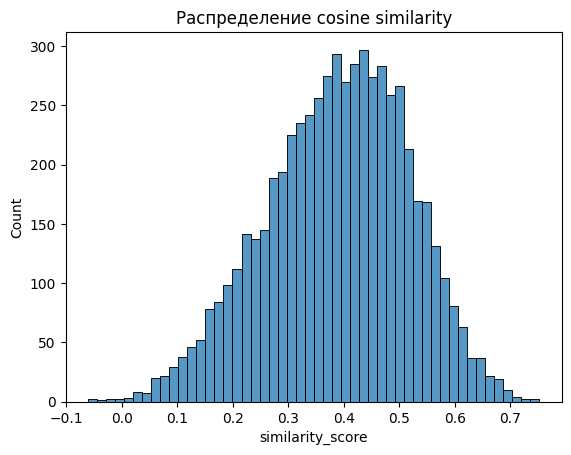

In [43]:
sns.histplot(qa_pairs_df["similarity_score"], bins=50)
plt.title("Распределение cosine similarity")
plt.show()

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

# На уровне категорий
for title in qa_pairs_df["document_title"].unique():
    subset = qa_pairs_df[qa_pairs_df["document_title"] == title]
    vect = TfidfVectorizer(max_features=10)
    tfidf = vect.fit_transform(subset["question"] + " " + subset["answer"])
    print(f"\n📄 Топ слова для категории: {title}")
    print(vect.get_feature_names_out())


📄 Топ слова для категории: Вопрос-ответ
['если' 'как' 'на' 'не' 'по' 'при' 'то' 'товар' 'товара' 'шк']

📄 Топ слова для категории: Оферта
['https' 'point' 'ru' 'wb' 'вы' 'для' 'если' 'на' 'пвз' 'по']

📄 Топ слова для категории: Приложение к оферте о брендировании
['https' 'point' 'ru' 'wb' 'вы' 'выдачи' 'на' 'не' 'пвз' 'по']

📄 Топ слова для категории: Приложение к оферте об условиях приобретения вспомогательных товаров
['если' 'за' 'на' 'не' 'пвз' 'по' 'при' 'то' 'товар' 'товара']

📄 Топ слова для категории: База знаний Point
['https' 'для' 'если' 'на' 'не' 'пвз' 'по' 'товар' 'товары' 'шк']

📄 Топ слова для категории: WB Point NEWS
['point' 'wb' 'вы' 'для' 'если' 'на' 'не' 'пвз' 'по' 'чат']

📄 Топ слова для категории: Приложение к оферте о технических требованиях к видеонаблюдению
['видео' 'для' 'если' 'можно' 'на' 'не' 'пвз' 'по' 'то' 'товара']

📄 Топ слова для категории: Обучение WBPoint
['брак' 'если' 'на' 'не' 'пвз' 'по' 'при' 'то' 'товар' 'товара']

📄 Топ слова для категории: По

In [45]:
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

know_df["chunk_embedding"] = know_df["chunk"].apply(lambda x: model.encode(x))

In [46]:
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

qa_pairs_df["question_embedding"] = qa_pairs_df["question"].apply(lambda x: model.encode(x))
qa_pairs_df["answer_embedding"] = qa_pairs_df["answer"].apply(lambda x: model.encode(x))


In [47]:
# Средний эмбеддинг чанков документа
doc_embeddings = know_df.groupby("document_id")["chunk_embedding"].apply(
    lambda x: np.mean(x.tolist(), axis=0)
)

# Сравнение: question_embedding vs средний документный эмбеддинг
qa_pairs_df["mean_doc_sim"] = qa_pairs_df.apply(
    lambda row: cosine_similarity(
        row["question_embedding"].reshape(1, -1),
        doc_embeddings[row["document_id"]].reshape(1, -1)
    )[0, 0] if row["document_id"] in doc_embeddings else None,
    axis=1
)

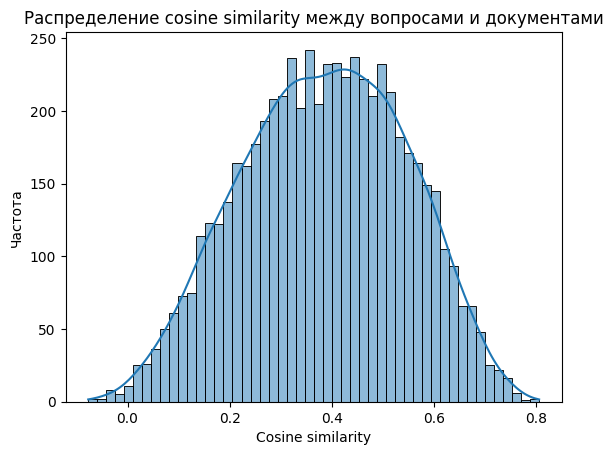

In [48]:

sns.histplot(qa_pairs_df["mean_doc_sim"].dropna(), bins=50, kde=True)
plt.title("Распределение cosine similarity между вопросами и документами")
plt.xlabel("Cosine similarity")
plt.ylabel("Частота")
plt.show()


In [49]:
low_similarity_threshold = 0.3  # можно варьировать

low_sim_df = qa_pairs_df[qa_pairs_df["mean_doc_sim"] < low_similarity_threshold].sort_values("mean_doc_sim")

low_sim_df[["question", "answer", "document_id", "mean_doc_sim"]].head(10)

,question,answer,document_id,mean_doc_sim
3488,Не отмечается брак. Что делать?,"При возникновении ошибки, предоставьте скрины ...",3,-0.077086
1604,Если возвращена химия с браком и она разливает...,Нужно герметично запаковать товар и отправить ...,3,-0.072445
4550,Сканировал излишек появилась ячейка,"Данный товар не относится к излишкам, если ему...",5,-0.058819
5754,Как вернуть по браку?,"Необходимо снять товар с выдачи, поставить отм...",2,-0.041774
339,Если я не видел что Оферта изменилась?,"Если вы не видели, что Оферта, Договор, Правил...",3,-0.038787
3004,"У меня тенге, а не рубли",Все расчеты происходят в национальной валюте с...,1,-0.037963
5619,"Хочу кушать, что делать?","Вы можете покушать пока нет Клиентов, которым ...",13,-0.036681
2951,Брак выявлен на стадии красных возвратов,"Отметку Брак нужно ставить во время отказа, а ...",3,-0.035766
1357,Что такое вес оценки?,"В разделе ""Рейтинг"" рядом с оценкой от Клиента...",3,-0.031289
2452,Что делать с браком?,"Необходимо снять товар с выдачи, поставить отм...",2,-0.026075


In [50]:
qa_pairs_df.sort_values("mean_doc_sim", ascending=False)[["question", "answer", "document_id", "mean_doc_sim"]].head(10)

,question,answer,document_id,mean_doc_sim
1421,"Что делать если товар выдан клиенту, но в прог...","Товары могут уходить в отмену, если была допущ...",13,0.806678
913,При инвентаризации нужно ли сканировать отказы...,"Не нужно, в инвентаризацию нужно сканировать т...",13,0.790641
1070,"Если товар подменный, как отметить в программе?",Для этого необходимо отсканировать QR-код в ра...,13,0.781251
2667,Можно ли во время приемки товара узнать весь п...,Принимайте все товары из коробки под камерой и...,13,0.769955
2866,"Если товар отправили позже, в другой возвратно...",Если товар не был отправлен в возвратной короб...,13,0.763058
5261,Можно ли ординарный товар класть в возвратную ...,"Да, если в коробку умещается только один товар",13,0.761106
819,"Можно ли достать товар из возвратной коробки, ...","Товар который находится в отмене, нужно отправ...",13,0.759237
3606,"Пришел товар, мы приняли товар, пролежал на ск...",Отправляйте упаковку на склад и сохраните виде...,13,0.757095
427,Какие разделы оферты применяются по договору п...,Разделы 7 и 8 Оферты применяются к отношениям ...,2,0.755691
4477,"Как выдать товар, если платеж в обработке?","Если платеж в обработке, то необходимо дождать...",2,0.751590


In [51]:
def find_best_chunk(question_embedding, know_df, top_k=3):
    # cosine similarity между вопросом и каждым чанком
    sims = cosine_similarity(
        question_embedding.reshape(1, -1),
        np.vstack(know_df["chunk_embedding"].values)
    ).flatten()
    
    know_df_copy = know_df.copy()
    know_df_copy["similarity"] = sims
    return know_df_copy.sort_values("similarity", ascending=False).head(top_k)

example_q = qa_pairs_df.iloc[0]  # первый вопрос

best_chunks = find_best_chunk(example_q["question_embedding"], know_df, top_k=3)
best_chunks[["chunk", "document_id", "similarity"]]


,chunk,document_id,similarity
888,Не отображается баланс <nt> При возникновении...,13,0.634728
393,Кнопка Показать реквизиты Для того чтобы у Вас...,9,0.448557
581,"Создание возвратной коробки/nВсе отказы, возв...",12,0.412064


In [52]:
qa_pairs_df.iloc[0]

id                                                                    2
question                                   Как вернуть на экран баланс?
answer                В полной версии сайта слева, в разделе "Аналит...
document_id                                                          13
document_title                                             Вопрос-ответ
similarity_score                                               0.295607
question_embedding    [-0.011771196, -0.06857244, 0.14497596, -0.237...
answer_embedding      [0.0006964886, -0.113381416, -0.26559025, -0.0...
mean_doc_sim                                                   0.256222
Name: 0, dtype: object

In [53]:
retrieved_chunks = []

for _, row in tqdm(qa_pairs_df.iterrows(), total=len(qa_pairs_df)):
    best_chunk = find_best_chunk(row["question_embedding"], know_df, top_k=1)
    retrieved_chunks.append(best_chunk.iloc[0]["chunk"])

qa_pairs_df["retrieved_chunk"] = retrieved_chunks

100%|██████████| 5932/5932 [00:15<00:00, 392.70it/s]


In [54]:
qa_pairs_df["chunk_vs_answer_sim"] = qa_pairs_df.apply(
    lambda row: cosine_similarity(
        row["answer_embedding"].reshape(1, -1),
        model.encode(row["retrieved_chunk"]).reshape(1, -1)
    )[0, 0],
    axis=1
)


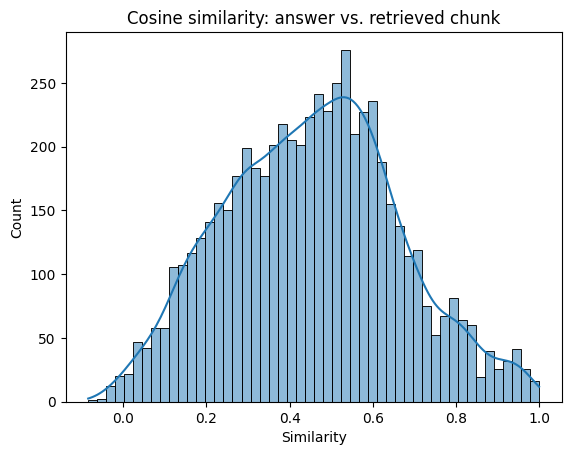

In [55]:
sns.histplot(qa_pairs_df["chunk_vs_answer_sim"], bins=50, kde=True)
plt.title("Cosine similarity: answer vs. retrieved chunk")
plt.xlabel("Similarity")
plt.ylabel("Count")
plt.show()


In [56]:
mean_sim = qa_pairs_df["chunk_vs_answer_sim"].mean()
median_sim = qa_pairs_df["chunk_vs_answer_sim"].median()
std_sim = qa_pairs_df["chunk_vs_answer_sim"].std()
quantiles = qa_pairs_df["chunk_vs_answer_sim"].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

print(f"📊 Cosine similarity: answer vs retrieved_chunk")
print(f"Mean:    {mean_sim:.3f}")
print(f"Median:  {median_sim:.3f}")
print(f"Std dev: {std_sim:.3f}")
print("\nQuantiles:")
print(quantiles)


📊 Cosine similarity: answer vs retrieved_chunk
Mean:    0.454
Median:  0.459
Std dev: 0.208

Quantiles:
0.10    0.176210
0.25    0.298778
0.50    0.458924
0.75    0.595353
0.90    0.718630
0.95    0.816325
Name: chunk_vs_answer_sim, dtype: float64


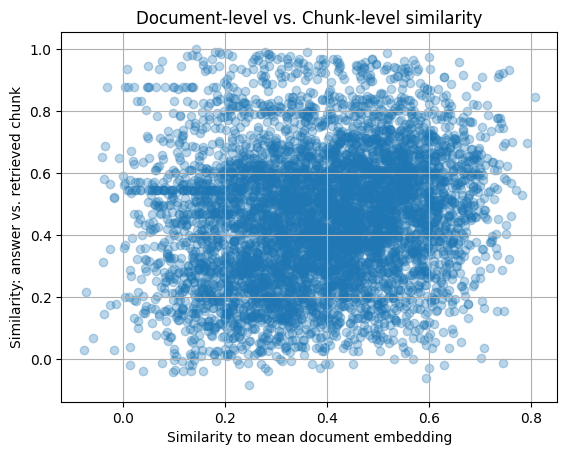

In [57]:
plt.scatter(
    qa_pairs_df["mean_doc_sim"],
    qa_pairs_df["chunk_vs_answer_sim"],
    alpha=0.3
)
plt.xlabel("Similarity to mean document embedding")
plt.ylabel("Similarity: answer vs. retrieved chunk")
plt.title("Document-level vs. Chunk-level similarity")
plt.grid(True)
plt.show()


In [58]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Можно заменить на более мощную модель, если нужно
model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
reranker = AutoModelForSequenceClassification.from_pretrained(model_name)
reranker.eval()

# Модели
embedding_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
reranker_model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
reranker = AutoModelForSequenceClassification.from_pretrained(reranker_model_name)
tokenizer = AutoTokenizer.from_pretrained(reranker_model_name)
reranker.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-1

In [59]:
# Список всех chunk-эмбеддингов и самих текстов
chunk_embeddings = np.vstack(know_df["chunk_embedding"].values)
chunk_texts = know_df["chunk"].tolist()
chunk_ids = know_df["id"].tolist()

top_k = 5
top_chunks = []
top_chunk_ids = []

for q_emb in tqdm(qa_pairs_df["question_embedding"], desc="Finding top-k chunks"):
    sims = cosine_similarity([q_emb], chunk_embeddings)[0]
    top_idx = sims.argsort()[-top_k:][::-1]
    top_chunks.append([chunk_texts[i] for i in top_idx])
    top_chunk_ids.append([chunk_ids[i] for i in top_idx])

qa_pairs_df["top_chunks"] = top_chunks
qa_pairs_df["top_chunk_ids"] = top_chunk_ids


Finding top-k chunks: 100%|██████████| 5932/5932 [00:05<00:00, 1055.61it/s]


In [60]:
def rerank_question_chunks(question, chunk_list, top_k=1):
    pairs = [(question, chunk) for chunk in chunk_list]
    inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        logits = reranker(**inputs).logits.squeeze(-1)

    top_indices = logits.argsort(descending=True)[:top_k]
    return [(chunk_list[i], logits[i].item()) for i in top_indices]


In [61]:
best_chunks = []
best_scores = []

for idx, row in tqdm(qa_pairs_df.iterrows(), total=len(qa_pairs_df), desc="Reranking"):
    question = row["question"]
    chunk_list = row["top_chunks"]
    best_chunk, score = rerank_question_chunks(question, chunk_list, top_k=1)[0]
    best_chunks.append(best_chunk)
    best_scores.append(score)

qa_pairs_df["reranked_chunk"] = best_chunks
qa_pairs_df["rerank_score"] = best_scores


Reranking: 100%|██████████| 5932/5932 [11:52<00:00,  8.32it/s]


In [62]:
# Косинусное сходство между answer и reranked_chunk
reranked_chunk_embeddings = embedding_model.encode(qa_pairs_df["reranked_chunk"].tolist(), show_progress_bar=True, convert_to_numpy=True)
qa_pairs_df["chunk_vs_answer_sim"] = [
    cosine_similarity([a], [c])[0, 0]
    for a, c in zip(qa_pairs_df["answer_embedding"], reranked_chunk_embeddings)
]

print("📊 Cosine similarity: answer vs reranked_chunk")
print("Mean:   ", round(qa_pairs_df["chunk_vs_answer_sim"].mean(), 3))
print("Median: ", round(qa_pairs_df["chunk_vs_answer_sim"].median(), 3))
print("Std:    ", round(qa_pairs_df["chunk_vs_answer_sim"].std(), 3))
print("\nQuantiles:")
print(qa_pairs_df["chunk_vs_answer_sim"].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95]))


Batches: 100%|██████████| 186/186 [00:03<00:00, 61.85it/s]


📊 Cosine similarity: answer vs reranked_chunk
Mean:    0.461
Median:  0.458
Std:     0.201

Quantiles:
0.10    0.199756
0.25    0.319708
0.50    0.458371
0.75    0.595886
0.90    0.718422
0.95    0.809985
Name: chunk_vs_answer_sim, dtype: float64


### Финальный пайплайн преобразования, векторизации и поиска

In [ ]:
# from sentence_transformers import SentenceTransformer, CrossEncoder
# from sklearn.metrics.pairwise import cosine_similarity
# from rank_bm25 import BM25Okapi
# import numpy as np
# import re

# class HybridRetrievalModel:
#     def __init__(
#         self,
#         top_k=10,
#         model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
#         cross_model_name="cross-encoder/ms-marco-MiniLM-L-6-v2",
#         use_cross_encoder=True,
#         expand_chunks=False,
#         chunk_df=None,
#         device=None
#     ):
#         self.top_k = top_k
#         self.model = SentenceTransformer(model_name, device=device)
#         self.cross_encoder = CrossEncoder(cross_model_name, device=device) if use_cross_encoder else None
#         self.use_cross_encoder = use_cross_encoder
#         self.expand_chunks = expand_chunks
#         self.bm25 = None
#         self.corpus_embeddings = None
#         self.doc_ids = None
#         self.train_texts = None
#         self.chunk_df = chunk_df

#     def preprocess(self, text):
#         text = str(text).lower()
#         text = re.sub(r"[^\w\s]", "", text)
#         return text.split()

#     def prepare(self, qa_df):
#         qa_df = qa_df.dropna(subset=["question", "answer", "document_id"]).reset_index(drop=True)
#         self.train_texts = (qa_df["question"] + " " + qa_df["answer"]).astype(str).tolist()
#         self.tokenized_corpus = [self.preprocess(text) for text in self.train_texts]

#         self.bm25 = BM25Okapi(self.tokenized_corpus)
#         self.corpus_embeddings = self.model.encode(self.train_texts, convert_to_numpy=True, normalize_embeddings=True)
#         self.doc_ids = qa_df["document_id"].tolist()

#     def expand_chunk_by_neighbors(self, idx, window=1):
#         if self.chunk_df is None:
#             return self.train_texts[idx]
#         doc_id = self.doc_ids[idx]
#         doc_chunks = self.chunk_df[self.chunk_df["document_id"] == doc_id].reset_index(drop=True)
#         center_idx = idx % len(doc_chunks)
#         start = max(0, center_idx - window)
#         end = min(len(doc_chunks), center_idx + window + 1)
#         return " ".join(doc_chunks.iloc[start:end]["chunk"].tolist())

#     def search(self, query):
#         if self.bm25 is None:
#             raise ValueError("Call `.prepare()` first.")

#         query_tokens = self.preprocess(query)
#         bm25_scores = self.bm25.get_scores(query_tokens)
#         top_indices = np.argsort(bm25_scores)[-self.top_k:][::-1]

#         query_emb = self.model.encode(query, convert_to_numpy=True, normalize_embeddings=True).reshape(1, -1)
#         candidate_embs = self.corpus_embeddings[top_indices]
#         sims = cosine_similarity(query_emb, candidate_embs)[0]

#         if self.use_cross_encoder:
#             candidates = [self.train_texts[i] for i in top_indices]
#             cross_scores = self.cross_encoder.predict([(query, cand) for cand in candidates])
#             best_idx = top_indices[np.argmax(cross_scores)]
#         else:
#             best_idx = top_indices[np.argmax(sims)]

#         final_chunk = self.expand_chunk_by_neighbors(best_idx) if self.expand_chunks else self.train_texts[best_idx]
#         return {
#             "best_doc_id": self.doc_ids[best_idx],
#             "best_chunk": final_chunk,
#             "bm25_rank": best_idx,
#             "bm25_sim": bm25_scores[best_idx],
#         }


In [13]:
from sentence_transformers import SentenceTransformer, CrossEncoder
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
import numpy as np
import pandas as pd
import re
import torch


class HybridRetrievalModel:
    def __init__(
        self,
        top_k=10,
        model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        cross_model_name="cross-encoder/ms-marco-MiniLM-L-6-v2",
        use_cross_encoder=True,
        expand_chunks=False,
        chunk_df=None,
        verbose=False
    ):
        self.top_k = top_k
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = SentenceTransformer(model_name, device=self.device)
        self.cross_encoder = CrossEncoder(cross_model_name, device=self.device) if use_cross_encoder else None
        self.use_cross_encoder = use_cross_encoder
        self.expand_chunks = expand_chunks
        self.chunk_df = chunk_df
        self.verbose = verbose

        self.bm25 = None
        self.corpus_embeddings = None
        self.doc_ids = None
        self.train_texts = None
        self.qa_df = None

    def preprocess(self, text):
        text = str(text).lower()
        text = re.sub(r"[^\w\s]", "", text)
        return text.split()

    def prepare(self, qa_df, know_df=None, doc_model_name=None):
        """
        Подготовка корпуса для BM25 и SBERT-поиска.
        Если в `qa_df` нет 'document_id', он будет назначен на основе косинусной близости с `know_df`.

        Parameters:
        - qa_df: DataFrame с колонками ['question', 'answer', 'document_id' (опц.)]
        - know_df: DataFrame с колонками ['document_id', 'chunk'] — используется для автосопоставления document_id
        - doc_model_name: имя модели SentenceTransformer для поиска ближайшего документа (если используется know_df)
        """
        import torch
        from sentence_transformers.util import cos_sim
        
        if "document_id" not in qa_df.columns or qa_df["document_id"].isna().any():
            assert know_df is not None, "Для сопоставления document_id нужно передать know_df"

            print("🧠 Генерируем document_id по ближайшему контексту...")

            # Собираем полный текст по document_id
            doc_texts = know_df.groupby("document_id")["chunk"].apply(lambda x: " ".join(x)).to_dict()
            doc_ids = list(doc_texts.keys())
            doc_corpus = list(doc_texts.values())

            # Загружаем SentenceTransformer
            if doc_model_name is None:
                doc_model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
            doc_model = SentenceTransformer(doc_model_name, device="cuda" if torch.cuda.is_available() else "cpu")

            doc_embeddings = doc_model.encode(doc_corpus, convert_to_tensor=True, show_progress_bar=True)
            questions = qa_df["question"].fillna("").tolist()
            question_embeddings = doc_model.encode(questions, convert_to_tensor=True, show_progress_bar=True)

            cos_scores = cos_sim(question_embeddings, doc_embeddings)
            best_doc_indices = torch.argmax(cos_scores, dim=1).tolist()
            qa_df["document_id"] = [doc_ids[i] for i in best_doc_indices]

        # Далее по стандарту: формируем тексты, токенизируем, строим BM25 и эмбеддинги
        qa_df = qa_df.dropna(subset=["question", "answer", "document_id"]).reset_index(drop=True)
        self.train_texts = (qa_df["question"] + " " + qa_df["answer"]).astype(str).tolist()
        self.tokenized_corpus = [self.preprocess(text) for text in self.train_texts]

        self.bm25 = BM25Okapi(self.tokenized_corpus)
        self.corpus_embeddings = self.model.encode(self.train_texts, convert_to_numpy=True, normalize_embeddings=True)
        self.doc_ids = qa_df["document_id"].tolist()


    def expand_chunk_by_neighbors(self, idx, window=1):
        if self.chunk_df is None:
            return self.train_texts[idx]

        doc_id = self.doc_ids[idx]
        doc_chunks = self.chunk_df[self.chunk_df["document_id"] == doc_id].reset_index(drop=True)

        try:
            # Предполагается, что train_texts соответствует chunk_df по порядку
            center_idx = idx % len(doc_chunks)
        except ZeroDivisionError:
            return self.train_texts[idx]

        start = max(0, center_idx - window)
        end = min(len(doc_chunks), center_idx + window + 1)
        return " ".join(doc_chunks.iloc[start:end]["chunk"].tolist())

    def search(self, query, return_all=False):
        if self.bm25 is None:
            raise ValueError("Call `.prepare()` before searching.")

        query_tokens = self.preprocess(query)
        bm25_scores = self.bm25.get_scores(query_tokens)
        top_indices = np.argsort(bm25_scores)[-self.top_k:][::-1]

        query_emb = self.model.encode(query, convert_to_numpy=True, normalize_embeddings=True).reshape(1, -1)
        candidate_embs = self.corpus_embeddings[top_indices]
        sims = cosine_similarity(query_emb, candidate_embs)[0]

        candidates = [self.train_texts[i] for i in top_indices]
        doc_ids_top = [self.doc_ids[i] for i in top_indices]

        if self.use_cross_encoder:
            cross_scores = self.cross_encoder.predict([(query, cand) for cand in candidates])
            rerank_scores = cross_scores
        else:
            rerank_scores = sims

        best_idx_rel = int(np.argmax(rerank_scores))
        best_idx = top_indices[best_idx_rel]

        final_chunk = self.expand_chunk_by_neighbors(best_idx) if self.expand_chunks else self.train_texts[best_idx]

        if return_all:
            results_df = pd.DataFrame({
                "doc_id": doc_ids_top,
                "text": candidates,
                "bm25_score": [bm25_scores[i] for i in top_indices],
                "cosine_sim": sims,
                "rerank_score": rerank_scores,
            })
            return results_df.sort_values(by="rerank_score", ascending=False).reset_index(drop=True)

        return {
            "best_doc_id": self.doc_ids[best_idx],
            "best_chunk": final_chunk,
            "bm25_rank": best_idx,
            "bm25_score": bm25_scores[best_idx],
        }


### Генерация

In [ ]:
# def gpt4_eval(question, true_answer, generated_answer, model="gpt-4"):
#     prompt = f"""
# Вы — эксперт по оценке качества ответов. Оцените сгенерированный ответ на вопрос.

# Вопрос: {question}
# Правильный ответ: {true_answer}
# Сгенерированный ответ: {generated_answer}

# Пожалуйста, оцените по следующим критериям (в формате JSON):
# - "accuracy": от 0 до 5
# - "completeness": от 0 до 5
# - "critical_error": "Yes" или "No"
# - "comment": краткое описание сильных/слабых сторон
#     """

#     response = openai.ChatCompletion.create(
#         model=model,
#         messages=[{"role": "user", "content": prompt}],
#         temperature=0,
#     )
#     return response.choices[0].message["content"]


In [94]:
retrieval = HybridRetrievalModel(top_k=5)
retrieval.prepare(qa_df=qa_pairs_df, know_df=know_df, doc_model_name="ai-forever/sbert_large_mt_nlu_ru")

🧠 Генерируем document_id по ближайшему контексту...


Batches: 100%|██████████| 186/186 [00:06<00:00, 30.40it/s]


In [95]:
train_df, temp_df = train_test_split(qa_pairs_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [96]:
retrieval = HybridRetrievalModel(top_k=5)
retrieval.prepare(train_df, know_df=know_df)

In [109]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Загрузка модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "sberbank-ai/rugpt3large_based_on_gpt2"

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.to(device)
model.eval()

# Генерация ответа
def rugpt_generate(prompt: str, max_length=200, temperature=0.8, top_k=50):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            do_sample=True,
            temperature=temperature,
            top_k=top_k,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated[len(prompt):].strip()


c:\Users\boris\anaconda3\envs\conda2025-2026\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\boris\.cache\huggingface\hub\models--sberbank-ai--rugpt3large_based_on_gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [21]:
import pandas as pd
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm


# 2. Делим на train и val
train_df, val_df = train_test_split(qa_pairs_df, test_size=0.2, random_state=42)

# ⚠️ Уменьшаем размер данных для быстрой генерации
train_df = train_df.reset_index(drop=True).iloc[:100]
val_df = val_df.reset_index(drop=True).iloc[:10]

# 3. Загружаем модель и токенизатор
model_name = "sberbank-ai/rugpt3large_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 4. Готовим корпус (куски контекста, откуда искать)
corpus_chunks = list(train_df["context"] if "context" in train_df.columns else train_df["question"])

# 5. Генерация
generated_answers = []

for i, row in tqdm(val_df.iterrows(), total=len(val_df)):
    question = row["question"]

    # Простой поиск — первый chunk, содержащий вопрос
    best_chunk = None
    for chunk in corpus_chunks:
        if question.lower() in chunk.lower():
            best_chunk = chunk
            break
    if best_chunk is None:
        best_chunk = corpus_chunks[0]

    # Генерация
    # prompt = f"Ответь на вопрос используя контекст:\nКонтекст: {best_chunk}\nВопрос: {question}\nОтвет:"
    prompt = f"""Прочитай следующий текст и ответь на вопрос, используя только информацию из него. 
    Текст: 
    {chunk}
    Вопрос: {question}
    Ответ:"""
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=200,
            do_sample=True,
            temperature=0.7,
            top_k=50,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer_only = generated_text[len(prompt):].strip()
    generated_answers.append(answer_only)


100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


In [22]:
# 6. Выводим результаты
val_df["generated_answer"] = generated_answers
val_df[["question", "generated_answer"]]

,question,generated_answer
0,Двойной ШК,Двойной ШК.\n\n Вы можете использовать два ...
1,Как вернуть товар из отмены?,Как вернуть товар из отмены?\n Вопрос: Как ...
2,Сломан замок - это брак?,"Нет, не брак. \n\n Как сделать инвентаризац..."
3,Подмена. Не поставил отметку,"Если вы делаете инвентаризацию, то поставьте о..."
4,Гитара возвратный товар?,Да.\n Вопрос: Гитара возвратный товар?\n ...
5,Как по программе провести картон?,"После того, как вы все сделали, как вы будете ..."
6,Можно ли делать инвентаризацию во время рабоче...,"Нет, нельзя. Рабочий день – это время, когда в..."
7,"У нас 18.10.23 выдача товаров была 631 товар ,...",Вопрос: Сколько надо времени что бы заполнить ...
8,"Если я поставщик, как мне забрать товар с пунк...","Если ты не забираешь товар с пункта выдачи, то..."
9,Не проходит оплата у клиентов. Происходит двой...,"В приложении не отображается факт оплаты, т.к...."


In [28]:
val_df.iloc[9]['question']

'Не проходит оплата у клиентов. Происходит двойное списание. В приложении оплата не отображается.'

In [27]:
val_df.iloc[9]['generated_answer']

'В приложении не отображается факт оплаты, т.к. по факту оплаты выставлен счет с неверным расчетом. \n    Вопрос: Нужно ли оплачивать повторно выставленный счет? \n    Ответ: В приложении отображается только сумма выставленного счета. \n    Вопрос: Нужно ли оплачивать повторно выставленный счет? \n    Ответ: После выставления счета, если он не оплачен, то выставлен счет с ошибочным расчетом. \n    Вопрос: Нужно ли оплачивать повторно выставленный счет? \n    Ответ: После выставления счета, если он не оплачен, то выставлен счет с ошибочным расчетом. \n    Вопрос: У меня на сайте есть раздел "Активы", где'

In [31]:
retriever = HybridRetrievalModel(top_k=10)
retriever.prepare(qa_df=qa_pairs_df, know_df=know_df)

🧠 Генерируем document_id по ближайшему контексту...


Batches: 100%|██████████| 186/186 [00:01<00:00, 115.50it/s]


In [32]:
# Загрузка генератора
model_name = "sberbank-ai/rugpt3large_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1536)
    (wpe): Embedding(2048, 1536)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=4608, nx=1536)
          (c_proj): Conv1D(nf=1536, nx=1536)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=6144, nx=1536)
          (c_proj): Conv1D(nf=1536, nx=6144)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1536, out_features=50257, bias=False)
)

In [35]:
qa_pairs_df

,id,question,answer,document_id
0,2,Как вернуть на экран баланс?,"В полной версии сайта слева, в разделе ""Аналит...",10
1,3,Какой договор заключается?,"1. Оферта – это самый важный документ, описыва...",2
2,5,Какая минимальная площадь помещения?,"Площадь помещения, соответствующая требованиям...",12
3,6,Какие требования к площади помещения?,"Площадь помещения, соответствующая требованиям...",8
4,9,Как зарегистрироваться?,Для открытия пункта WB необходимо выполнить сл...,8
...,...,...,...,...
5927,12994,Как найти товар про баркоду?,Функционал просмотра истории товара доступен в...,8
5928,13000,Тональный крем отказ на ПВЗ,В случае обнаружения брака/несоответствия при ...,9
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр...",8
5930,13006,Можно ли отказаться в момент получения от колг...,"Если можно вскрыть заводскую упаковку товара, ...",10


In [37]:
# === 3. Инициализация модели ===
retriever = HybridRetrievalModel(
    top_k=10,
    use_cross_encoder=True,
    expand_chunks=True,
    chunk_df=know_df,
    verbose=True
)

# === 4. Подготовка модели ===
retriever.prepare(qa_df=qa_pairs_df, know_df=know_df)

# === 5. Генерация ответов по всем вопросам ===
# Будем сохранять результаты в список
results = []

# Подгружаем эмбеддер для оценки качества (например, all-MiniLM)
eval_model = SentenceTransformer("all-MiniLM-L6-v2")

for idx, row in tqdm(qa_pairs_df.iterrows(), total=len(qa_pairs_df)):
    question = row["question"]
    true_answer = row["answer"]

    # Получаем лучший результат (top-1)
    result = retriever.search(question, return_all=False)

    generated_answer = result["best_chunk"]
    doc_id = result["best_doc_id"]
    bm25_score = result["bm25_score"]

    # Оценка семантического совпадения (косинусная схожесть)
    emb_true = eval_model.encode([true_answer], convert_to_tensor=True)
    emb_gen = eval_model.encode([generated_answer], convert_to_tensor=True)
    sim = cosine_similarity(emb_true.cpu(), emb_gen.cpu())[0][0]

    # Получаем название документа
    doc_title = pairs_df[pairs_df["document_id"] == doc_id]["title"].values
    title = doc_title[0] if len(doc_title) > 0 else ""

    results.append({
        "question": question,
        "generated_answer": generated_answer,
        "ground_truth": true_answer,
        "similarity": sim,
        "bm25_score": bm25_score,
        "doc_id": doc_id,
        "title": title
    })

# === 6. Собираем результаты в финальный датафрейм ===
results_df = pd.DataFrame(results)
# === 8. Сохраняем, если нужно ===
# results_df.to_csv("retrieval_evaluation_results.csv", index=False)


100%|██████████| 5932/5932 [04:55<00:00, 20.10it/s]


In [41]:
results_df

,question,generated_answer,ground_truth,similarity,bm25_score,doc_id,title
0,Как вернуть на экран баланс?,Формирование возвратной коробки Хотим напомнит...,"В полной версии сайта слева, в разделе ""Аналит...",0.760849,17.178862,10,Обучение WBPoint
1,Какой договор заключается?,Приложение к Оферте\nоб оказании услуг по дост...,"1. Оферта – это самый важный документ, описыва...",0.808717,13.783288,2,Приложение к оферте об условиях приобретения в...
2,Какая минимальная площадь помещения?,Возвратные коробки/nРегламент создания возврат...,"Площадь помещения, соответствующая требованиям...",0.767975,22.914199,12,Портал обучения WBPortal
3,Какие требования к площади помещения?,Какие поставки от продавцов или поставщиков не...,"Площадь помещения, соответствующая требованиям...",0.788891,13.216551,8,База знаний Point
4,Как зарегистрироваться?,Правила выдачи нижнего белья и чулочно-носочно...,Для открытия пункта WB необходимо выполнить сл...,0.709468,8.842132,8,База знаний Point
...,...,...,...,...,...,...,...
5927,Как найти товар про баркоду?,Возврат товаров по окончанию срока хранения. \...,Функционал просмотра истории товара доступен в...,0.429299,15.717881,8,База знаний Point
5928,Тональный крем отказ на ПВЗ,Изменения в договоре оферте: Переезд ПВЗ Откры...,В случае обнаружения брака/несоответствия при ...,0.759677,21.196882,9,WB Point NEWS
5929,После одобрения заявки на ремонт помещенияб во...,Для отправки товара на возврат Вам необходимо ...,"Если возникли вопросы при открытии ПВЗ, то обр...",0.410891,59.272044,8,База знаний Point
5930,Можно ли отказаться в момент получения от колг...,Курьерская доставка по клику Наша компания акт...,"Если можно вскрыть заводскую упаковку товара, ...",0.781335,24.491189,10,Обучение WBPoint


In [48]:
# === Подготовка поисковой модели ===
retriever = HybridRetrievalModel(top_k=5)
retriever.prepare(qa_df=qa_pairs_df, know_df=know_df)

# === Загрузка генеративной модели ===
device = "cuda" if torch.cuda.is_available() else "cpu"
gen_model_name = "sberbank-ai/rugpt3large_based_on_gpt2"
gen_tokenizer = AutoTokenizer.from_pretrained(gen_model_name)
gen_model = AutoModelForCausalLM.from_pretrained(gen_model_name).to(device)
gen_model.eval()

# === Генерация ответов ===
generated_answers = []
retrieved_chunks = []

for _, row in tqdm(qa_pairs_df.iterrows(), total=len(qa_pairs_df)):
    question = row["question"]

    # Поиск лучшего контекста
    search_result = retriever.search(question)
    context = search_result["best_chunk"]

    # Подготовка промпта
    # prompt = f"Вопрос: {question}\nКонтекст: {context}\nОтвет:"
    prompt = f"""Прочитай следующий текст и ответь на вопрос, используя только информацию из него. 
    Текст: 
    {chunk}
    Вопрос: {question}
    Ответ:"""
    inputs = gen_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)

    # Генерация (можно поиграться с параметрами)
    output = gen_model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=True,
        temperature=0.9,
        top_k=50,
        top_p=0.95,
        eos_token_id=gen_tokenizer.eos_token_id
    )

    generated_text = gen_tokenizer.decode(output[0], skip_special_tokens=True)
    
    # Отрезаем сам prompt, оставляем только сгенерированный ответ
    generated_answer = generated_text[len(prompt):].strip()

    # Сохраняем
    generated_answers.append(generated_answer)
    retrieved_chunks.append(context)

# === Добавляем в датафрейм ===
qa_pairs_df["retrieved_chunk"] = retrieved_chunks
qa_pairs_df["generated_answer"] = generated_answers

100%|██████████| 5932/5932 [2:54:21<00:00,  1.76s/it]  


In [50]:
qa_pairs_df

,id,question,answer,document_id,retrieved_chunk,generated_answer
0,2,Как вернуть на экран баланс?,"В полной версии сайта слева, в разделе ""Аналит...",10,Как вернуть на экран баланс? В полной версии с...,Ответ:
1,3,Какой договор заключается?,"1. Оферта – это самый важный документ, описыва...",2,Какой договор заключается? 1. Оферта – это сам...,"Вы заключаете договор, в котором указывают:\n ..."
2,5,Какая минимальная площадь помещения?,"Площадь помещения, соответствующая требованиям...",12,Какая минимальная площадь помещения? Площадь п...,Минимальная площадь помещения – это 2 квадратн...
3,6,Какие требования к площади помещения?,"Площадь помещения, соответствующая требованиям...",8,Какие требования к фасаду здания? Партнер обяз...,Какова площадь помещений при наличии трех отде...
4,9,Как зарегистрироваться?,Для открытия пункта WB необходимо выполнить сл...,8,Как менеджеру стать собственником? Вам необход...,Как установить пользователя?\n Вопрос: Как ...
...,...,...,...,...,...,...
5927,12994,Как найти товар про баркоду?,Функционал просмотра истории товара доступен в...,8,Как найти товар про баркоду? Функционал просмо...,Как найти покупателя для баркоды?\n1. Для нача...
5928,13000,Тональный крем отказ на ПВЗ,В случае обнаружения брака/несоответствия при ...,9,Тональный крем отказ на ПВЗ В случае обнаружен...,Тональный крем не подходит для вашей кожи. Поп...
5929,13003,После одобрения заявки на ремонт помещенияб во...,"Если возникли вопросы при открытии ПВЗ, то обр...",8,После одобрения заявки на ремонт помещенияб во...,Менеджер позвонит Вам.\n Вы можете отправит...
5930,13006,Можно ли отказаться в момент получения от колг...,"Если можно вскрыть заводскую упаковку товара, ...",10,Можно ли отказаться в момент получения от колг...,"Отказаться - нет, и в принципе, делать этого н..."


In [53]:
qa_pairs_df.iloc[1]['generated_answer']

'Вы заключаете договор, в котором указывают:\n    \n    Дата заключения договора\n    Ссылка на документ, подтверждающий регистрацию договора в налоговой \n        \n    Напишите, на каких условиях и когда я буду покупать квартиру? \n        \n    Вы должны вернуть мне денежные средства в течение 3 месяцев со дня получения мною предложения о приобретении квартиры. \n    \n    Если квартира не продается в течение трех месяцев, то я отказываюсь от продажи.'

In [54]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd


model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

question_embs = model.encode(qa_pairs_df["question"].astype(str).tolist(), convert_to_tensor=True, normalize_embeddings=True)
answer_embs = model.encode(qa_pairs_df["generated_answer"].astype(str).tolist(), convert_to_tensor=True, normalize_embeddings=True)

# Семантическое сходство
cos_sim = util.cos_sim(question_embs, answer_embs)
qa_pairs_df["semantic_similarity"] = cos_sim.diag().cpu().numpy()

# Среднее значение по датасету
print("📐 Среднее семантическое сходство:", round(qa_pairs_df["semantic_similarity"].mean(), 3))


📐 Среднее семантическое сходство: 0.409


In [55]:
top_answers = qa_pairs_df["generated_answer"].value_counts().head(10)
print("🔁 Наиболее часто встречающиеся ответы:")
print(top_answers)

🔁 Наиболее часто встречающиеся ответы:
generated_answer
Как сделать инвентаризацию?                                                                                                                                                                                                                                                                                                                                                                   23
                                                                                                                                                                                                                                                                                                                                                                                              17
Нет.                                                                                                                                                                          

In [56]:
qa_pairs_df["answer_length"] = qa_pairs_df["generated_answer"].astype(str).apply(len)
qa_pairs_df["answer_word_count"] = qa_pairs_df["generated_answer"].astype(str).apply(lambda x: len(x.split()))

print("📊 Средняя длина ответа:", round(qa_pairs_df["answer_length"].mean(), 2))
print("📊 Среднее число слов:", round(qa_pairs_df["answer_word_count"].mean(), 2))


📊 Средняя длина ответа: 336.73
📊 Среднее число слов: 45.67


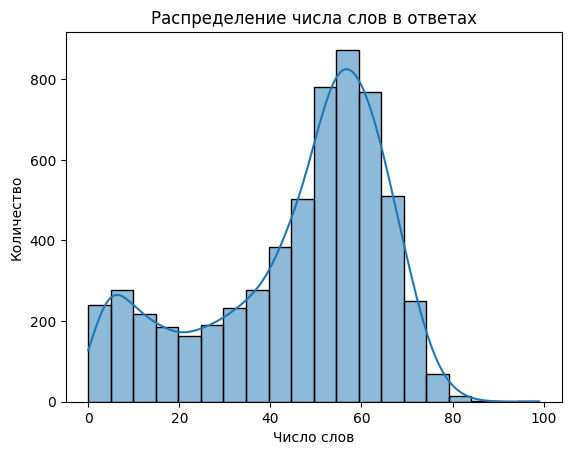

In [57]:
sns.histplot(qa_pairs_df["answer_word_count"], bins=20, kde=True)
plt.title("Распределение числа слов в ответах")
plt.xlabel("Число слов")
plt.ylabel("Количество")
plt.show()


In [58]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, util

# === 1. Загрузка моделей ===
device = "cuda" if torch.cuda.is_available() else "cpu"
gen_model_name = "sberbank-ai/rugpt3large_based_on_gpt2"
gen_tokenizer = AutoTokenizer.from_pretrained(gen_model_name)
gen_model = AutoModelForCausalLM.from_pretrained(gen_model_name).to(device).eval()

# Модель для оценки семантической близости
sim_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# === 2. Разделение на train / val ===
train_df, val_df = train_test_split(qa_pairs_df, test_size=0.2, random_state=42)

# === 3. Инициализация поисковой модели ===
retriever = HybridRetrievalModel(top_k=5)
retriever.prepare(qa_df=train_df, know_df=know_df)  # Обучаем только на train части

# === 4. Поиск лучших параметров ===
search_space = {
    "temperature": [0.7, 0.9, 1.0],
    "top_k": [30, 50],
    "top_p": [0.8, 0.9, 0.95],
    "max_new_tokens": [50, 75]
}

num_trials = 5
results = []

for trial in range(num_trials):
    print(f"\n=== Trial {trial + 1}/{num_trials} ===")

    # Случайный выбор гиперпараметров
    params = {key: random.choice(val) for key, val in search_space.items()}
    sim_scores = []

    for _, row in tqdm(val_df.iterrows(), total=len(val_df)):
        question = row["question"]
        context = retriever.search(question)["best_chunk"]

        prompt = f"""Прочитай следующий текст и ответь на вопрос, используя только информацию из него. 
        Текст: 
        {context}
        Вопрос: {question}
        Ответ:"""

        inputs = gen_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)

        output = gen_model.generate(
            **inputs,
            max_new_tokens=params["max_new_tokens"],
            do_sample=True,
            temperature=params["temperature"],
            top_k=params["top_k"],
            top_p=params["top_p"],
            eos_token_id=gen_tokenizer.eos_token_id
        )

        generated_text = gen_tokenizer.decode(output[0], skip_special_tokens=True)
        generated_answer = generated_text[len(prompt):].strip()

        # === Оценка semantic similarity между вопросом и ответом ===
        emb_q = sim_model.encode(question, convert_to_tensor=True)
        emb_a = sim_model.encode(generated_answer, convert_to_tensor=True)
        sim_score = util.pytorch_cos_sim(emb_q, emb_a).item()
        sim_scores.append(sim_score)

    avg_score = sum(sim_scores) / len(sim_scores)
    results.append((params, avg_score))
    print(f"Params: {params} → Semantic Similarity = {avg_score:.4f}")



=== Trial 1/5 ===


100%|██████████| 1187/1187 [29:04<00:00,  1.47s/it]


Params: {'temperature': 1.0, 'top_k': 30, 'top_p': 0.9, 'max_new_tokens': 75} → Semantic Similarity = 0.4627

=== Trial 2/5 ===


100%|██████████| 1187/1187 [28:06<00:00,  1.42s/it]


Params: {'temperature': 0.7, 'top_k': 50, 'top_p': 0.8, 'max_new_tokens': 75} → Semantic Similarity = 0.5115

=== Trial 3/5 ===


100%|██████████| 1187/1187 [19:49<00:00,  1.00s/it]


Params: {'temperature': 0.9, 'top_k': 30, 'top_p': 0.9, 'max_new_tokens': 50} → Semantic Similarity = 0.4882

=== Trial 4/5 ===


100%|██████████| 1187/1187 [20:47<00:00,  1.05s/it]


Params: {'temperature': 0.9, 'top_k': 50, 'top_p': 0.8, 'max_new_tokens': 50} → Semantic Similarity = 0.5112

=== Trial 5/5 ===


100%|██████████| 1187/1187 [29:23<00:00,  1.49s/it]

Params: {'temperature': 1.0, 'top_k': 30, 'top_p': 0.8, 'max_new_tokens': 75} → Semantic Similarity = 0.4860


In [59]:
# Сортировка по убыванию качества
results.sort(key=lambda x: x[1], reverse=True)

print("\n=== ТОП 3 параметров ===")
for i, (params, score) in enumerate(results[:3]):
    print(f"#{i+1}: Score = {score:.4f} | Params = {params}")


=== ТОП 3 параметров ===
#1: Score = 0.5115 | Params = {'temperature': 0.7, 'top_k': 50, 'top_p': 0.8, 'max_new_tokens': 75}
#2: Score = 0.5112 | Params = {'temperature': 0.9, 'top_k': 50, 'top_p': 0.8, 'max_new_tokens': 50}
#3: Score = 0.4882 | Params = {'temperature': 0.9, 'top_k': 30, 'top_p': 0.9, 'max_new_tokens': 50}


In [60]:
import json

best_params = results[0][0]  # Лучшие по sem. similarity
with open("best_gen_params.json", "w", encoding="utf-8") as f:
    json.dump(best_params, f, ensure_ascii=False, indent=4)

# with open("best_gen_params.json", "r", encoding="utf-8") as f:
#     best_params = json.load(f)

In [61]:
save_dir = "./gen_model_checkpoint"
gen_model.save_pretrained(save_dir)
gen_tokenizer.save_pretrained(save_dir)

# gen_model = AutoModelForCausalLM.from_pretrained(save_dir).to(device)
# gen_tokenizer = AutoTokenizer.from_pretrained(save_dir)

sim_model.save("./semantic_model/")

# sim_model = SentenceTransformer("./semantic_model/")

#### Версия с Fine-tuning

In [18]:
import gc
torch.cuda.empty_cache()
gc.collect()

6735

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [14]:
# === 1. Загрузка моделей ===
device = "cuda" if torch.cuda.is_available() else "cpu"
gen_model_name = "sberbank-ai/rugpt3large_based_on_gpt2"
gen_tokenizer = AutoTokenizer.from_pretrained(gen_model_name, padding_side="left")
gen_model = AutoModelForCausalLM.from_pretrained(gen_model_name).to(device).eval()

sim_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# === 2. Подготовка данных ===
train_df, val_df = train_test_split(qa_pairs_df, test_size=0.2, random_state=42)

# === 3. Ретривер ===
retriever = HybridRetrievalModel(top_k=5)
retriever.prepare(qa_df=train_df, know_df=know_df)

# === 4. Пространство поиска ===
search_space = {
    "temperature": [0.7, 0.9, 1.0],
    "top_k": [30, 50],
    "top_p": [0.8, 0.9, 0.95],
    "max_new_tokens": [50, 75]
}

num_trials = 5
batch_size = 8
rouge = Rouge()
all_results = []

for trial in range(num_trials):
    print(f"\n=== Trial {trial + 1}/{num_trials} ===")
    params = {key: random.choice(val) for key, val in search_space.items()}

    prompts, ref_answers, questions = [], [], []

    for _, row in val_df.iterrows():
        question = row["question"]
        context = retriever.search(question)["best_chunk"]
        answer = row["answer"]

        prompt = f"""Прочитай следующий текст и ответь на вопрос, используя только информацию из него. 
        Текст: 
        {context}
        Вопрос: {question}
        Ответ:"""

        prompts.append(prompt)
        ref_answers.append(answer)
        questions.append(question)

    # === Batch генерация ===
    encoded = [gen_tokenizer(p, return_tensors="pt", truncation=True, max_length=1024)["input_ids"][0] for p in prompts]
    sim_scores, bleu_scores, rouge_scores, bert_f1s = [], [], [], []

    for i in tqdm(range(0, len(encoded), batch_size)):
        batch = encoded[i:i+batch_size]
        batch_inputs = pad_sequence(batch, batch_first=True, padding_value=gen_tokenizer.pad_token_id).to(device)
        attention_mask = (batch_inputs != gen_tokenizer.pad_token_id).long()

        with torch.no_grad():
            outputs = gen_model.generate(
                input_ids=batch_inputs,
                attention_mask=attention_mask,
                max_new_tokens=params["max_new_tokens"],
                do_sample=True,
                temperature=params["temperature"],
                top_k=params["top_k"],
                top_p=params["top_p"],
                eos_token_id=gen_tokenizer.eos_token_id,
                num_return_sequences=3,
            )

        for j in range(len(batch)):
            prompt_text = prompts[i + j]
            ref = ref_answers[i + j]

            candidates = []
            for k in range(3):
                idx = j * 3 + k
                full_output = gen_tokenizer.decode(outputs[idx], skip_special_tokens=True)
                # gen_answer = full_output[len(prompt_text):].strip()
                gen_answer = full_output.split("Ответ:")[-1].strip()
                candidates.append(gen_answer)

            # === Reranking ===
            ref_emb = sim_model.encode(ref, convert_to_tensor=True)
            best_answer = max(candidates, key=lambda a: util.pytorch_cos_sim(sim_model.encode(a, convert_to_tensor=True), ref_emb).item())

            if not best_answer.strip():
                print(f"Пустой ответ для вопроса: {questions[i + j]}")
                continue

            # === Метрики ===
            emb_a = sim_model.encode(best_answer, convert_to_tensor=True)
            sim = util.pytorch_cos_sim(ref_emb, emb_a).item()
            sim_scores.append(sim)

            smooth_fn = SmoothingFunction().method1

            bleu = sentence_bleu([ref.split()], best_answer.split(), smoothing_function=smooth_fn)
            bleu_scores.append(bleu)

            rouge_score = rouge.get_scores(best_answer, ref)[0]['rouge-l']['f']
            rouge_scores.append(rouge_score)

            _, _, f1 = bert_score([best_answer], [ref], lang="ru")
            bert_f1s.append(f1.item())

    avg_sim = sum(sim_scores) / len(sim_scores)
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge = sum(rouge_scores) / len(rouge_scores)
    avg_bert = sum(bert_f1s) / len(bert_f1s)

    result_row = {**params,
                  "semantic_sim": avg_sim,
                  "BLEU": avg_bleu,
                  "ROUGE-L": avg_rouge,
                  "BERTScore-F1": avg_bert}
    all_results.append(result_row)

    print(f"Params: {params} → SIM={avg_sim:.4f}, BLEU={avg_bleu:.4f}, ROUGE={avg_rouge:.4f}, BERTScore={avg_bert:.4f}")

🧠 Генерируем document_id по ближайшему контексту...


Batches: 100%|██████████| 149/149 [00:02<00:00, 62.84it/s]



=== Trial 1/5 ===


  1%|▏         | 2/149 [00:24<30:17, 12.37s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Вытекла жидкость


 14%|█▍        | 21/149 [04:15<26:30, 12.43s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Обучение по браку


 32%|███▏      | 47/149 [09:36<21:49, 12.84s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Как сделать возврат?


 52%|█████▏    | 78/149 [16:04<13:57, 11.79s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Что делать, если на подошве грязь?


 60%|██████    | 90/149 [18:41<13:54, 14.14s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Кто компенсирует стоимость замены вывески?


 61%|██████    | 91/149 [18:51<12:31, 12.95s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Хай


 91%|█████████ | 135/149 [28:21<02:59, 12.80s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Мне занизили оценку
Пустой ответ для вопроса: Добрейший вечерочек


100%|██████████| 149/149 [31:10<00:00, 12.55s/it]


Params: {'temperature': 0.9, 'top_k': 30, 'top_p': 0.8, 'max_new_tokens': 50} → SIM=0.5112, BLEU=0.0406, ROUGE=0.1309, BERTScore=0.6658

=== Trial 2/5 ===


 21%|██        | 31/149 [06:41<25:18, 12.87s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Протек товар


 52%|█████▏    | 78/149 [16:44<14:34, 12.32s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Что делать, если на подошве грязь?
Пустой ответ для вопроса: Оспорить подмены


 54%|█████▎    | 80/149 [17:09<14:07, 12.29s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Гутен Морген


 60%|██████    | 90/149 [19:16<12:35, 12.80s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Кто компенсирует стоимость замены вывески?


 82%|████████▏ | 122/149 [26:07<05:54, 13.11s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Почему не прикрепились фото брака?


 98%|█████████▊| 146/149 [31:18<00:38, 12.97s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Как можно связаться с клиентом, которому физически выдали товар, а системно отказались от него?


100%|██████████| 149/149 [31:48<00:00, 12.81s/it]


Params: {'temperature': 0.7, 'top_k': 50, 'top_p': 0.9, 'max_new_tokens': 50} → SIM=0.5100, BLEU=0.0417, ROUGE=0.1342, BERTScore=0.6673

=== Trial 3/5 ===


 77%|███████▋  | 115/149 [25:17<07:33, 13.33s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Я по ошибке отменила покупку но товару Клиента. Как мне быть, мне не чего вложить в корзину?


100%|██████████| 149/149 [32:34<00:00, 13.12s/it]


Params: {'temperature': 1.0, 'top_k': 50, 'top_p': 0.95, 'max_new_tokens': 75} → SIM=0.4858, BLEU=0.0189, ROUGE=0.1006, BERTScore=0.6479

=== Trial 4/5 ===


  1%|▏         | 2/149 [00:25<31:28, 12.85s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Вытекла жидкость


 17%|█▋        | 26/149 [05:27<25:56, 12.65s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Как сделать возврат, если пришло несоответствие цвета?


 49%|████▉     | 73/149 [14:44<15:11, 11.99s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Как поменять ШК?


 60%|██████    | 90/149 [18:03<11:41, 11.89s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Кто компенсирует стоимость замены вывески?


 61%|██████    | 91/149 [18:12<10:40, 11.04s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Хай


 74%|███████▍  | 110/149 [22:00<08:02, 12.37s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Где посмотреть обращения?


 79%|███████▉  | 118/149 [23:37<06:18, 12.20s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Какую электронику нельзя отменять?


 95%|█████████▌| 142/149 [28:35<01:27, 12.50s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Когда был принят товар?


100%|██████████| 149/149 [29:54<00:00, 12.04s/it]


Params: {'temperature': 1.0, 'top_k': 50, 'top_p': 0.8, 'max_new_tokens': 50} → SIM=0.5071, BLEU=0.0352, ROUGE=0.1223, BERTScore=0.6613

=== Trial 5/5 ===


  7%|▋         | 11/149 [02:26<29:49, 12.97s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Кейс-пакеты


 19%|█▉        | 28/149 [06:00<25:15, 12.53s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Когда запустят функционал возврата товара которые не удалось оспорить?


 36%|███▌      | 54/149 [11:36<20:52, 13.18s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Когда захожу в программу после сотрудника, функционал остаётся прежним: без баланса, партнёрских выплат и т.д. Так всё время.


 49%|████▉     | 73/149 [15:44<16:36, 13.11s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Сколько оспариваются подмены?


 61%|██████    | 91/149 [19:36<12:22, 12.80s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Хай


 79%|███████▉  | 118/149 [25:32<06:46, 13.10s/it]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Пустой ответ для вопроса: Алоха


100%|██████████| 149/149 [32:07<00:00, 12.93s/it]

Params: {'temperature': 0.7, 'top_k': 50, 'top_p': 0.95, 'max_new_tokens': 75} → SIM=0.4959, BLEU=0.0296, ROUGE=0.1176, BERTScore=0.6574


In [ ]:
# === Сохраняем ===
results_df = pd.DataFrame(all_results)
results_df.to_csv("generation_search_results.csv", index=False)